In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate


In [2]:
random_seed = 108
test_size = 0.2

In [3]:

score_df = pd.DataFrame.from_dict(
    {'model': [],
 'test_accuracy':[],
 'outcome':[],
    'fit_time':[],
    'score_time':[],
    'test_precision':[],
    'test_recall':[],
    'test_f1':[],
    'test_roc_auc':[]}
)


test_df = pd.DataFrame.from_dict(
    {'model': [],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[]})


scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
          'f1': 'f1',
          'roc_auc': 'roc_auc'}

In [4]:
df = pd.read_excel(io='AUSCOVID_DATA_2023-04-02_1133.xlsx')

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [6]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
def evaluate_model(model,X,y):
    yhat = model.predict(X)
    yhat_proba = model.predict(X)
    result_dict = {}
    result_dict['accuracy'] = [accuracy_score(y,yhat)]
    result_dict['precision'] = [precision_score(y,yhat)]
    result_dict['recall'] = [recall_score(y,yhat)]
    result_dict['f1_score'] = [f1_score(y,yhat)]
    result_dict['auc'] = [roc_auc_score(y,yhat_proba)]
    
    df = pd.DataFrame.from_dict(result_dict)
    return df

### Composite variables
1. 'pre-existing cardiovascular disease' - a feature variable of either as history of: 
    - coronary artery disease, 
    - heart failure or cardiomyopathy, 
    - atrial fibrillation or flutter, 
    - severe valvular disease, 
    - peripheral arterial disease and 
    - stroke or transient ischaemic attack (TIA)
2. 'cardio_complication' - an outcome variable that has the presence of either: 
    - new onset atrial fibrillation or flutter, 
    - high-grade atrioventricular block, 
    - sustained ventricular tachycardia, 
    - new heart failure or cardiomyopathy, 
    - pericarditis,
    - myocarditis or myopericarditis, 
    - pulmonary embolism and 
    - cardiac arrest

### Exclusion variables
1. egfr as it is a derivative of creatinine
2. nursing home as correlated with age
3. 'hs_troponin_i','hs_troponin_t' as they are largely missing
4. 'fio2','po2','pco2','lactate_arterial' is often missing and missingness correlated with severity 28/09/2023
5. procalcitonin as missing

In [7]:
# excluded efgr as derivative of creatinine
# 
cols = ['age','sex','healthcare_worker','hypertension',
        'hypercholesterolemia',
       'diabetes' ,'smoker','copd','asthma','ckd','dialysis','height','weight','sbp','dbp',
        'heart_rate','respiratory_rate','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous','chest_xray','vaccinated','pacemaker','troponin_uln',
         #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
        'coronary_med_history_col']

# get rid of past medical_history
# 'fio2','po2','pco2'

coronary_med_history_col = [
    'coronary_artery_disease',
    'heart_failure_cardiomyopathy',
    'af_flutter',
    'severe_valvular_disease',
    'stroke_tia',
    'pad']

cardio_complication = [
    'pericarditis',
    'new_2nd_degree_heart_block',
    'new_3rd_degree_heart_block',
    'conscious_sustained_vt',
    'new_cardiomyopathy_hf',
    'new_af_flutter',
    'myocarditis_myopericarditis',
    'pulm_embolus',
    'cardiac_arrest'
]

# replace No's to 0
for col in coronary_med_history_col + cardio_complication + ['past_medical_history']:
    df[col] = df[col].replace(2, 0)


df['death'] = [1 if x == 1 or x == 2 else 0 for x in df['discharge_status']]
df['vaccinated'] = [1 if x == 2 or x == 3 or  x == 4 else 0 for x in df['vaccination_status']]
df['pacemaker'] = [1 if x == 1 else 0 for x in df['ppm_icd']]
df['coronary_med_history_col'] = df[coronary_med_history_col].any(axis=1)


categorical_col = ['sex','healthcare_worker','hypertension',
        'hypercholesterolemia','diabetes', 'smoker','copd','asthma','ckd','dialysis',
                   'chest_xray','vaccinated','pacemaker','troponin_uln',
                     #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
             'coronary_med_history_col']



predictor = ['intubation_dummy','death','cardio_complication']

df['intubation_dummy'] =  [1 if x == 1 else 0 for x in df['intubation']]
df['cardio_complication'] = df[cardio_complication].any(axis=1).astype(float)


data_predictor = df[predictor]
data = df[cols+predictor]

In [8]:
data.columns

Index(['age', 'sex', 'healthcare_worker', 'hypertension',
       'hypercholesterolemia', 'diabetes', 'smoker', 'copd', 'asthma', 'ckd',
       'dialysis', 'height', 'weight', 'sbp', 'dbp', 'heart_rate',
       'respiratory_rate', 'temperature', 'spo2', 'crp', 'lymphocytes',
       'total_wcc', 'platelets', 'albumin', 'ldh', 'd_dimer', 'ferritin',
       'haemoglobin', 'creatinine', 'alt', 'lactate_venous', 'chest_xray',
       'vaccinated', 'pacemaker', 'troponin_uln', 'coronary_med_history_col',
       'intubation_dummy', 'death', 'cardio_complication'],
      dtype='object')

In [9]:
float_col = ['height','sbp','dbp','heart_rate','weight','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous']
int_col = ['age']

In [10]:
data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)

C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_8728\935426440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)


In [11]:
data.isnull().sum()

age                            0
sex                            0
healthcare_worker              1
hypertension                  89
hypercholesterolemia          89
diabetes                      89
smoker                        90
copd                          90
asthma                        91
ckd                           90
dialysis                      89
height                      1100
weight                       872
sbp                           87
dbp                          151
heart_rate                    52
respiratory_rate              72
temperature                  114
spo2                         138
crp                          288
lymphocytes                   86
total_wcc                     75
platelets                     84
albumin                      219
ldh                          889
d_dimer                      864
ferritin                     930
haemoglobin                   81
creatinine                    79
alt                          275
lactate_ve

### train test split

In [12]:
df_dummy =  pd.get_dummies(
        data,
        columns = categorical_col, 
        dummy_na=False,
        drop_first=True)
dummy_index = 21

In [13]:
df_dummy_cat_cols = [ 'sex_2',
       'healthcare_worker_2.0', 'hypertension_2.0', 'hypercholesterolemia_2.0',
       'diabetes_2.0', 'smoker_2.0', 'copd_2.0', 'asthma_2.0', 'ckd_2.0',
       'dialysis_2.0', 'dialysis_3.0', 'chest_xray_2', 'chest_xray_3',
       'vaccinated_1', 'pacemaker_1', 'troponin_uln_2.0',
       'coronary_med_history_col_True']

In [14]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df_dummy, test_size=test_size, random_state=random_seed)


In [15]:
data_predictor.groupby(predictor).size().unstack(fill_value=0)

cardio_complication      0.0  1.0
intubation_dummy death           
0                0      1372   40
                 1       138   16
1                0        96   25
                 1        18    9

In [16]:
scoring_method = 'roc_auc'
cv_result_filename = "result/outcome.csv"
test_result_filename = "result/test_result.csv"

In [17]:
score_df

,model,test_accuracy,outcome,fit_time,score_time,test_precision,test_recall,test_f1,test_roc_auc


# Model Building

## Baseline model
No feature selection

In [18]:
#score_df = pd.read_csv("result/outcome.csv",index_col=0)
score_df = pd.read_csv(cv_result_filename,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [19]:
model_name = ['baseline_median_impute']
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    test_pipe = Pipeline(steps = [
        ('imputer',SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler',StandardScaler()), 
        ('logistic',LogisticRegression(penalty = None,max_iter = 10000))])
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results, index=model_name)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)
    
    test_pipe.fit(X_train,y_train)
    
    
    

    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(test_pipe,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
test_df

,model,accuracy,precision,recall,f1_score,auc,outcome
0,baseline_median_impute,0.909621,0.333333,0.107143,0.162162,0.544048,intubation_dummy
1,baseline_median_impute,0.883382,0.266667,0.121212,0.166667,0.542864,death
2,baseline_median_impute,0.953353,0.500000,0.062500,0.111111,0.529721,cardio_complication


In [22]:
score_df.to_csv("result/outcome.csv")
test_df.to_csv("result/test_result.csv")

## Logistic regression with feature selection

In [23]:
score_df = pd.read_csv("result/outcome.csv",index_col=0)
test_df = pd.read_csv("result/test_result.csv",index_col=0)

In [25]:
model_name = "logistic_feature_selection_median_oversample"

In [31]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]

    
    pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ("feature_select",
         SequentialFeatureSelector(LogisticRegression(max_iter = 1000,penalty = None),
                                   n_features_to_select='auto',scoring=scoring_method)),
        ("logistic",LogisticRegression(random_state=random_seed,max_iter = 1000,penalty = None))])
    
    pipe.fit(X_train, y_train)
    joblib.dump(pipe,"model/" + model_name + "_" + p +".pickle")
    
       


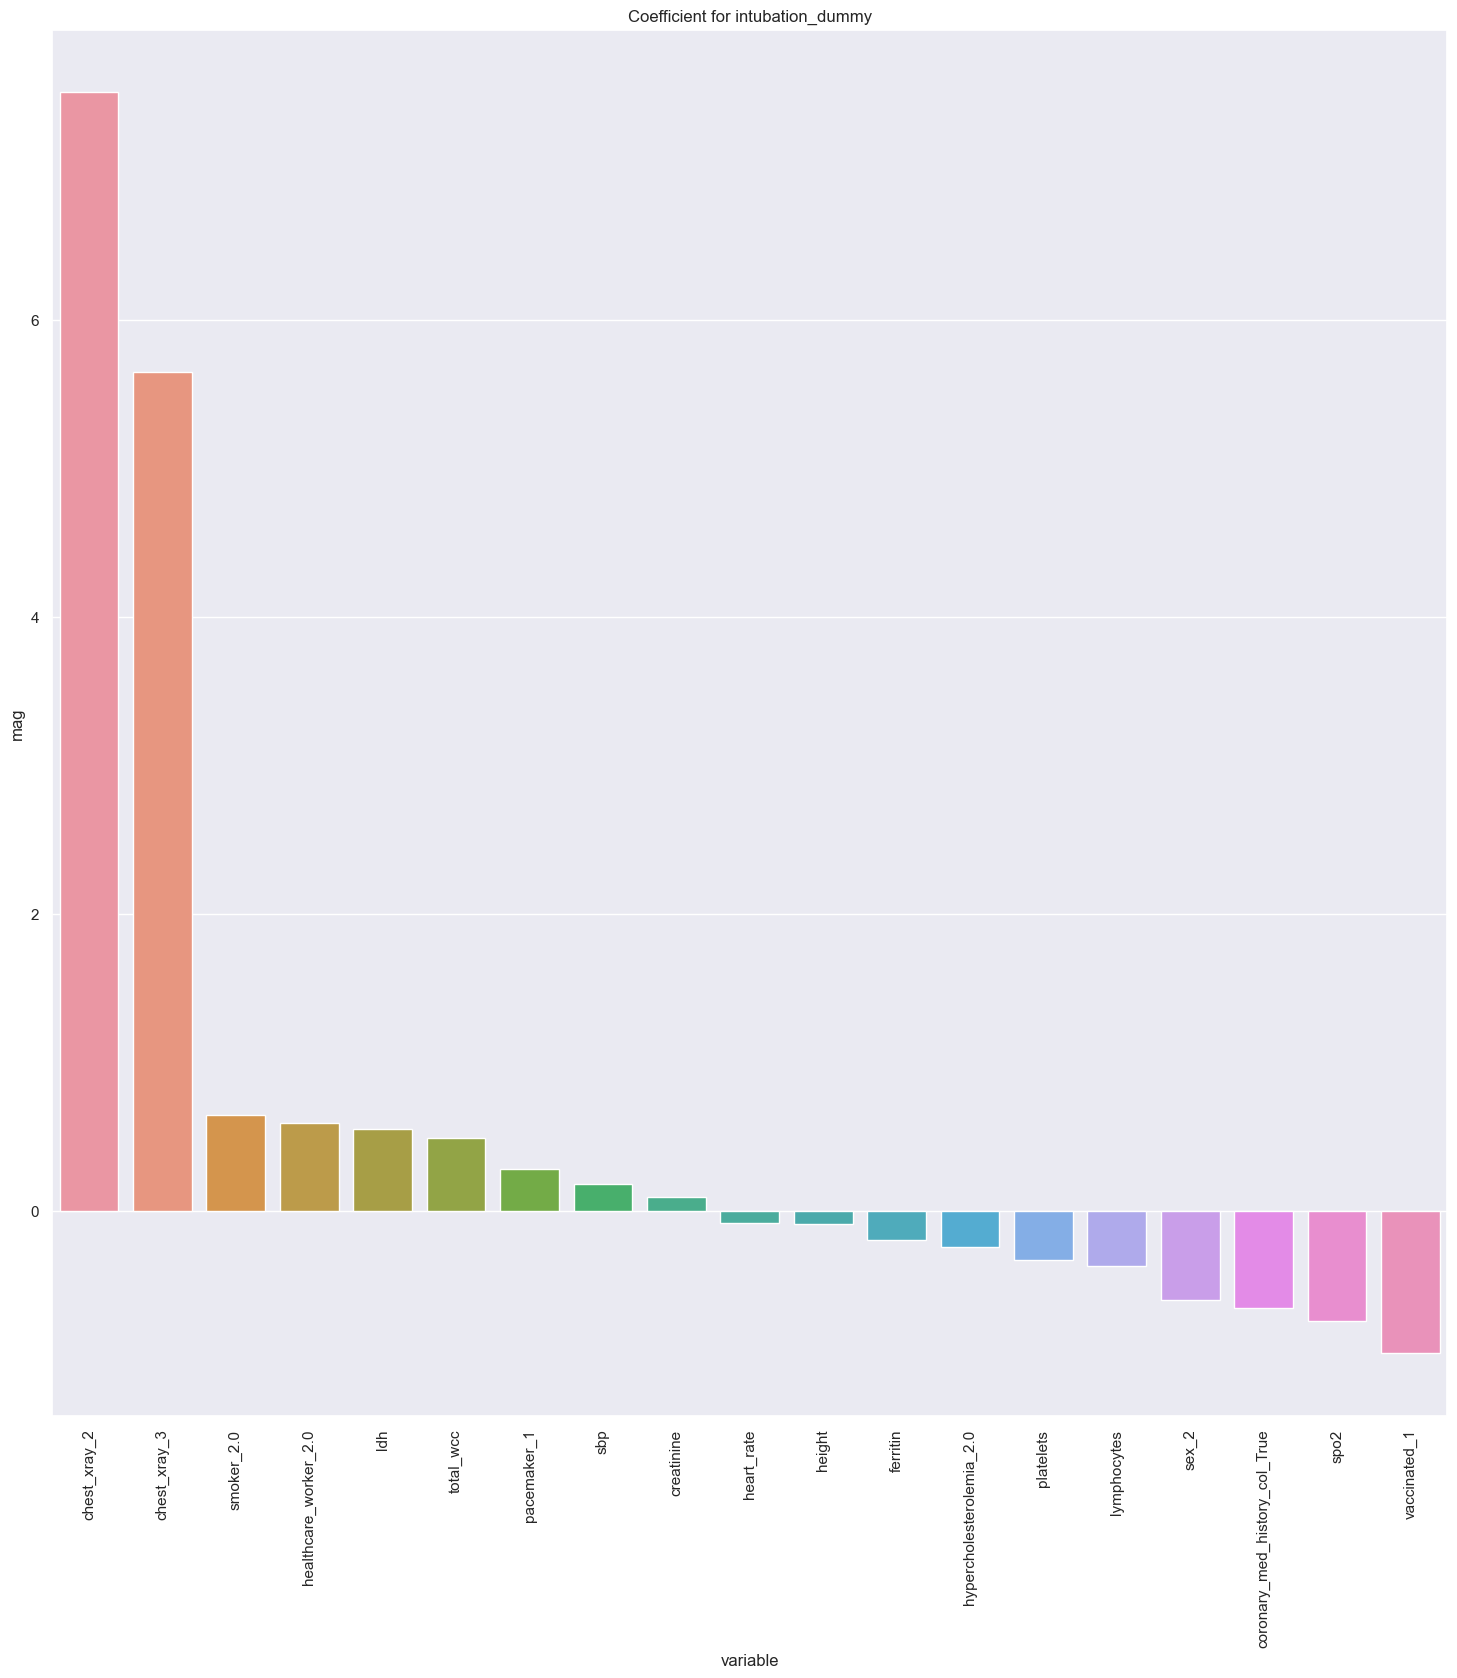

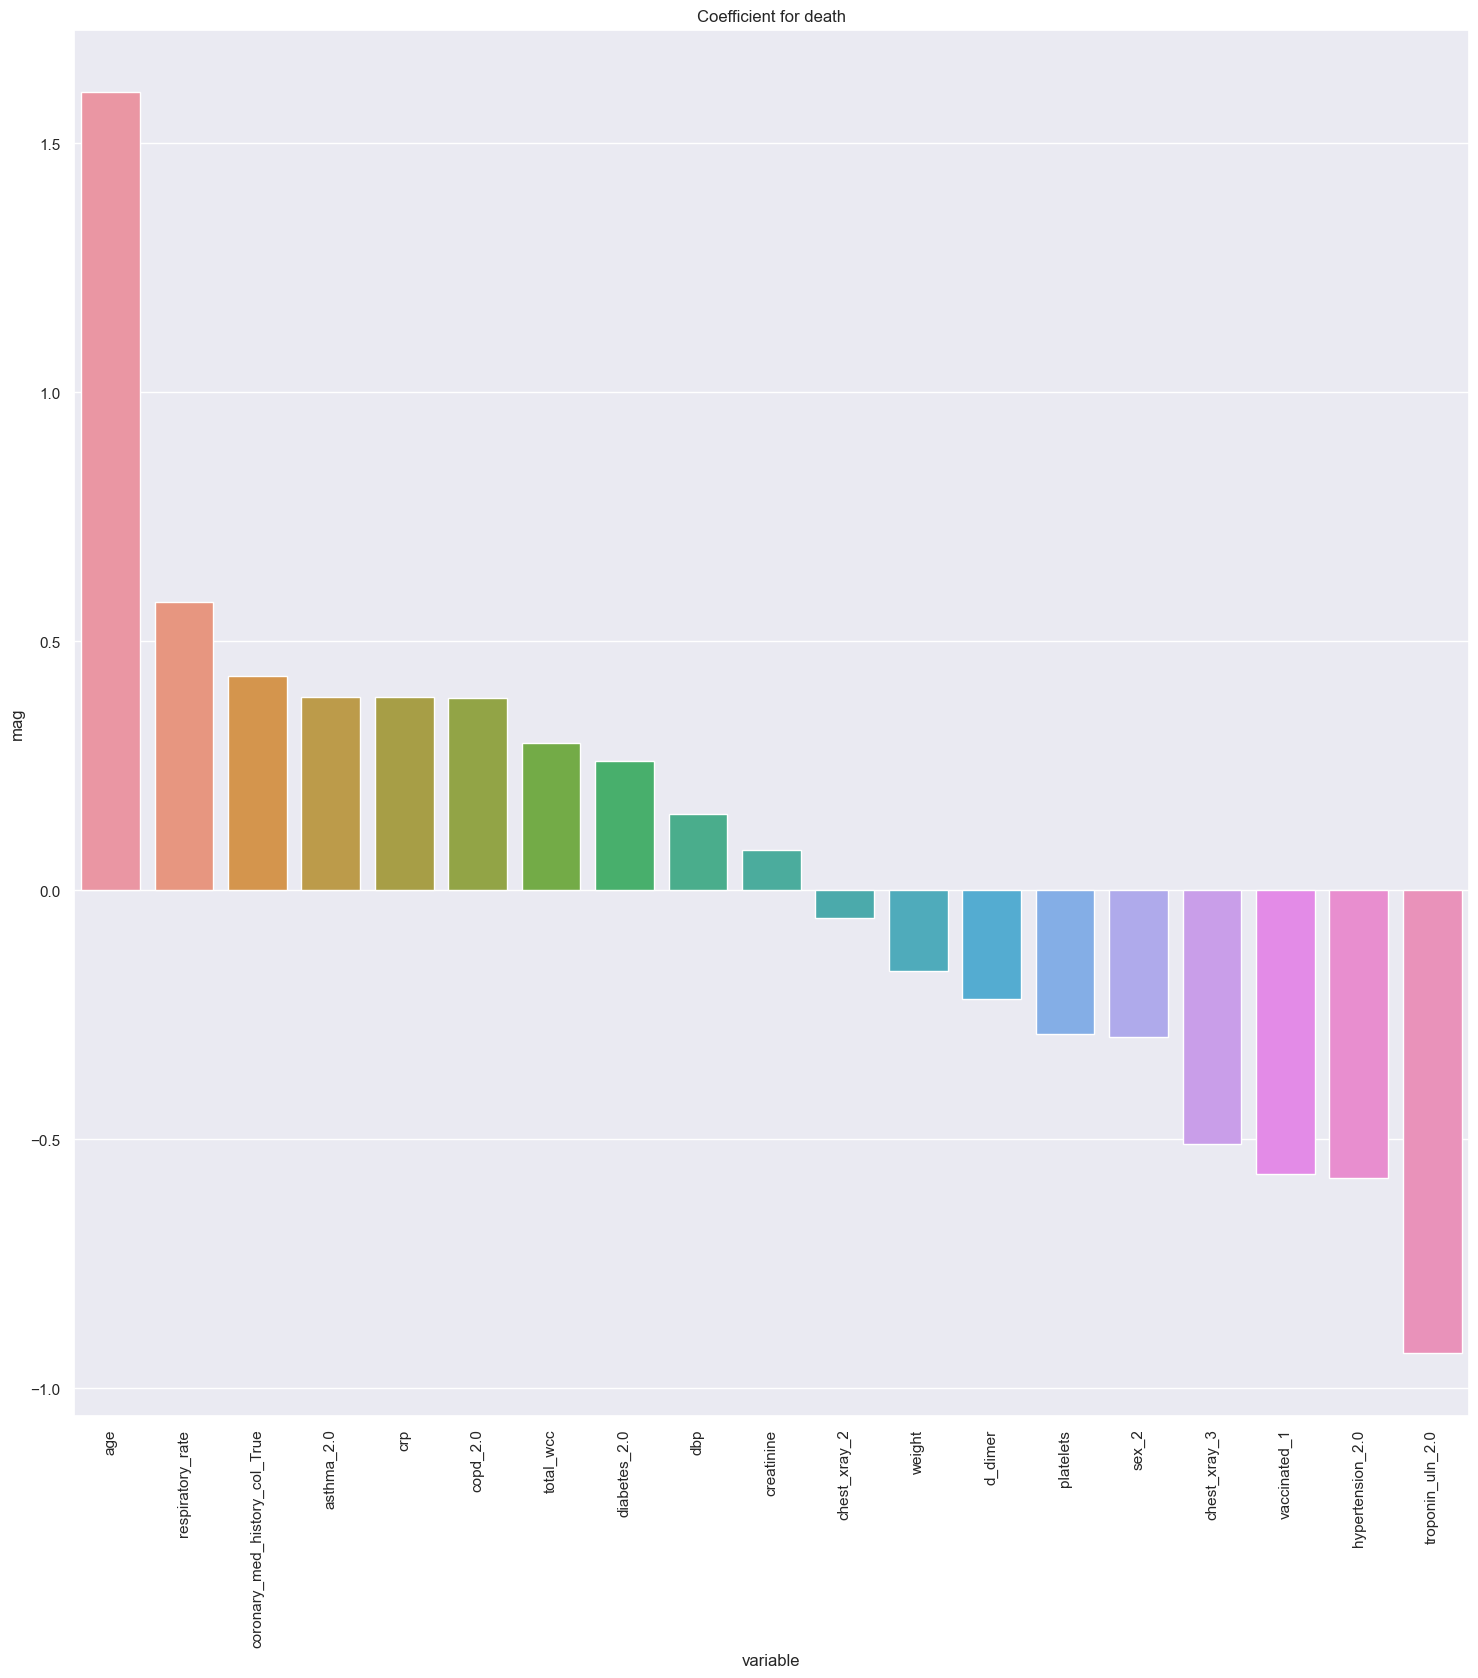

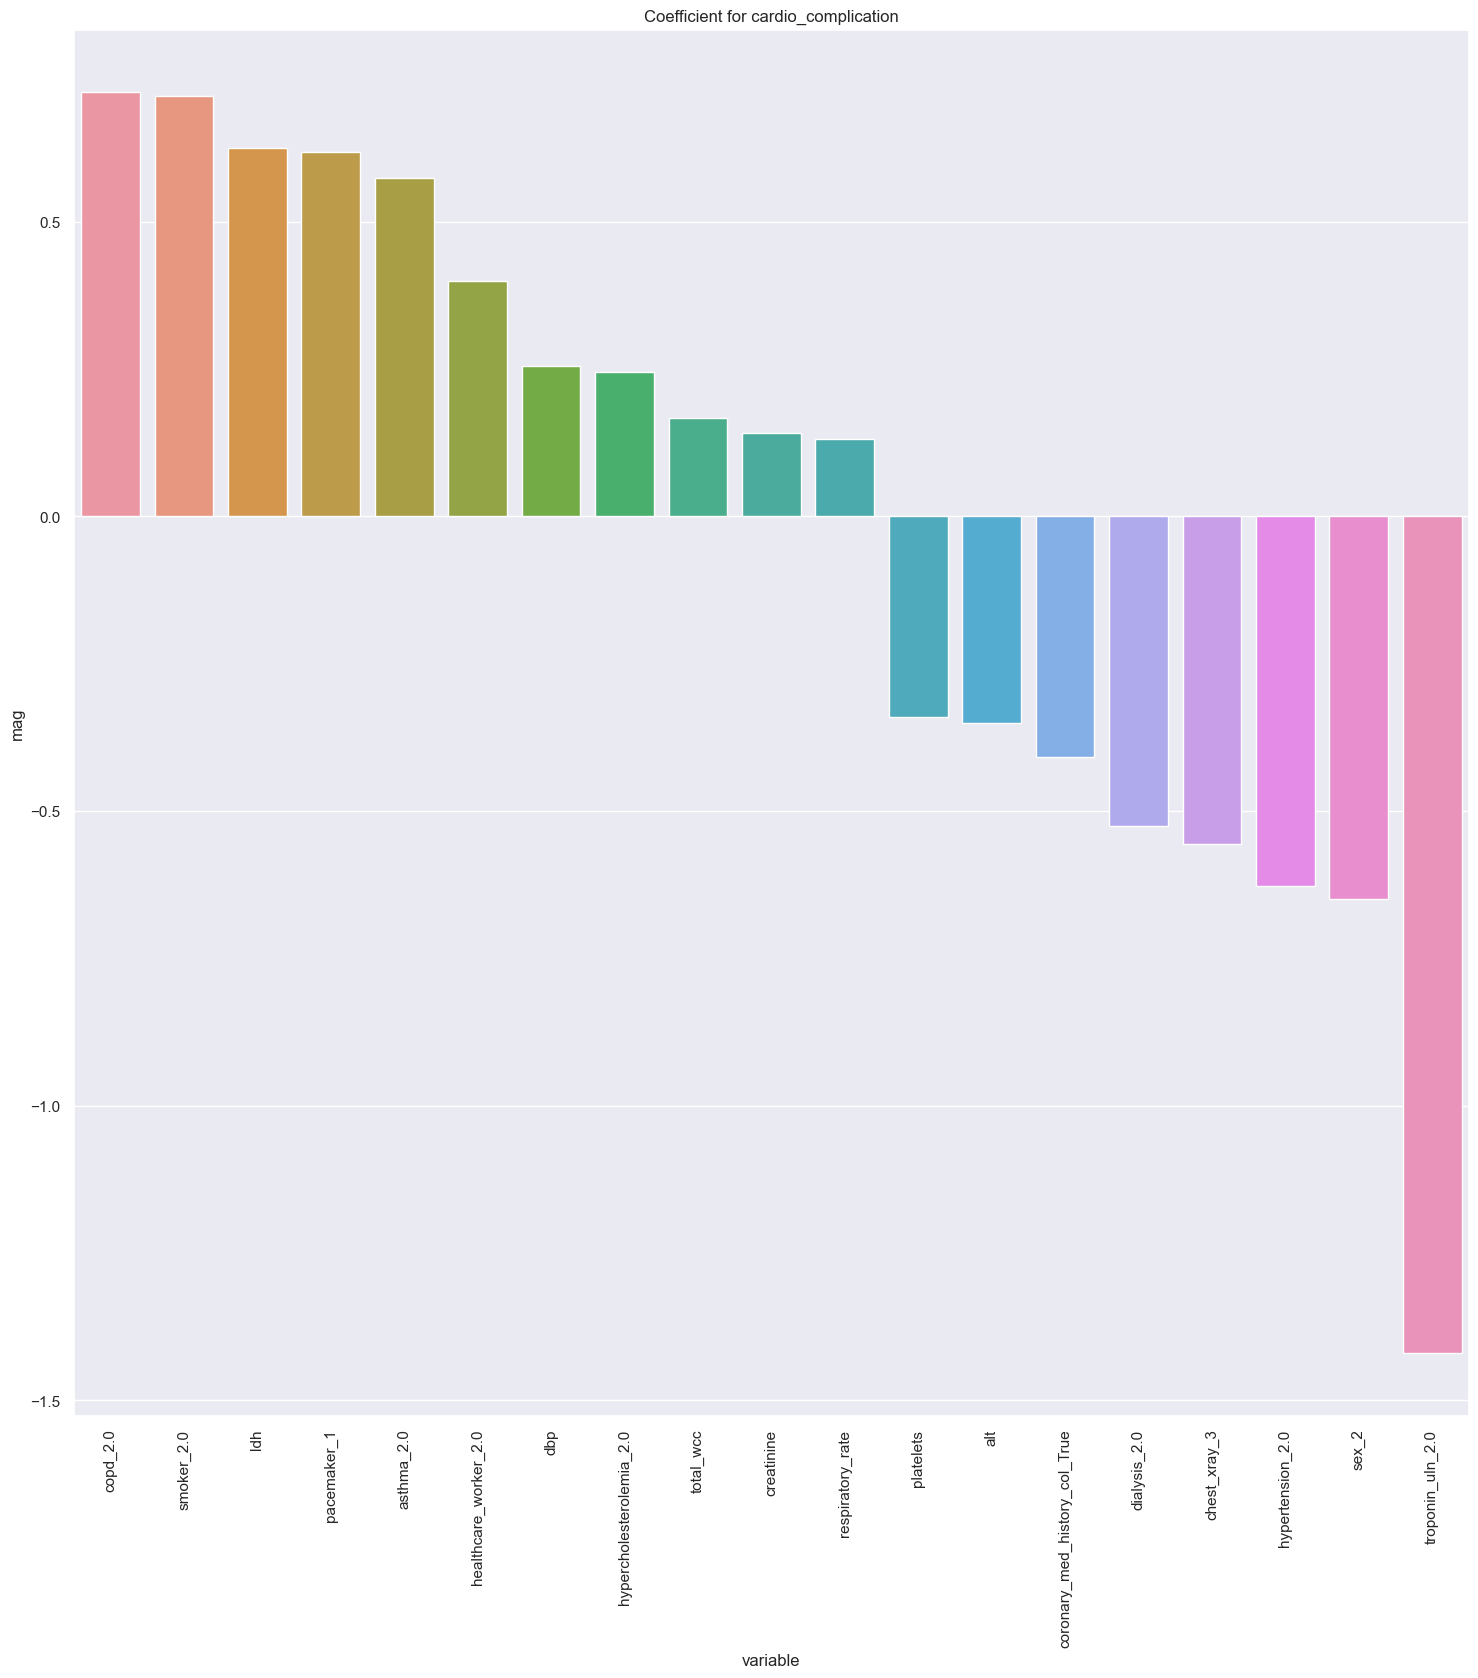

In [32]:
for p in predictor:
    test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    feature_select = test_pipe.named_steps["feature_select"].support_
    coefs = test_pipe.named_steps["logistic"].coef_
    coef_df = pd.DataFrame(data = {'variable' : X_train.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.savefig("figure/" + model_name + "_" +p+".png",bbox_inches="tight")
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(pipe,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)
 

In [33]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" +p+".pickle")
    
    feature_select = loaded_pipe.named_steps["feature_select"].support_
    cat_col_index = [i for i, x in enumerate(X_train.columns[feature_select]) if x in df_dummy_cat_cols]
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ("logistic",LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params()))])


    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

In [35]:
test_df

,model,accuracy,precision,recall,f1_score,auc,outcome
0,baseline_median_impute,0.909621,0.333333,0.107143,0.162162,0.544048,intubation_dummy
1,baseline_median_impute,0.883382,0.266667,0.121212,0.166667,0.542864,death
2,baseline_median_impute,0.953353,0.500000,0.062500,0.111111,0.529721,cardio_complication
3,logistic_feature_selection_median,0.915452,0.000000,0.000000,0.000000,0.498413,intubation_dummy
4,logistic_feature_selection_median,0.900875,0.000000,0.000000,0.000000,0.498387,death
5,logistic_feature_selection_median,0.950437,0.000000,0.000000,0.000000,0.498471,cardio_complication
6,logistic_feature_selection_median,0.731778,0.100000,0.285714,0.148148,0.528571,intubation_dummy
7,logistic_feature_selection_median,0.728863,0.125000,0.303030,0.176991,0.538612,death
8,logistic_feature_selection_median,0.749271,0.062500,0.312500,0.104167,0.541571,cardio_complication


In [36]:
score_df.to_csv(cv_result_filename )
test_df.to_csv(test_result_filename)

## L2 logistic regression

In [72]:
score_df = pd.read_csv(cv_result_filename ,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [73]:
score_df

,model,test_accuracy,outcome,fit_time,score_time,test_precision,test_recall,test_f1,test_roc_auc
0,baseline_median_impute,0.911737,intubation_dummy,0.083016,0.018803,0.590043,0.158333,0.240184,0.763806
1,baseline_median_impute,0.894949,death,0.023505,0.014603,0.520684,0.262299,0.345959,0.859799
2,baseline_median_impute,0.945295,cardio_complication,0.025005,0.018904,0.200000,0.026667,0.047059,0.582850
3,logistic_feature_selection_median,0.911737,intubation_dummy,0.028205,0.013003,0.590043,0.158333,0.240184,0.763806
4,logistic_feature_selection_median,0.894949,death,0.020904,0.012802,0.520684,0.262299,0.345959,0.859799
5,logistic_feature_selection_median,0.945295,cardio_complication,0.024005,0.013402,0.200000,0.026667,0.047059,0.582850
6,logistic_feature_selection_median_oversample,0.725733,intubation_dummy,0.487793,0.013902,0.178647,0.591667,0.273742,0.722079
7,logistic_feature_selection_median_oversample,0.778997,death,0.532502,0.014303,0.291679,0.722759,0.415047,0.832691
8,logistic_feature_selection_median_oversample,0.678349,cardio_complication,0.593612,0.013003,0.075188,0.431429,0.127833,0.573801
9,l2_feature_selection_median_impute_oversample,0.725733,intubation_dummy,0.440781,0.013103,0.178647,0.591667,0.273742,0.722079


In [74]:
model_name = "l2_feature_selection_median_impute"

In [75]:
X_train = train.drop(predictor, axis=1)
cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]


pipeline = Pipeline(steps=[
    ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
    #("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
    ("scaler", StandardScaler()), 
    ("logistic", LogisticRegression(random_state=random_seed,max_iter = 1000,penalty = 'l2',n_jobs=4,solver = 'lbfgs'))])

param_grid = {
    "logistic__C": np.logspace(1e-2,1e2,num=10)
}

grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5,scoring=scoring_method)

In [76]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    grid.fit(X_train, y_train)
    
    pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        #("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ("feature_select",
         SequentialFeatureSelector(LogisticRegression(max_iter = 1000,penalty = 'l2',
                                                      C = grid.best_params_["logistic__C"]), 
                                   n_features_to_select='auto',scoring=scoring_method)),
        ("logistic",LogisticRegression(max_iter = 1000,penalty = 'l2',C = grid.best_params_["logistic__C"]))])
    
    pipe.fit(X_train, y_train)
    joblib.dump(pipe,"model/" + model_name + "_" + p +".pickle")

In [77]:
grid.best_params_["logistic__C"]

1.023292992280754

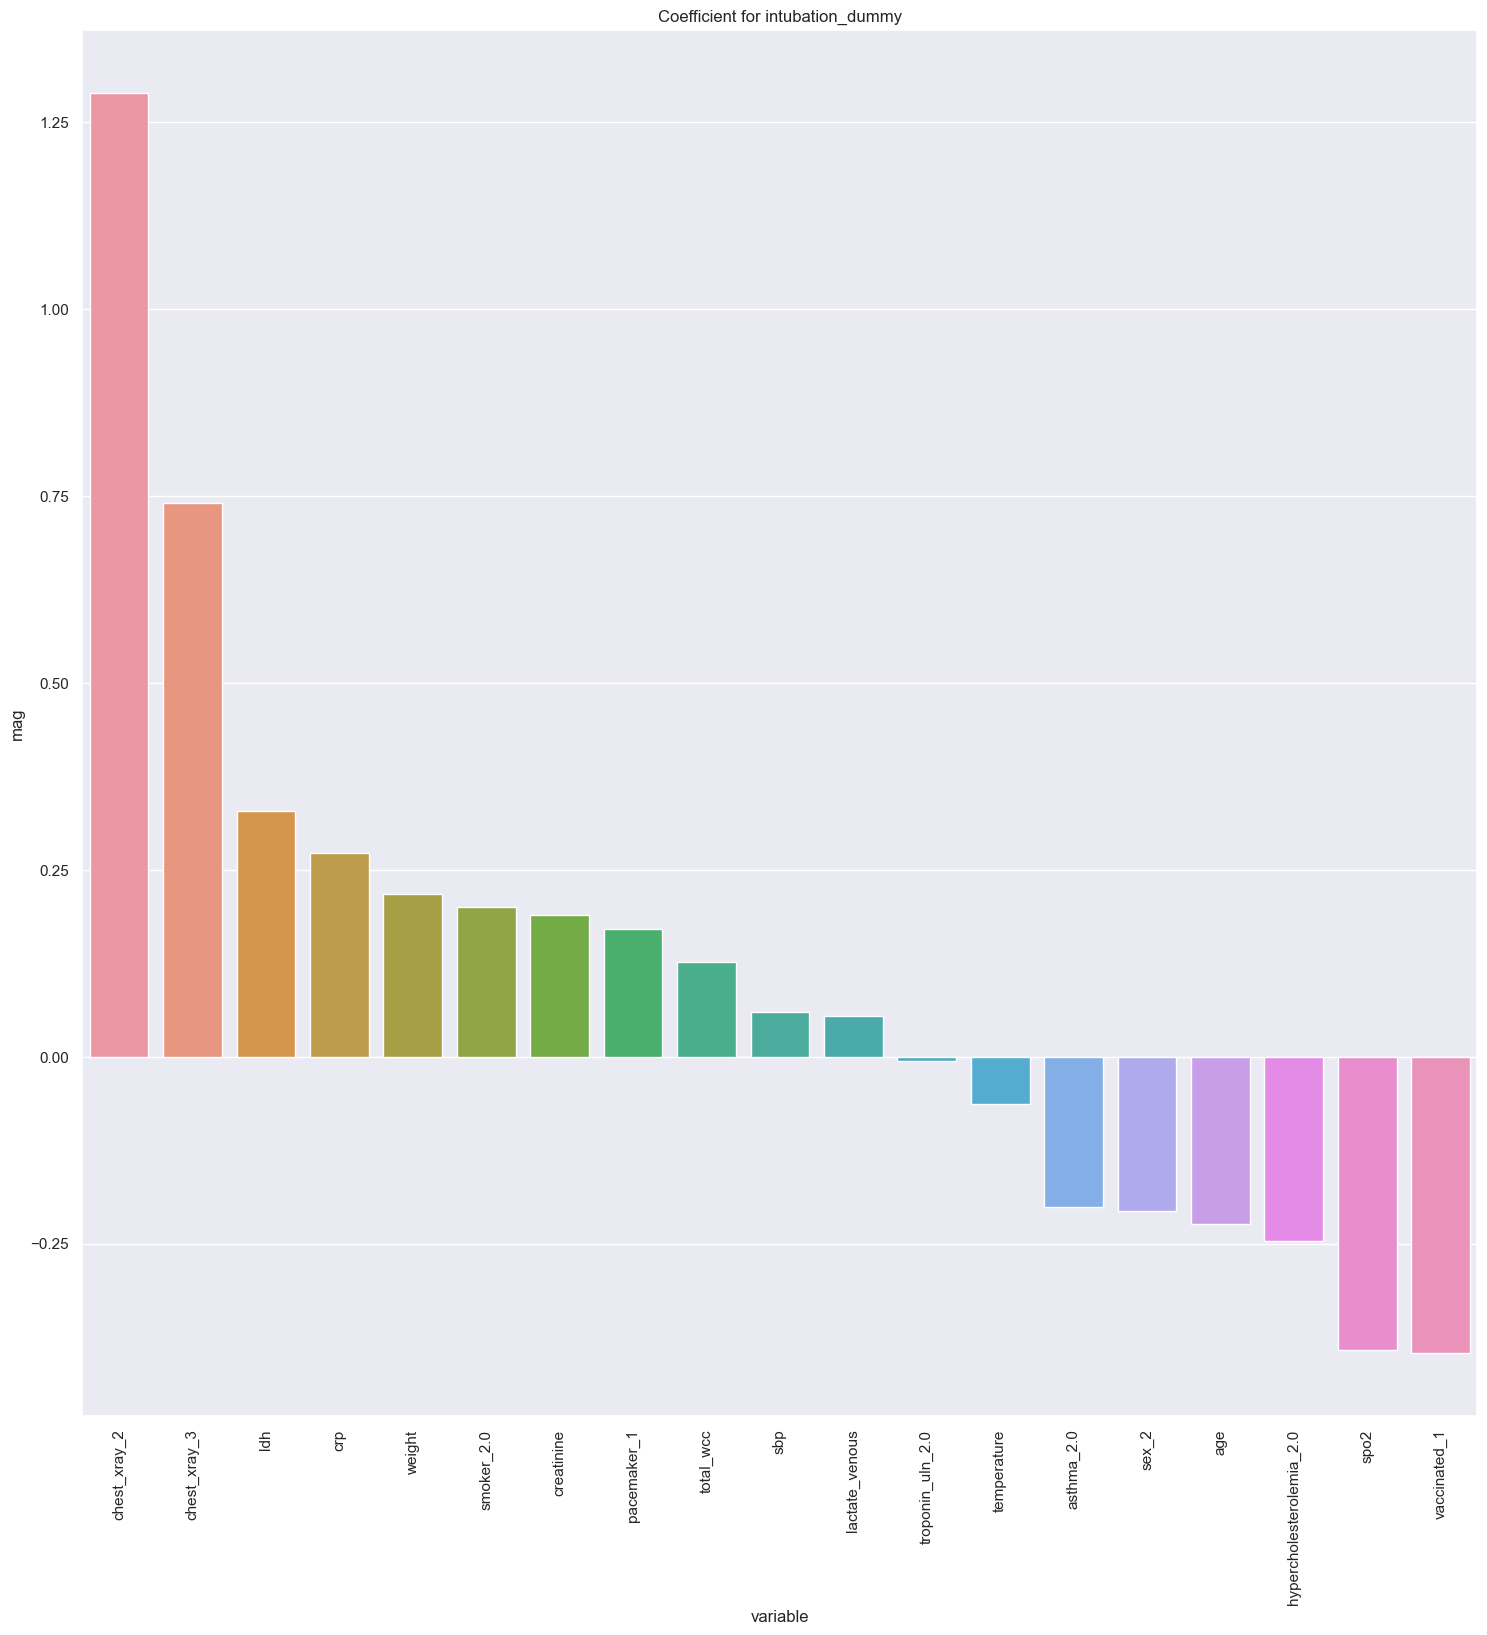

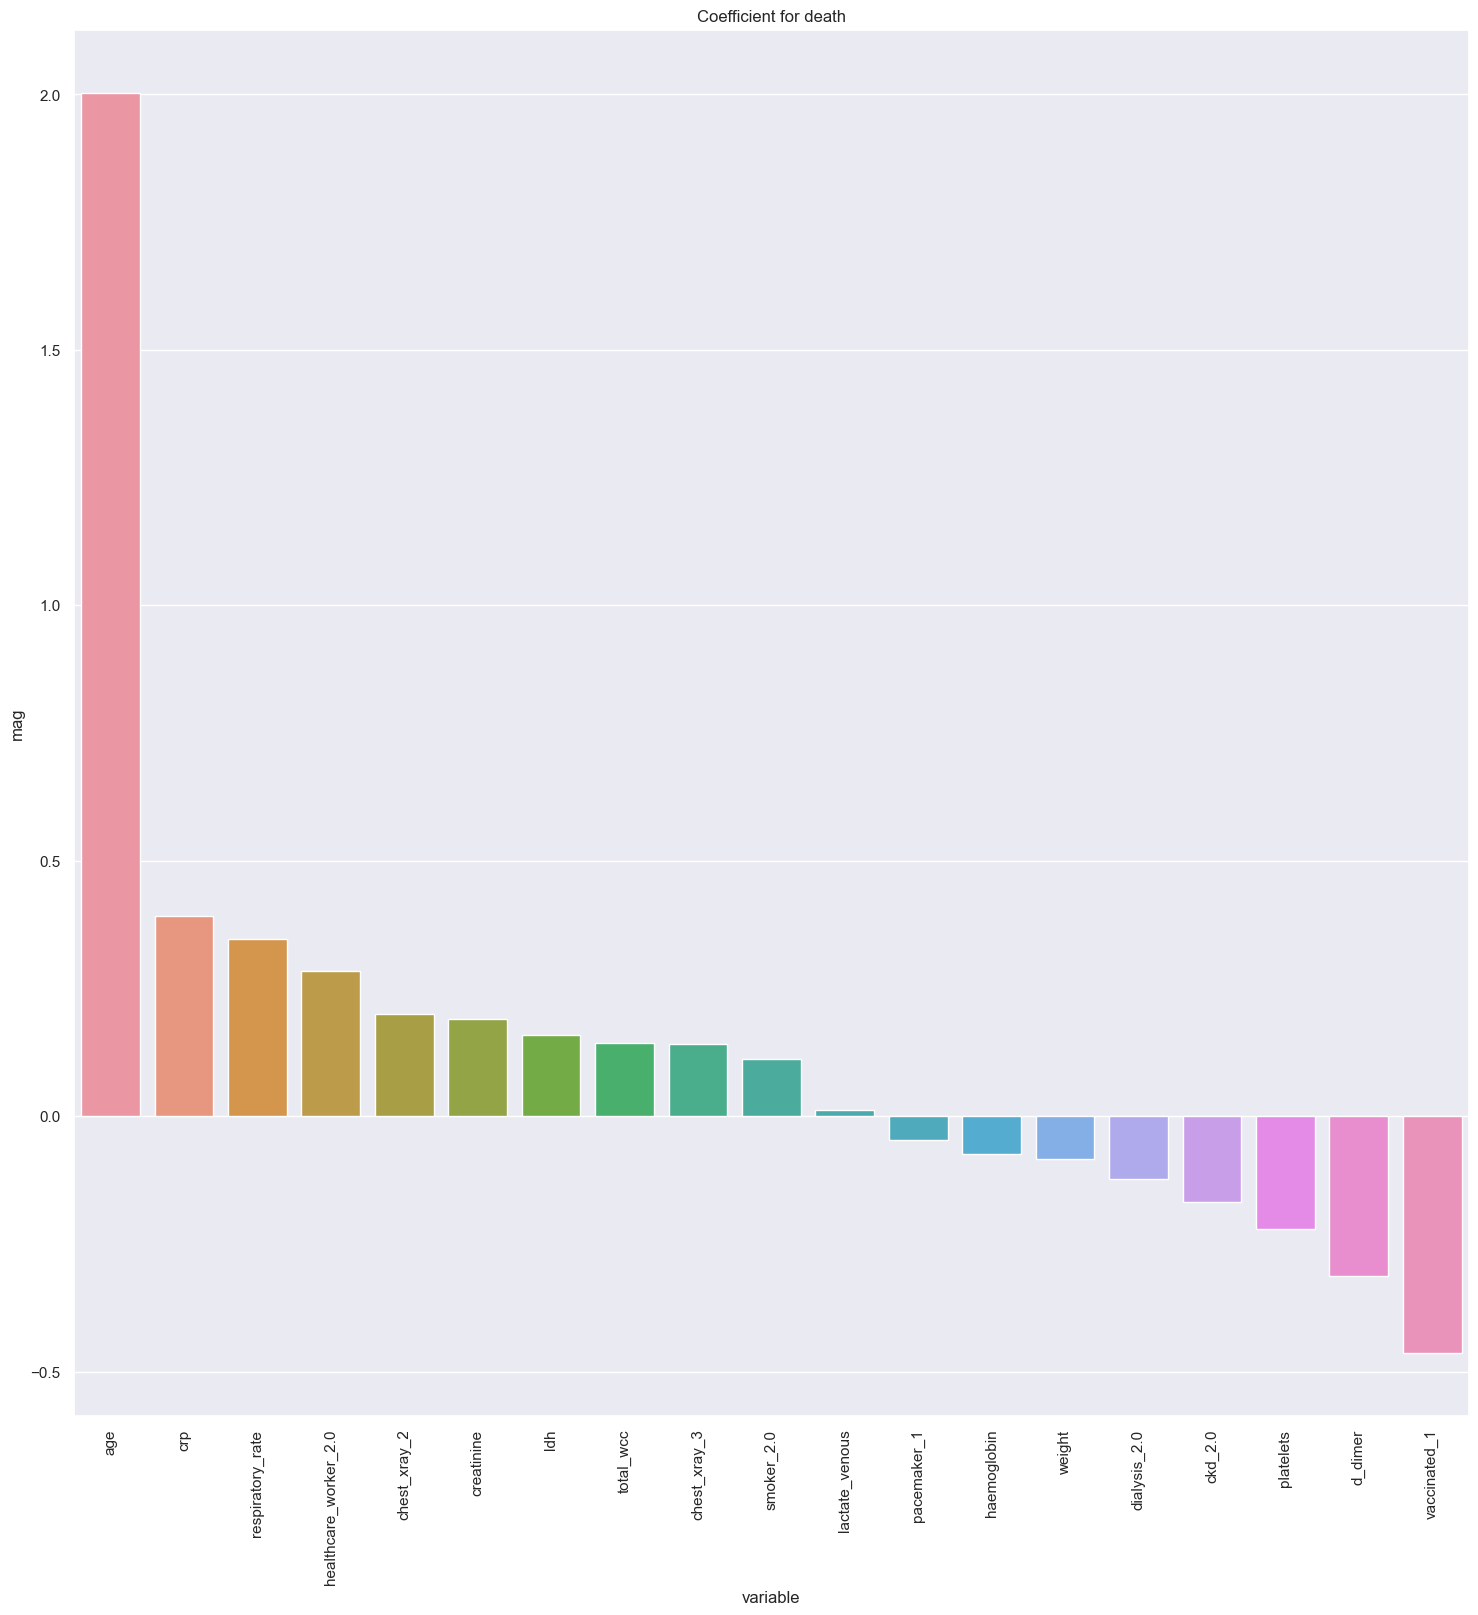

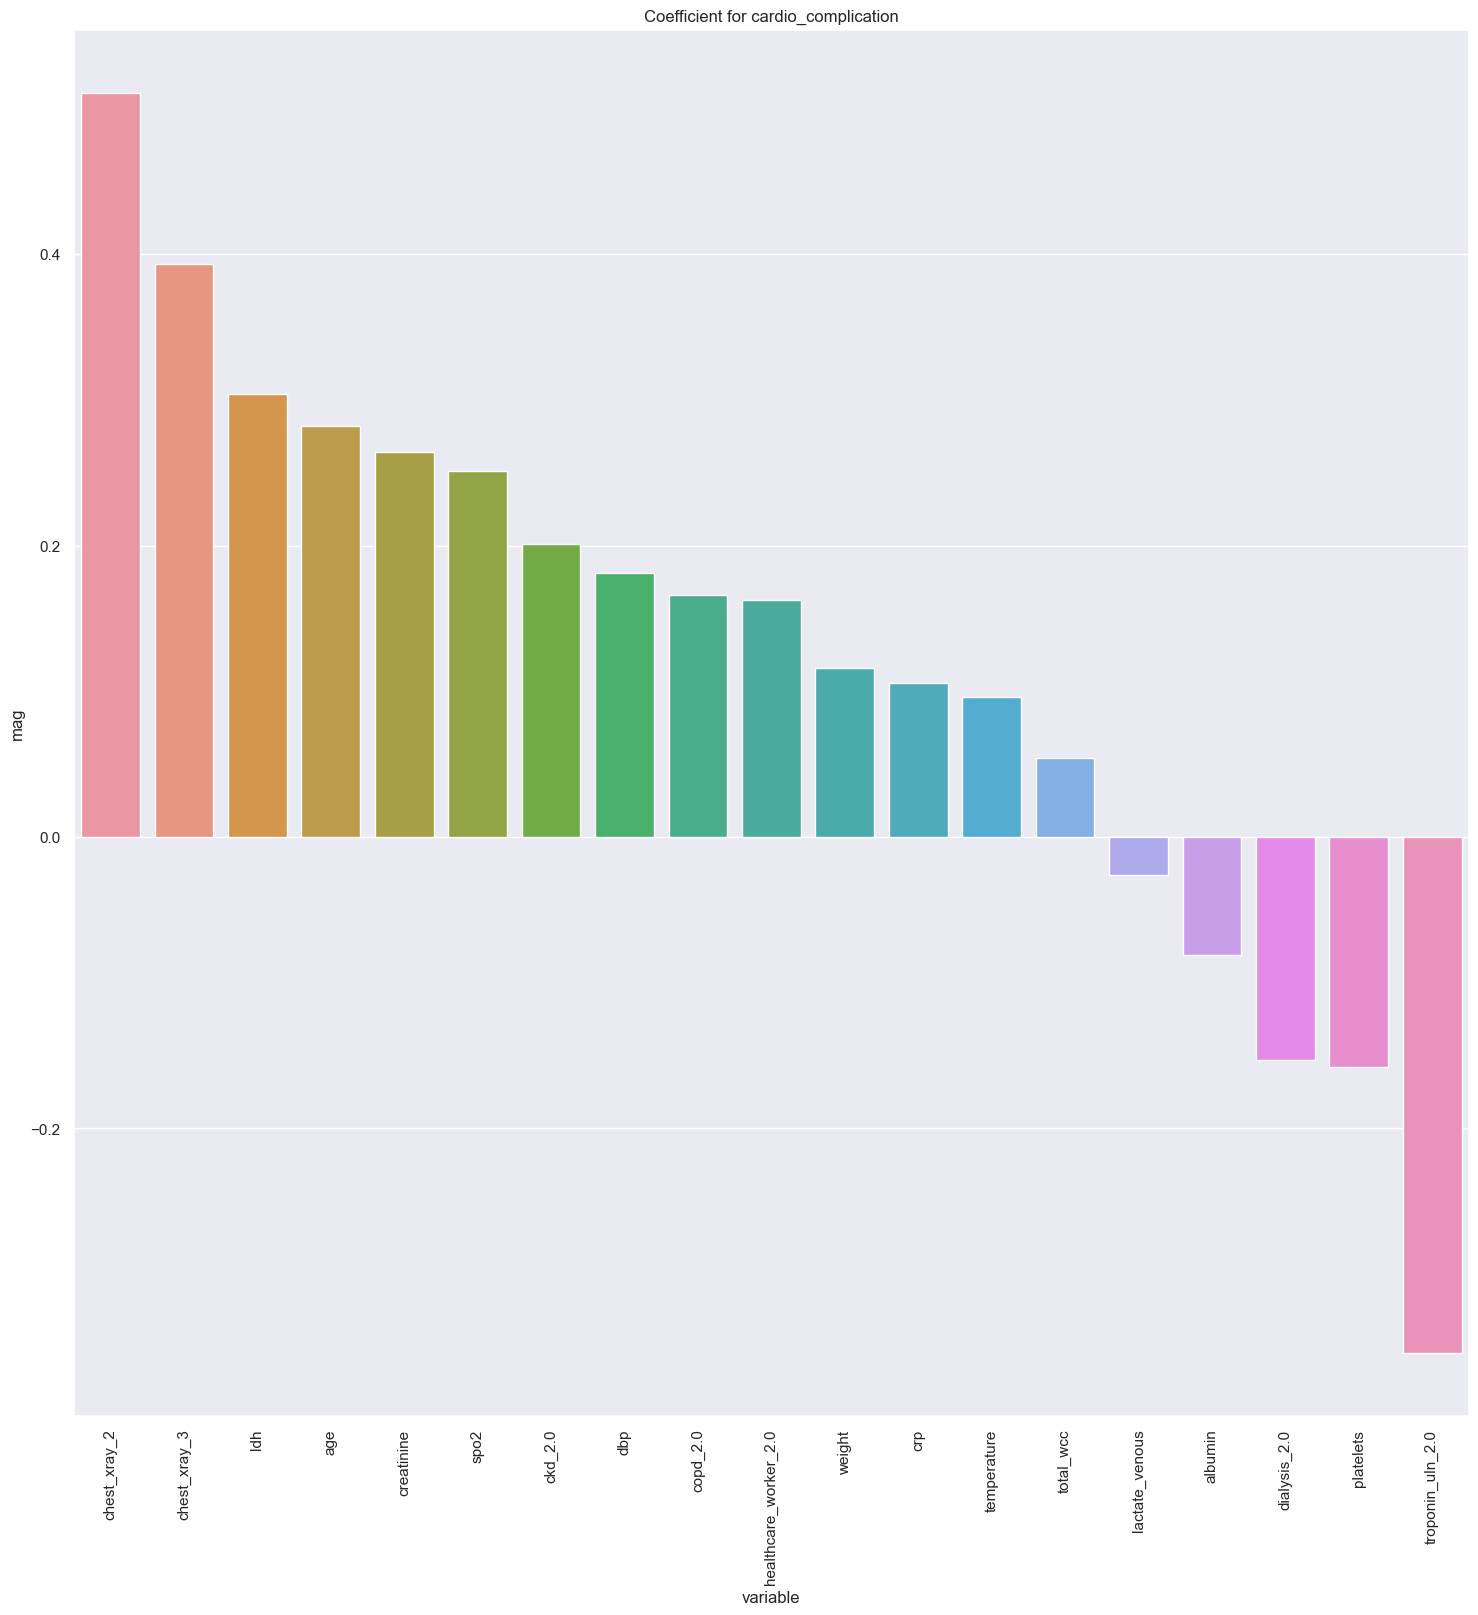

In [78]:
for p in predictor:
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    feature_select = loaded_pipe.named_steps["feature_select"].support_
    coefs = loaded_pipe.named_steps["logistic"].coef_
    coef_df = pd.DataFrame(data = {'variable' : X_train.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.savefig("figure/" + model_name + "_" +p+".png",bbox_inches="tight")
    
     
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(loaded_pipe,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [79]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    feature_select = loaded_pipe.named_steps["feature_select"].support_
    cat_col_index = [i for i, x in enumerate(X_train.columns[feature_select]) if x in df_dummy_cat_cols]
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ("logistic",LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params()))])
    
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

In [80]:
loaded_pipe.named_steps["logistic"].get_params()

{'C': 1.023292992280754,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [81]:
test_df

,model,accuracy,precision,recall,f1_score,auc,outcome
0,baseline_median_impute,0.909621,0.333333,0.107143,0.162162,0.544048,intubation_dummy
1,baseline_median_impute,0.883382,0.266667,0.121212,0.166667,0.542864,death
2,baseline_median_impute,0.953353,0.500000,0.062500,0.111111,0.529721,cardio_complication
3,logistic_feature_selection_median,0.915452,0.000000,0.000000,0.000000,0.498413,intubation_dummy
4,logistic_feature_selection_median,0.900875,0.000000,0.000000,0.000000,0.498387,death
5,logistic_feature_selection_median,0.950437,0.000000,0.000000,0.000000,0.498471,cardio_complication
6,logistic_feature_selection_median_oversample,0.731778,0.100000,0.285714,0.148148,0.528571,intubation_dummy
7,logistic_feature_selection_median_oversample,0.728863,0.125000,0.303030,0.176991,0.538612,death
8,logistic_feature_selection_median_oversample,0.749271,0.062500,0.312500,0.104167,0.541571,cardio_complication
9,l2_feature_selection_median_impute_oversample,0.752187,0.139241,0.392857,0.205607,0.588492,intubation_dummy


In [82]:
score_df.to_csv(cv_result_filename )
test_df.to_csv(test_result_filename)

## L1 logistic regression

In [95]:
score_df = pd.read_csv(cv_result_filename ,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [96]:
model_name = "l1_feature_selection_median_impute"

In [97]:
X_train = train.drop(predictor, axis=1)
cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]

pipeline = Pipeline(steps=[
    ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
    #("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
    ("scaler", StandardScaler()), 
    ("logistic", LogisticRegression(random_state=random_seed,max_iter = 5000,penalty = 'l1',n_jobs=4,solver = 'saga'))])

param_grid = {
    "logistic__C": np.linspace(1.0,1e2,num=10)
}

grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5,scoring=scoring_method)

In [98]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    grid.fit(X_train, y_train)
    
    pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        #("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ("feature_select",
         SequentialFeatureSelector(LogisticRegression(penalty = 'l1',max_iter = 5000,
                                                      C = grid.best_params_["logistic__C"],solver = 'saga')
                                   , n_features_to_select='auto',scoring=scoring_method)),
        ("logistic",LogisticRegression(penalty = 'l1',max_iter = 5000,C = grid.best_params_["logistic__C"],solver = 'saga'))])
    
    pipe.fit(X_train, y_train)
    joblib.dump(pipe,"model/" + model_name + "_" + p +".pickle")

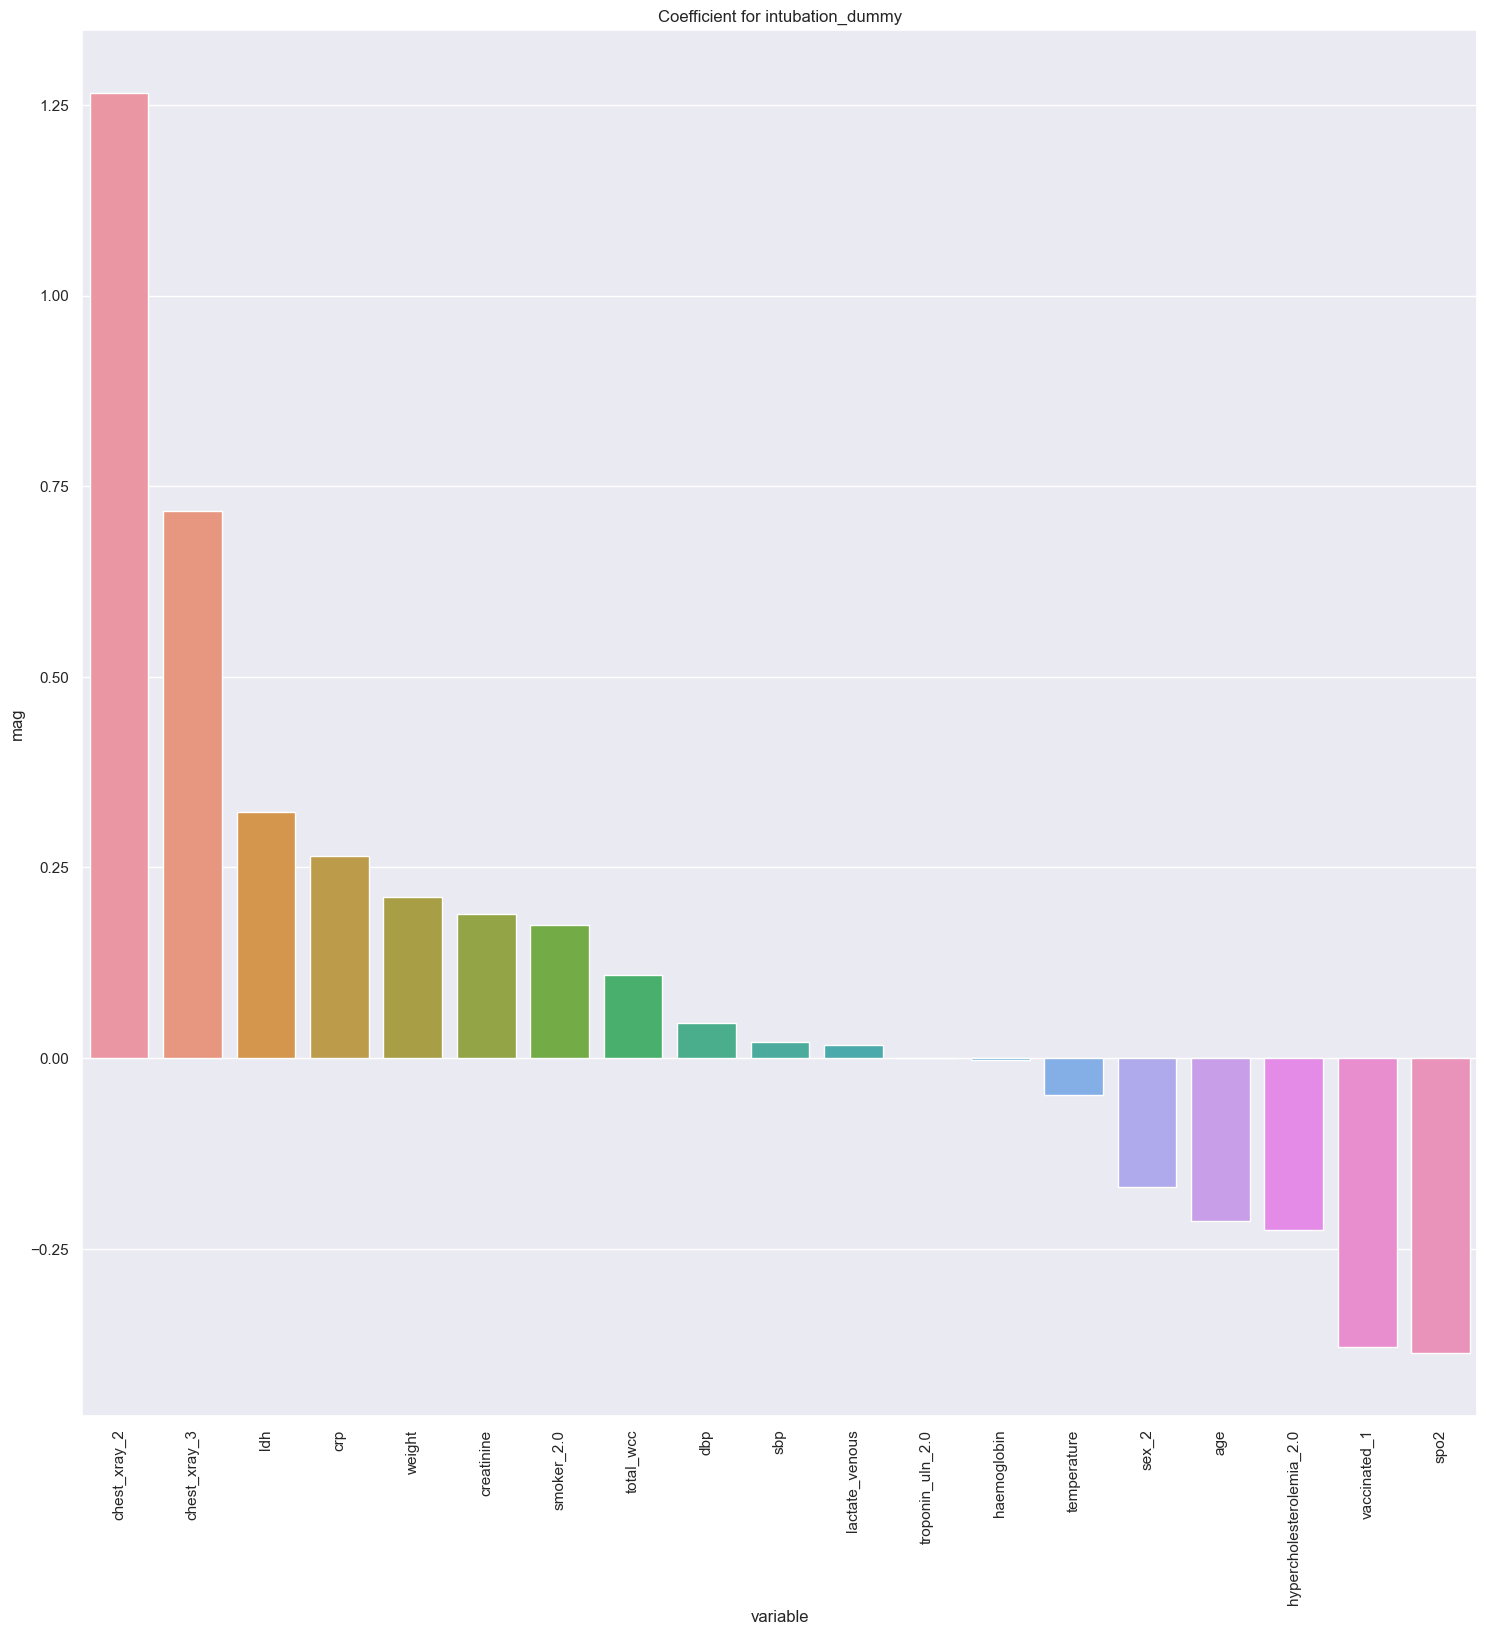

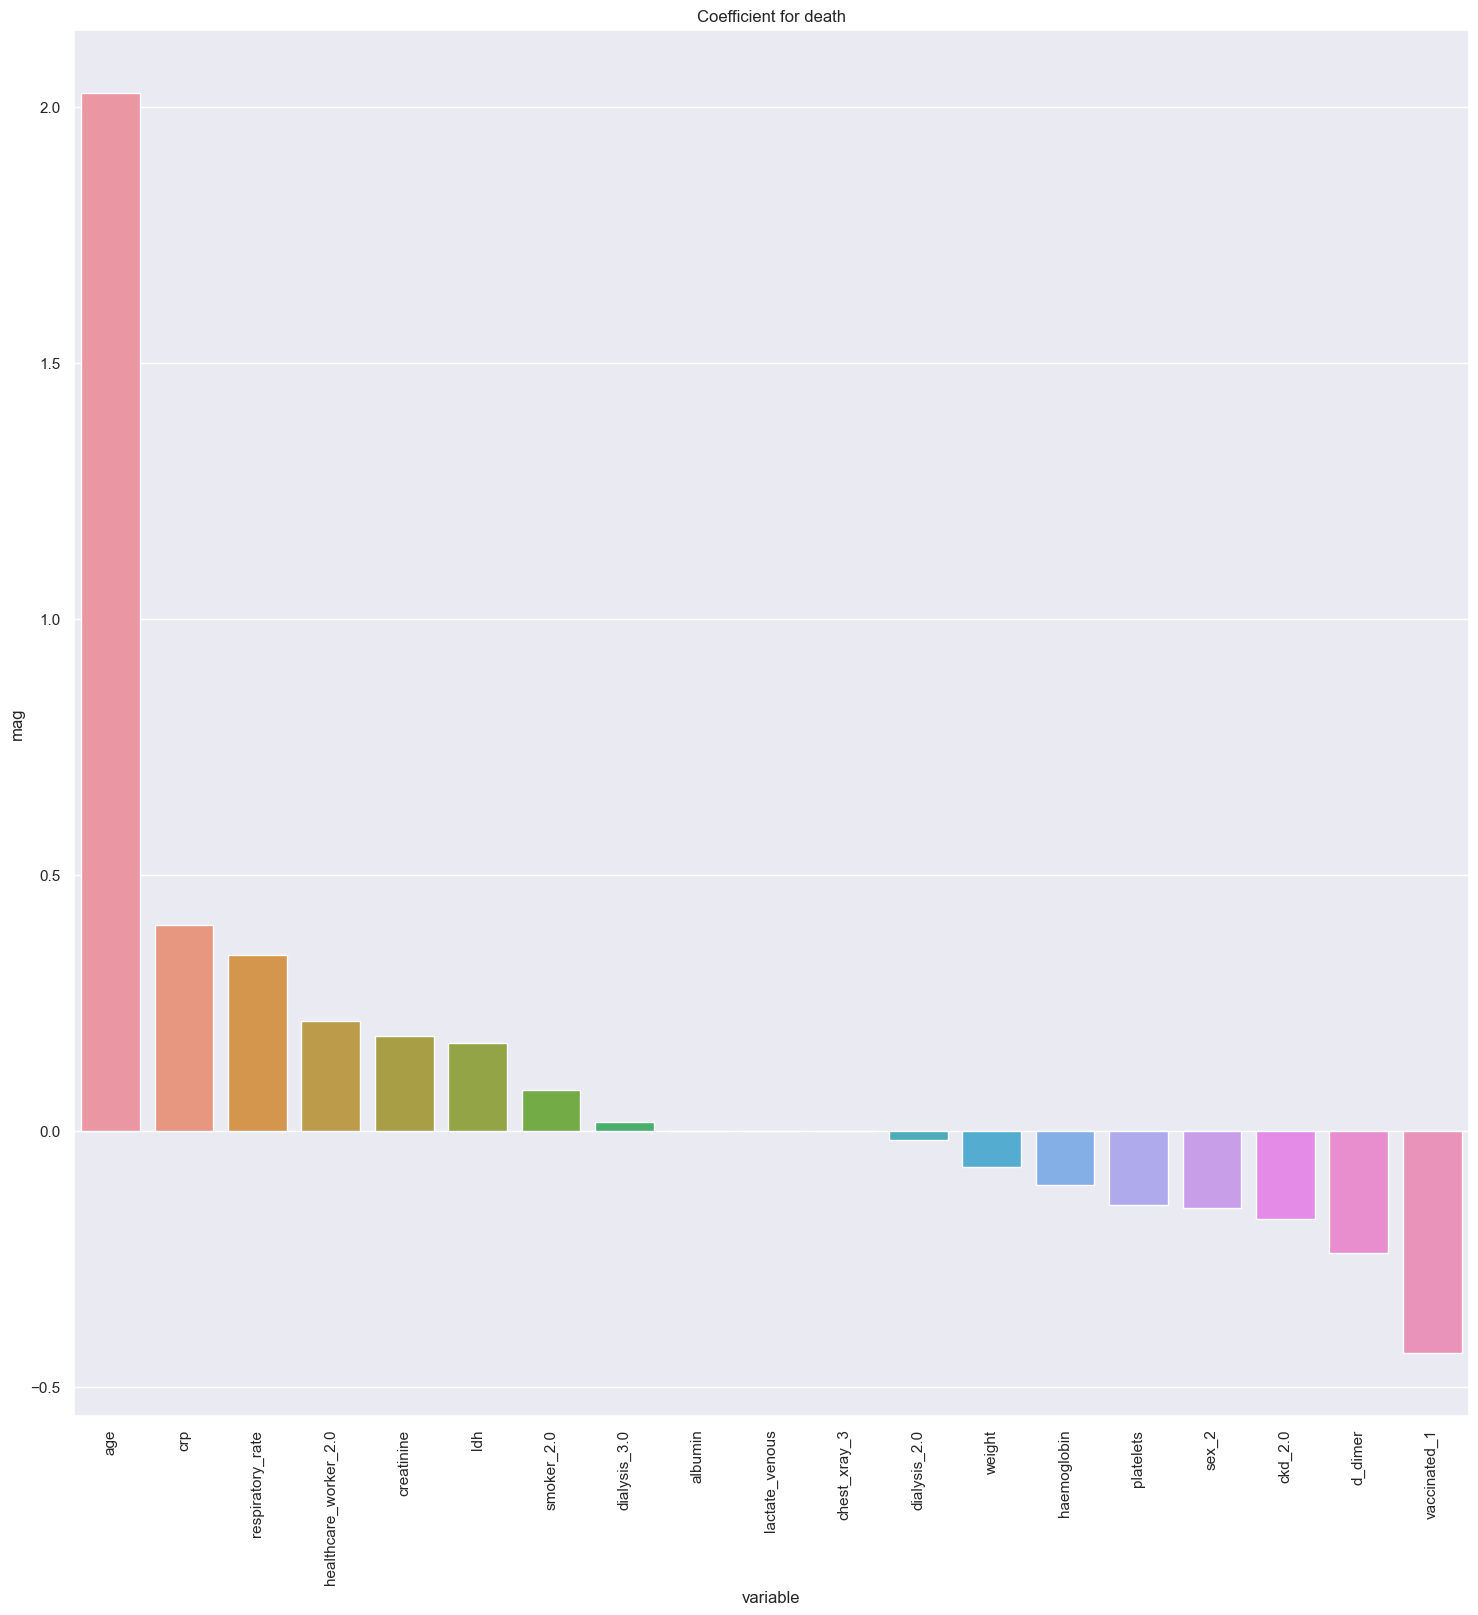

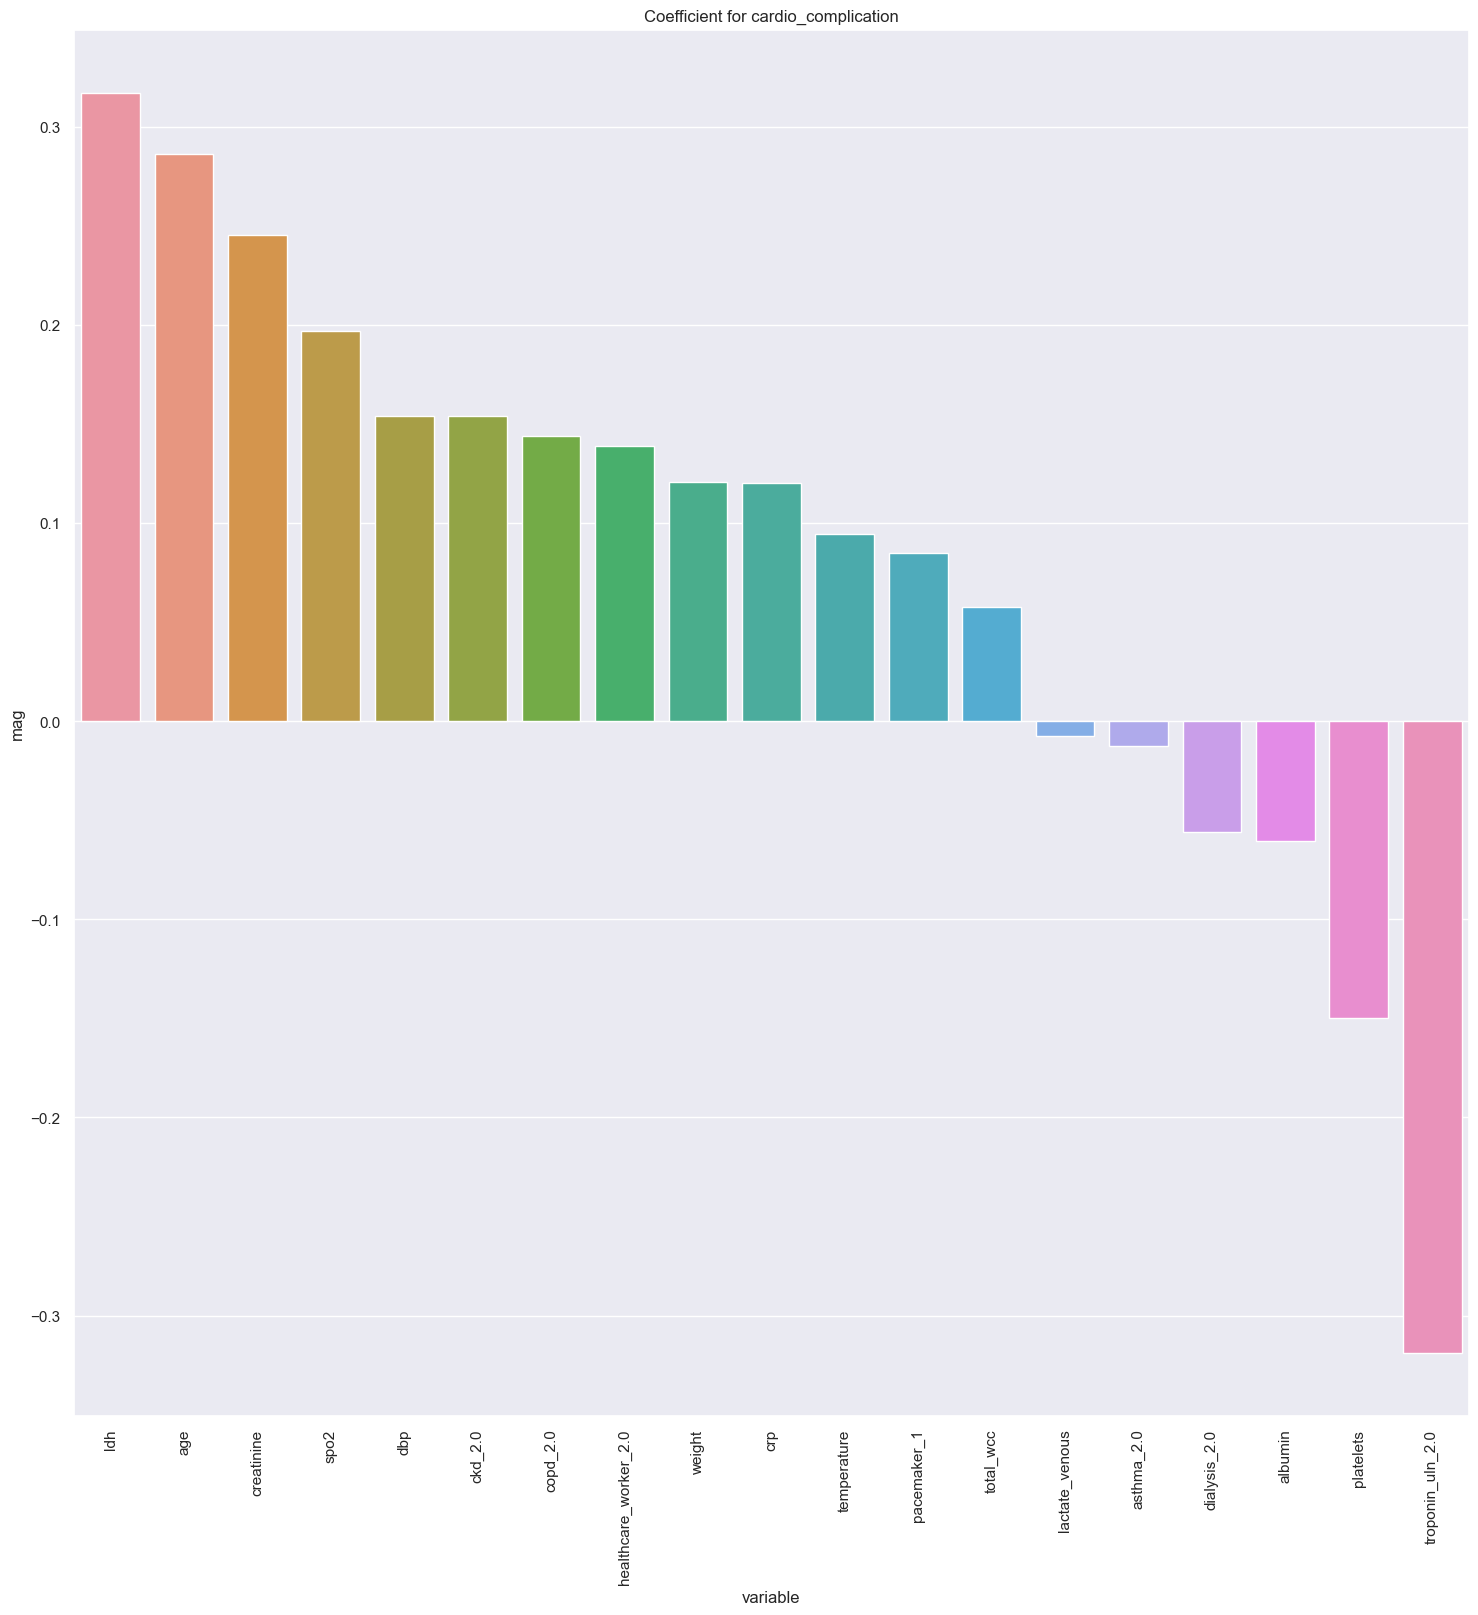

In [99]:
for p in predictor:
    loaded_pipe = joblib.load("model/" + model_name + "_"+p+".pickle")
    feature_select = loaded_pipe.named_steps["feature_select"].support_
    coefs = loaded_pipe.named_steps["logistic"].coef_
    coef_df = pd.DataFrame(data = {'variable' : X_train.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.savefig("figure/" + model_name + "_" +p+".png",bbox_inches="tight")
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(loaded_pipe,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [100]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    feature_select = loaded_pipe.named_steps["feature_select"].support_
    cat_col_index = [i for i, x in enumerate(X_train.columns[feature_select]) if x in df_dummy_cat_cols]
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        #("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ("logistic",LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params()))])
    
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
score_df

,model,test_accuracy,outcome,fit_time,score_time,test_precision,test_recall,test_f1,test_roc_auc
0,baseline_median_impute,0.911737,intubation_dummy,0.083016,0.018803,0.590043,0.158333,0.240184,0.763806
1,baseline_median_impute,0.894949,death,0.023505,0.014603,0.520684,0.262299,0.345959,0.859799
2,baseline_median_impute,0.945295,cardio_complication,0.025005,0.018904,0.200000,0.026667,0.047059,0.582850
3,logistic_feature_selection_median,0.911737,intubation_dummy,0.028205,0.013003,0.590043,0.158333,0.240184,0.763806
4,logistic_feature_selection_median,0.894949,death,0.020904,0.012802,0.520684,0.262299,0.345959,0.859799
5,logistic_feature_selection_median,0.945295,cardio_complication,0.024005,0.013402,0.200000,0.026667,0.047059,0.582850
6,logistic_feature_selection_median_oversample,0.725733,intubation_dummy,0.487793,0.013902,0.178647,0.591667,0.273742,0.722079
7,logistic_feature_selection_median_oversample,0.778997,death,0.532502,0.014303,0.291679,0.722759,0.415047,0.832691
8,logistic_feature_selection_median_oversample,0.678349,cardio_complication,0.593612,0.013003,0.075188,0.431429,0.127833,0.573801
9,l2_feature_selection_median_impute_oversample,0.725733,intubation_dummy,0.440781,0.013103,0.178647,0.591667,0.273742,0.722079


In [103]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)

## Elastic net

In [32]:
score_df = pd.read_csv(cv_result_filename ,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [33]:
from sklearn.linear_model import ElasticNet
model_name = "elasticnet_feature_selection_median_impute_oversample"

In [34]:
param_grid = {
    "feature_select__estimator__C": np.linspace(1e-3,1,num=5),
    "feature_select__estimator__l1_ratio": np.linspace(1e-1,1,num=5),
    "logistic__C": np.linspace(1e-3,1,num=5),
    "logistic__l1_ratio": np.linspace(1e-1,1,num=5)
}


In [35]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]


    pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ("feature_select",
         SelectFromModel(
             LogisticRegression(random_state=random_seed,max_iter = 5000,penalty='elasticnet',solver='saga'), 
             max_features=15)),
        ("logistic",
             LogisticRegression(random_state=random_seed,max_iter = 5000,penalty='elasticnet',solver='saga'))])
    
    grid_train = GridSearchCV(pipe,
                    param_grid = param_grid,cv=5,scoring=scoring_method)
    
    grid_train.fit(X_train, y_train)
    joblib.dump(grid_train.best_estimator_,"model/" + model_name + "_" + p +".pickle")
    

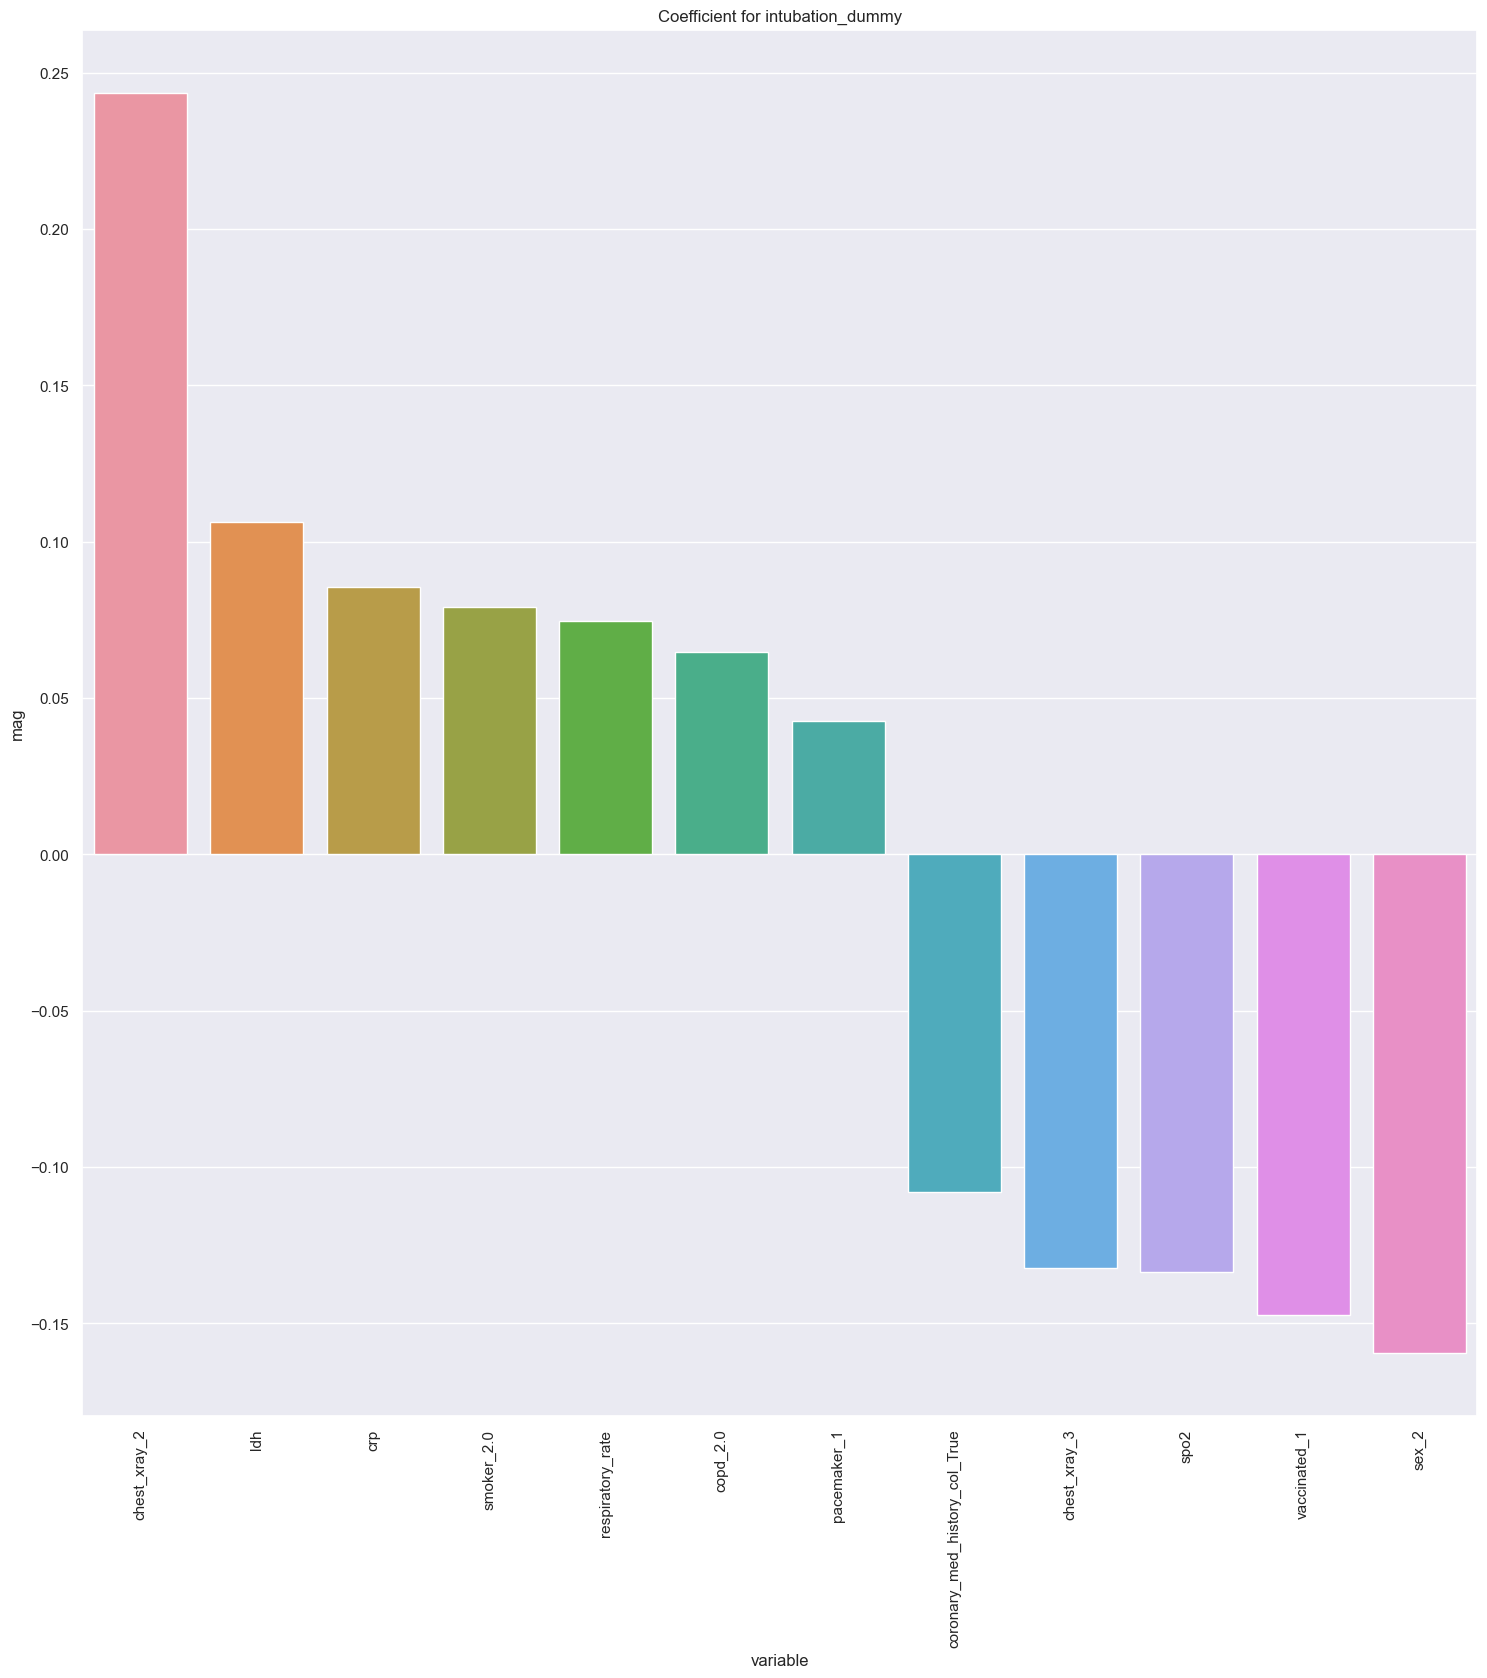

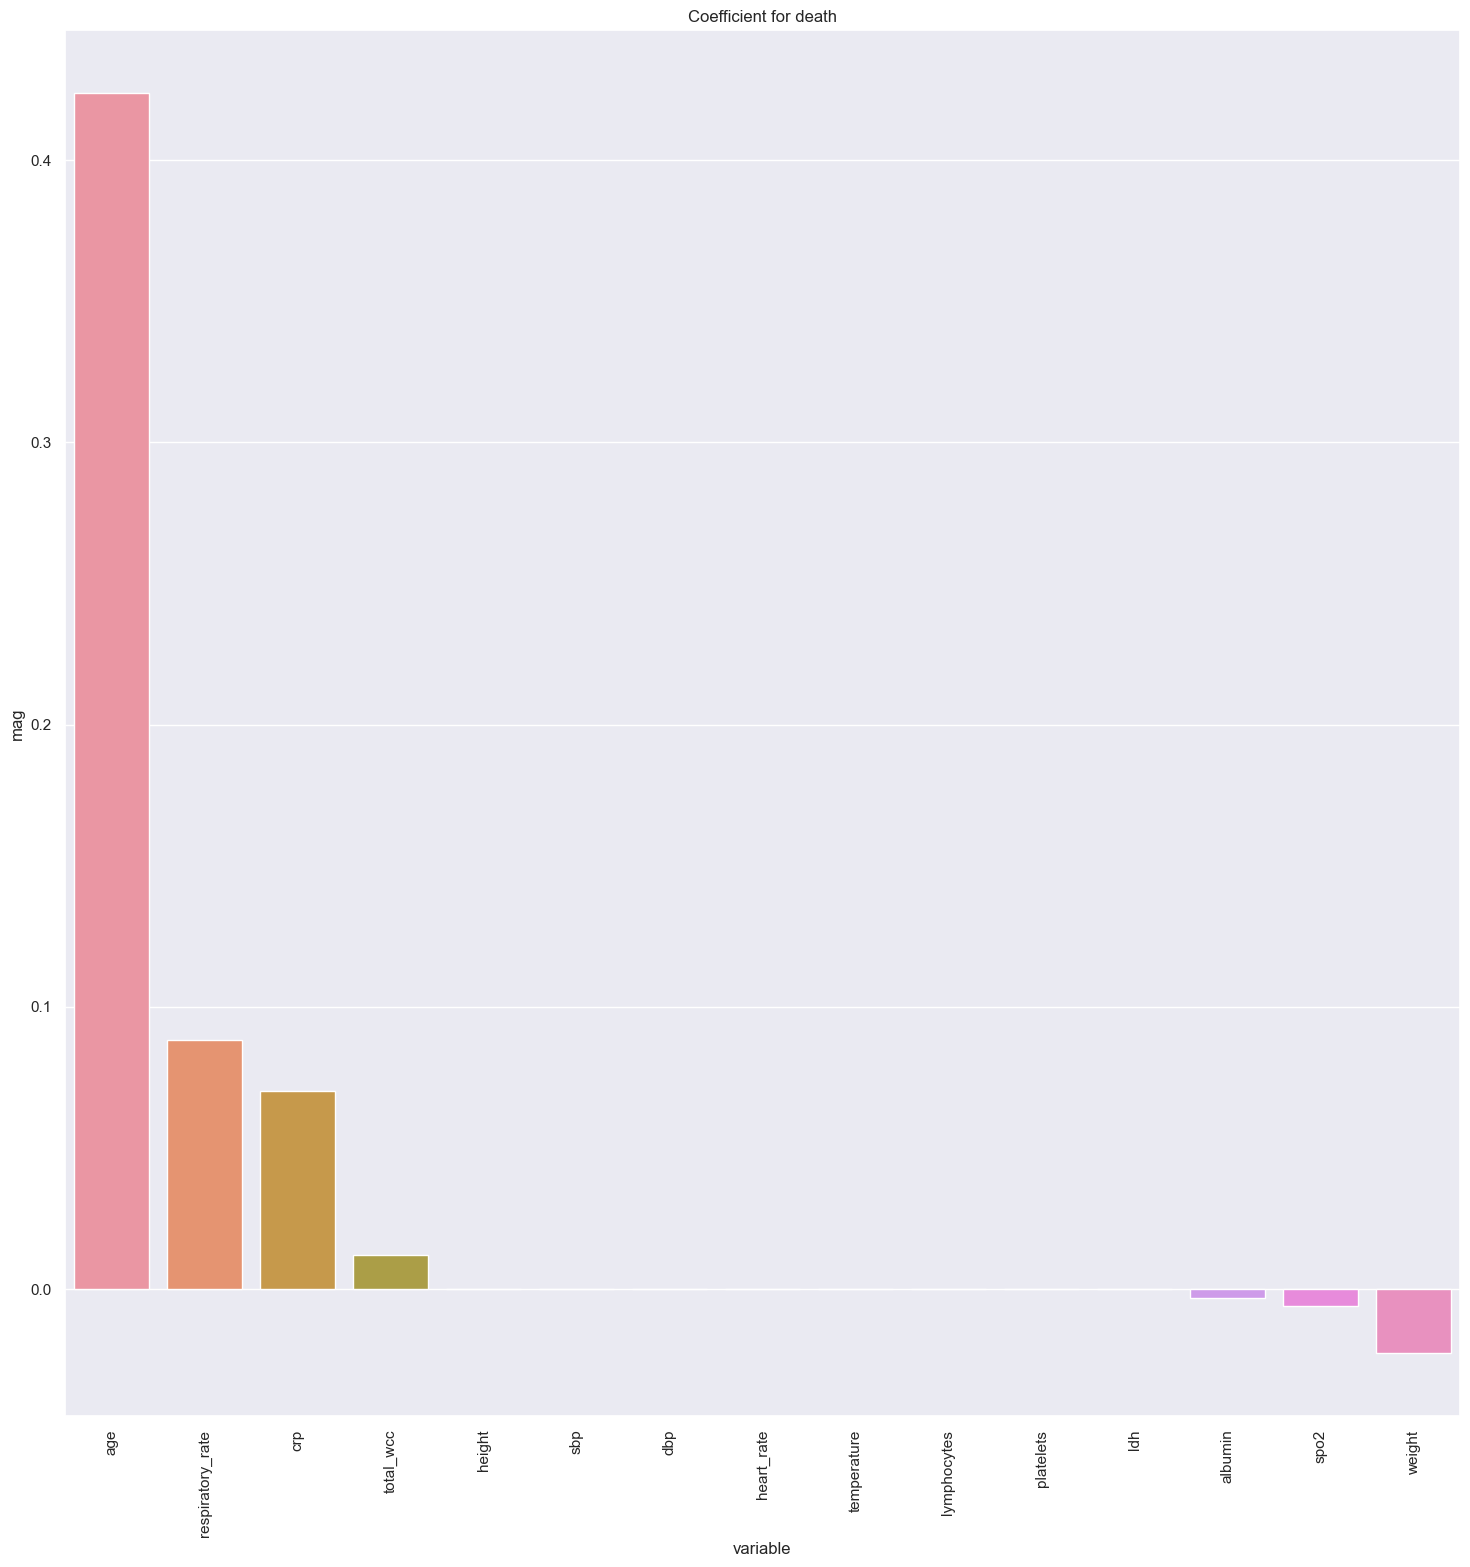

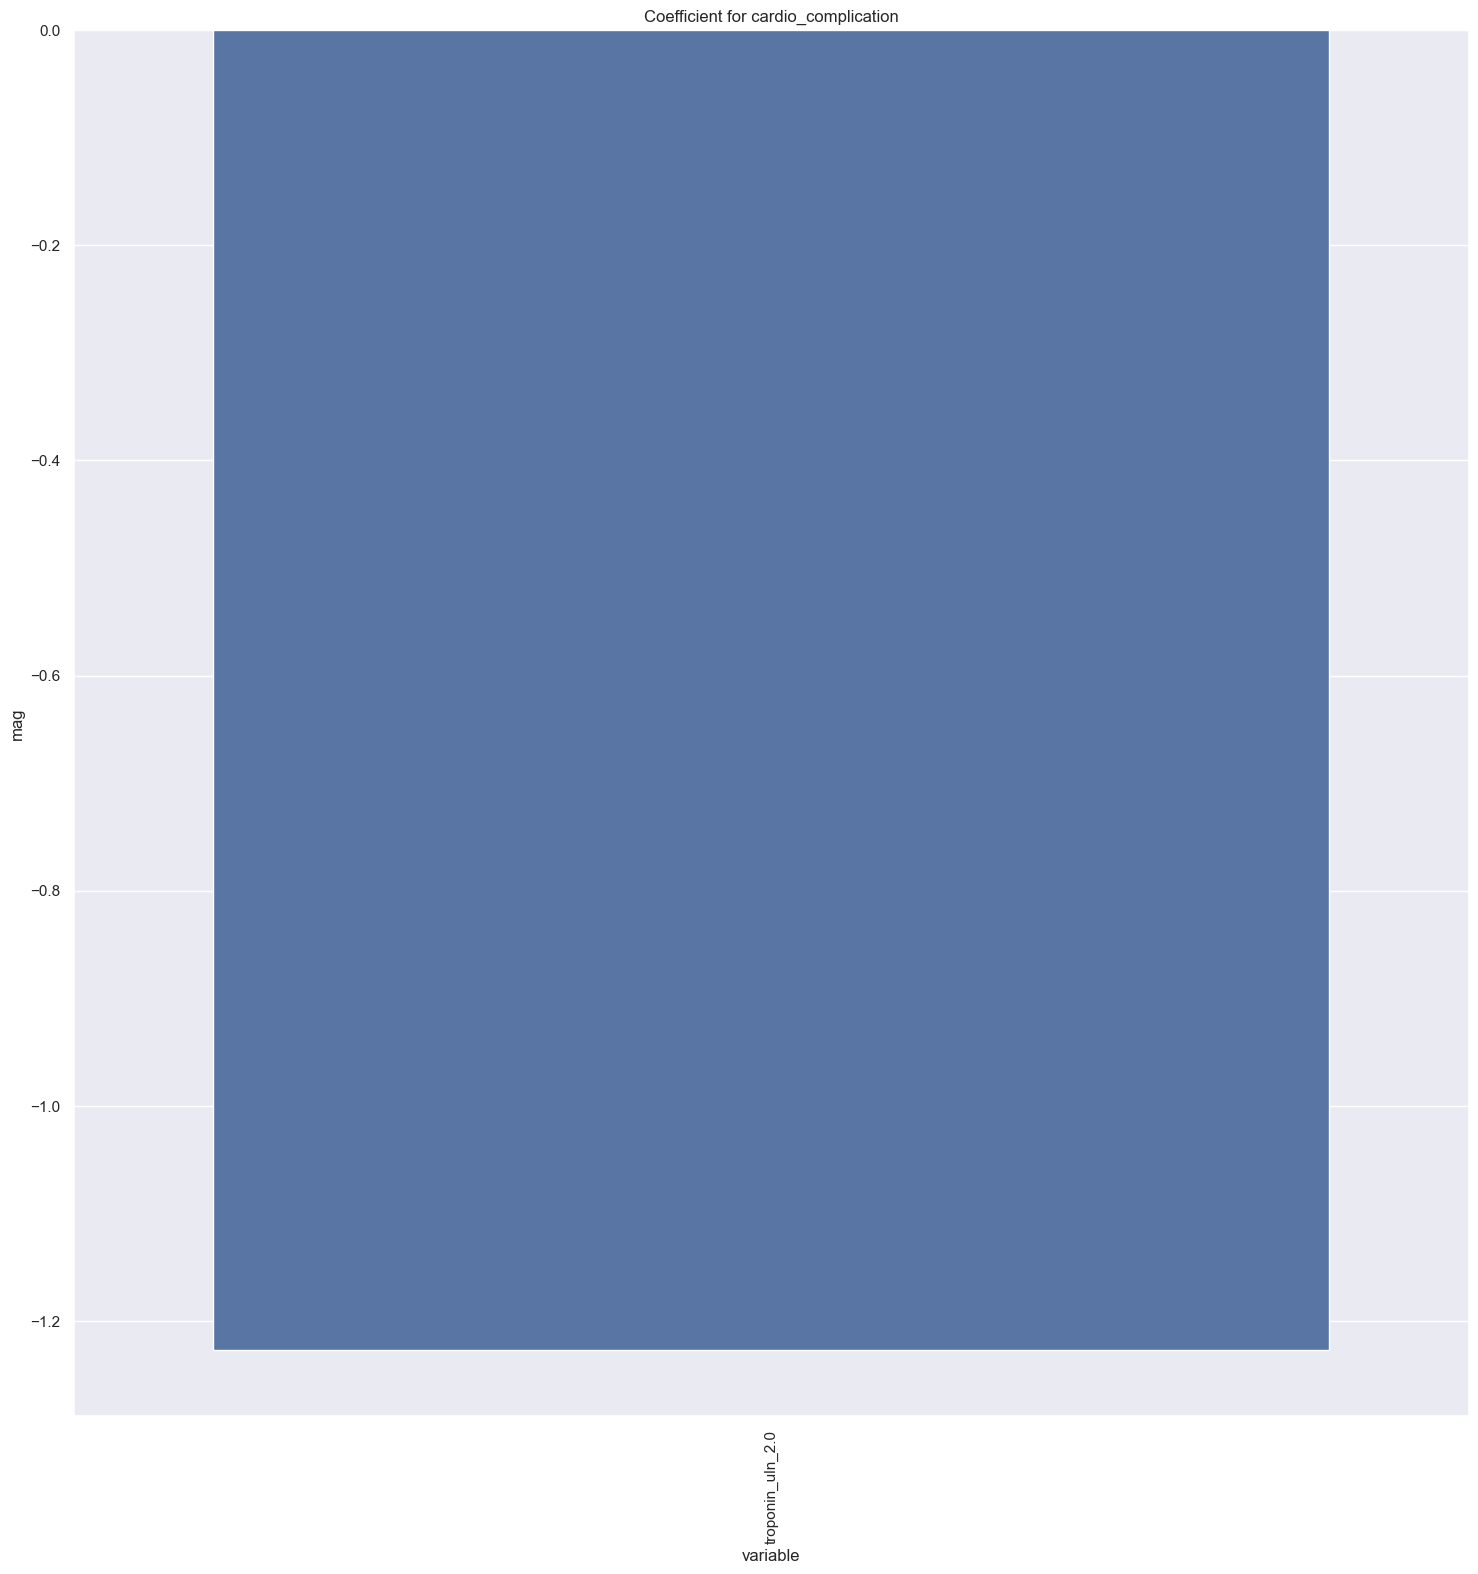

In [36]:
for p in predictor:
    loaded_pipe = joblib.load("model/" + model_name + "_"+p+".pickle")
    feature_select = loaded_pipe.named_steps["feature_select"].get_support()
    coefs = loaded_pipe.named_steps["logistic"].coef_
    coef_df = pd.DataFrame(data = {'variable' : X_train.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.savefig("figure/" + model_name + "_" +p+".png",bbox_inches="tight")
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(loaded_pipe,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [44]:
loaded_pipe.named_steps["feature_select"].get_params()['estimator'].get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.1,
 'max_iter': 5000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'elasticnet',
 'random_state': 108,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [45]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    feature_select = loaded_pipe.named_steps["feature_select"].get_support()
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ("feature_select",
         SelectFromModel(
             LogisticRegression(**loaded_pipe.named_steps["feature_select"].get_params()['estimator'].get_params()),max_features=15)),
        ("logistic",LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params()))])
    
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

In [46]:
score_df

,model,test_accuracy,outcome,fit_time,score_time,test_precision,test_recall,test_f1,test_roc_auc
0,baseline_median_impute,0.911737,intubation_dummy,0.083016,0.018803,0.590043,0.158333,0.240184,0.763806
1,baseline_median_impute,0.894949,death,0.023505,0.014603,0.520684,0.262299,0.345959,0.859799
2,baseline_median_impute,0.945295,cardio_complication,0.025005,0.018904,0.200000,0.026667,0.047059,0.582850
3,logistic_feature_selection_median,0.911737,intubation_dummy,0.028205,0.013003,0.590043,0.158333,0.240184,0.763806
4,logistic_feature_selection_median,0.894949,death,0.020904,0.012802,0.520684,0.262299,0.345959,0.859799
...,...,...,...,...,...,...,...,...,...
56,gradboost_median_impute_feature,0.946755,cardio_complication,1.992165,0.019204,0.200000,0.013333,0.025000,0.590051
57,elasticnet_feature_selection_median_impute_ove...,0.681999,intubation_dummy,0.241254,0.009803,0.180641,0.741667,0.290375,0.777734
58,elasticnet_feature_selection_median_impute_ove...,0.742524,intubation_dummy,0.270911,0.010103,0.202755,0.658333,0.309829,0.770424
59,elasticnet_feature_selection_median_impute_ove...,0.768064,death,0.258039,0.009811,0.282000,0.722759,0.404549,0.833235


In [47]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)

## decision tree

In [216]:
from sklearn.tree import DecisionTreeClassifier

In [217]:
score_df = pd.read_csv(cv_result_filename ,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [218]:
model_name = "decision_feature_selection_median_impute_oversample"

lr_model_name = "l1_feature_selection_median_impute_oversample"

In [219]:


param_grid = {
    "tree__criterion": ['gini', 'entropy'],
    #'tree__min_samples_split':np.linspace(0.02,0.3,num=5) 
    'tree__max_depth': np.arange(3,20,3) 
}


In [220]:
for p in predictor:

    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    
    loaded_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    pipeline = Pipeline(steps=[
     ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
     ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
    ("scaler", StandardScaler()), 
    ('feature_select', SelectFromModel(LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params())
                                          ,max_features=15)),
    ("tree", DecisionTreeClassifier(random_state=random_seed))])
    
    
    grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5,scoring=scoring_method)

    grid.fit(X_train, y_train)
    
    joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(grid.best_estimator_,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)
    

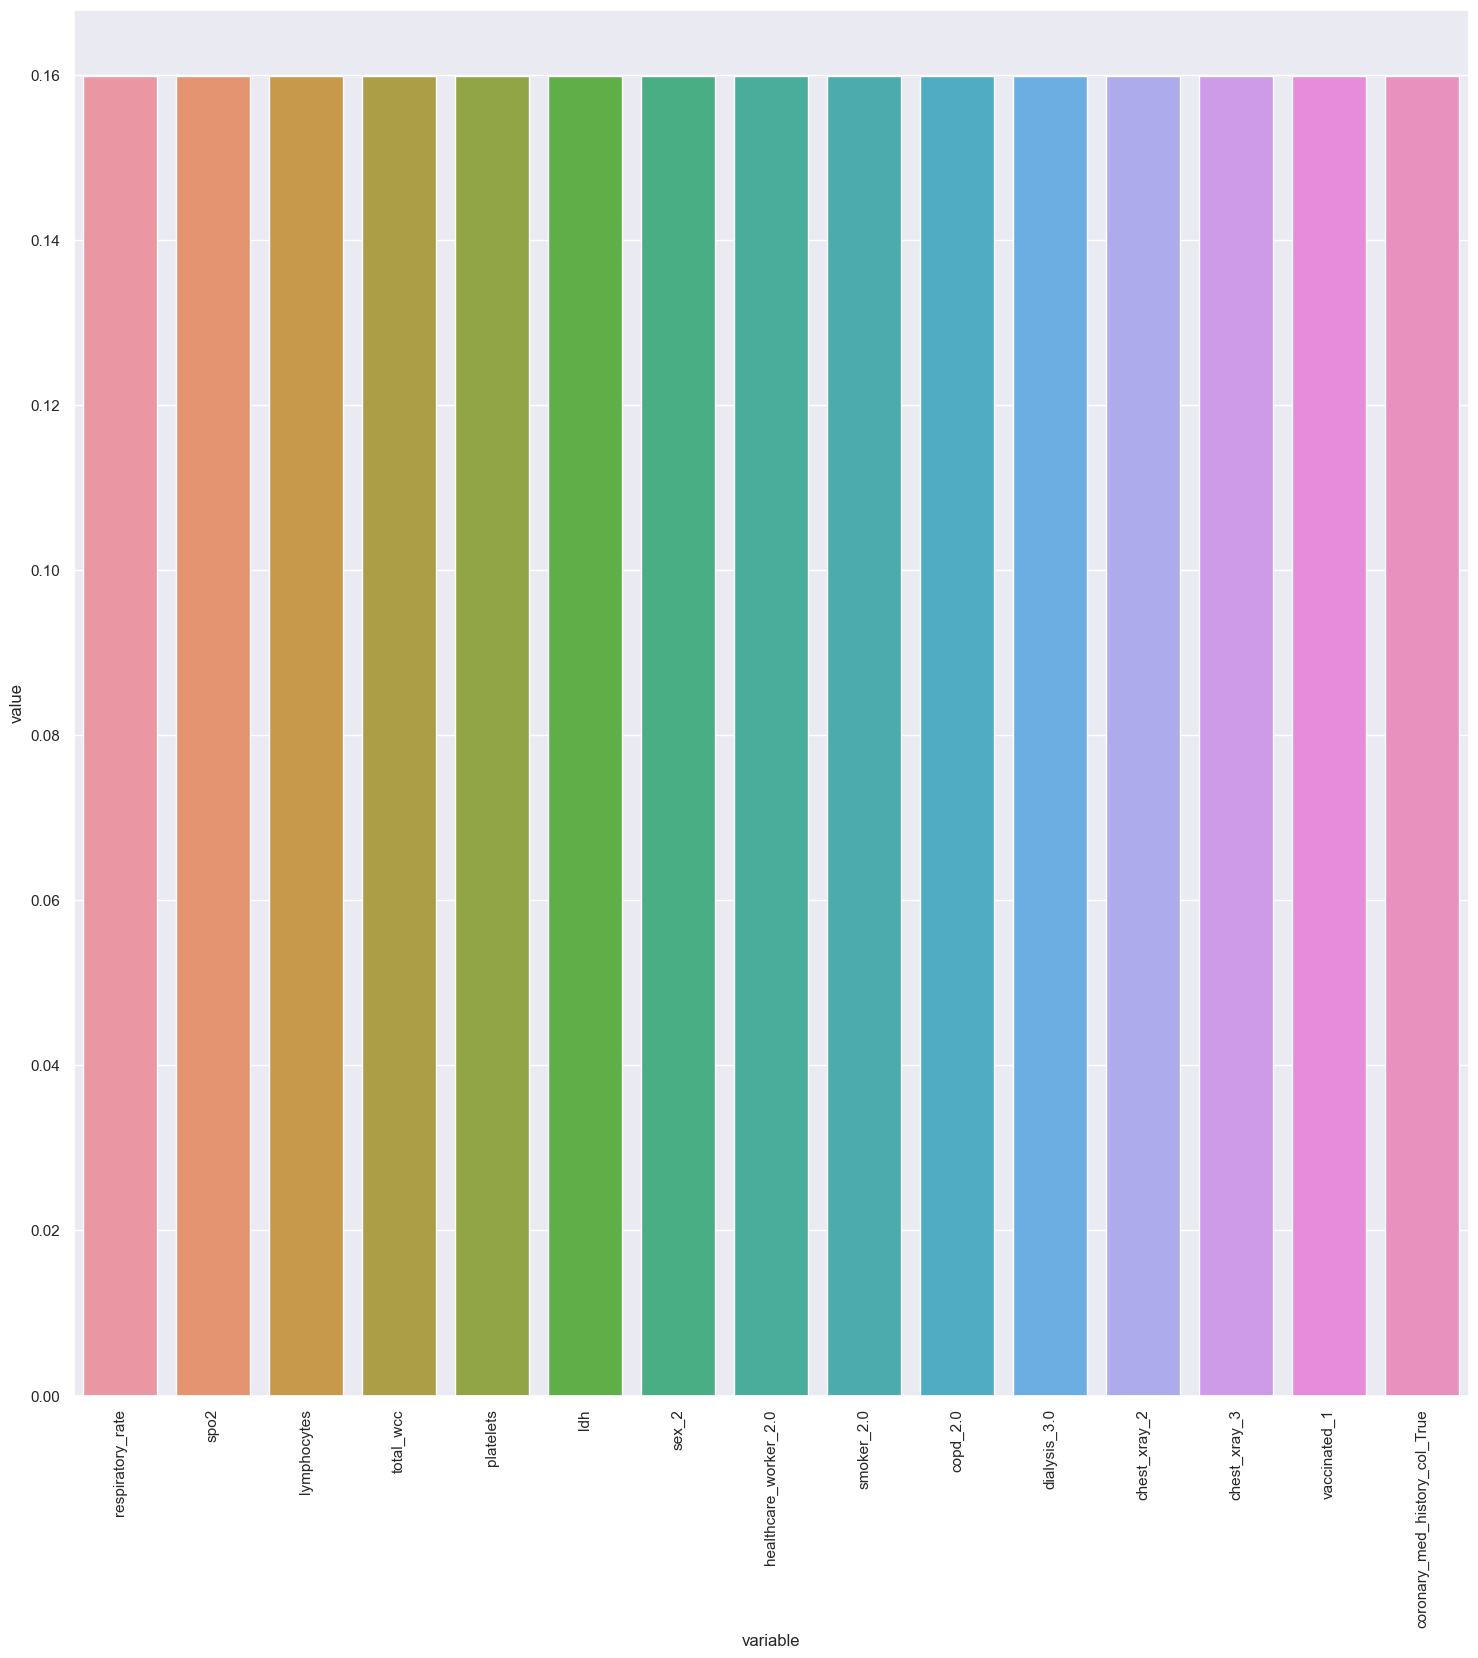

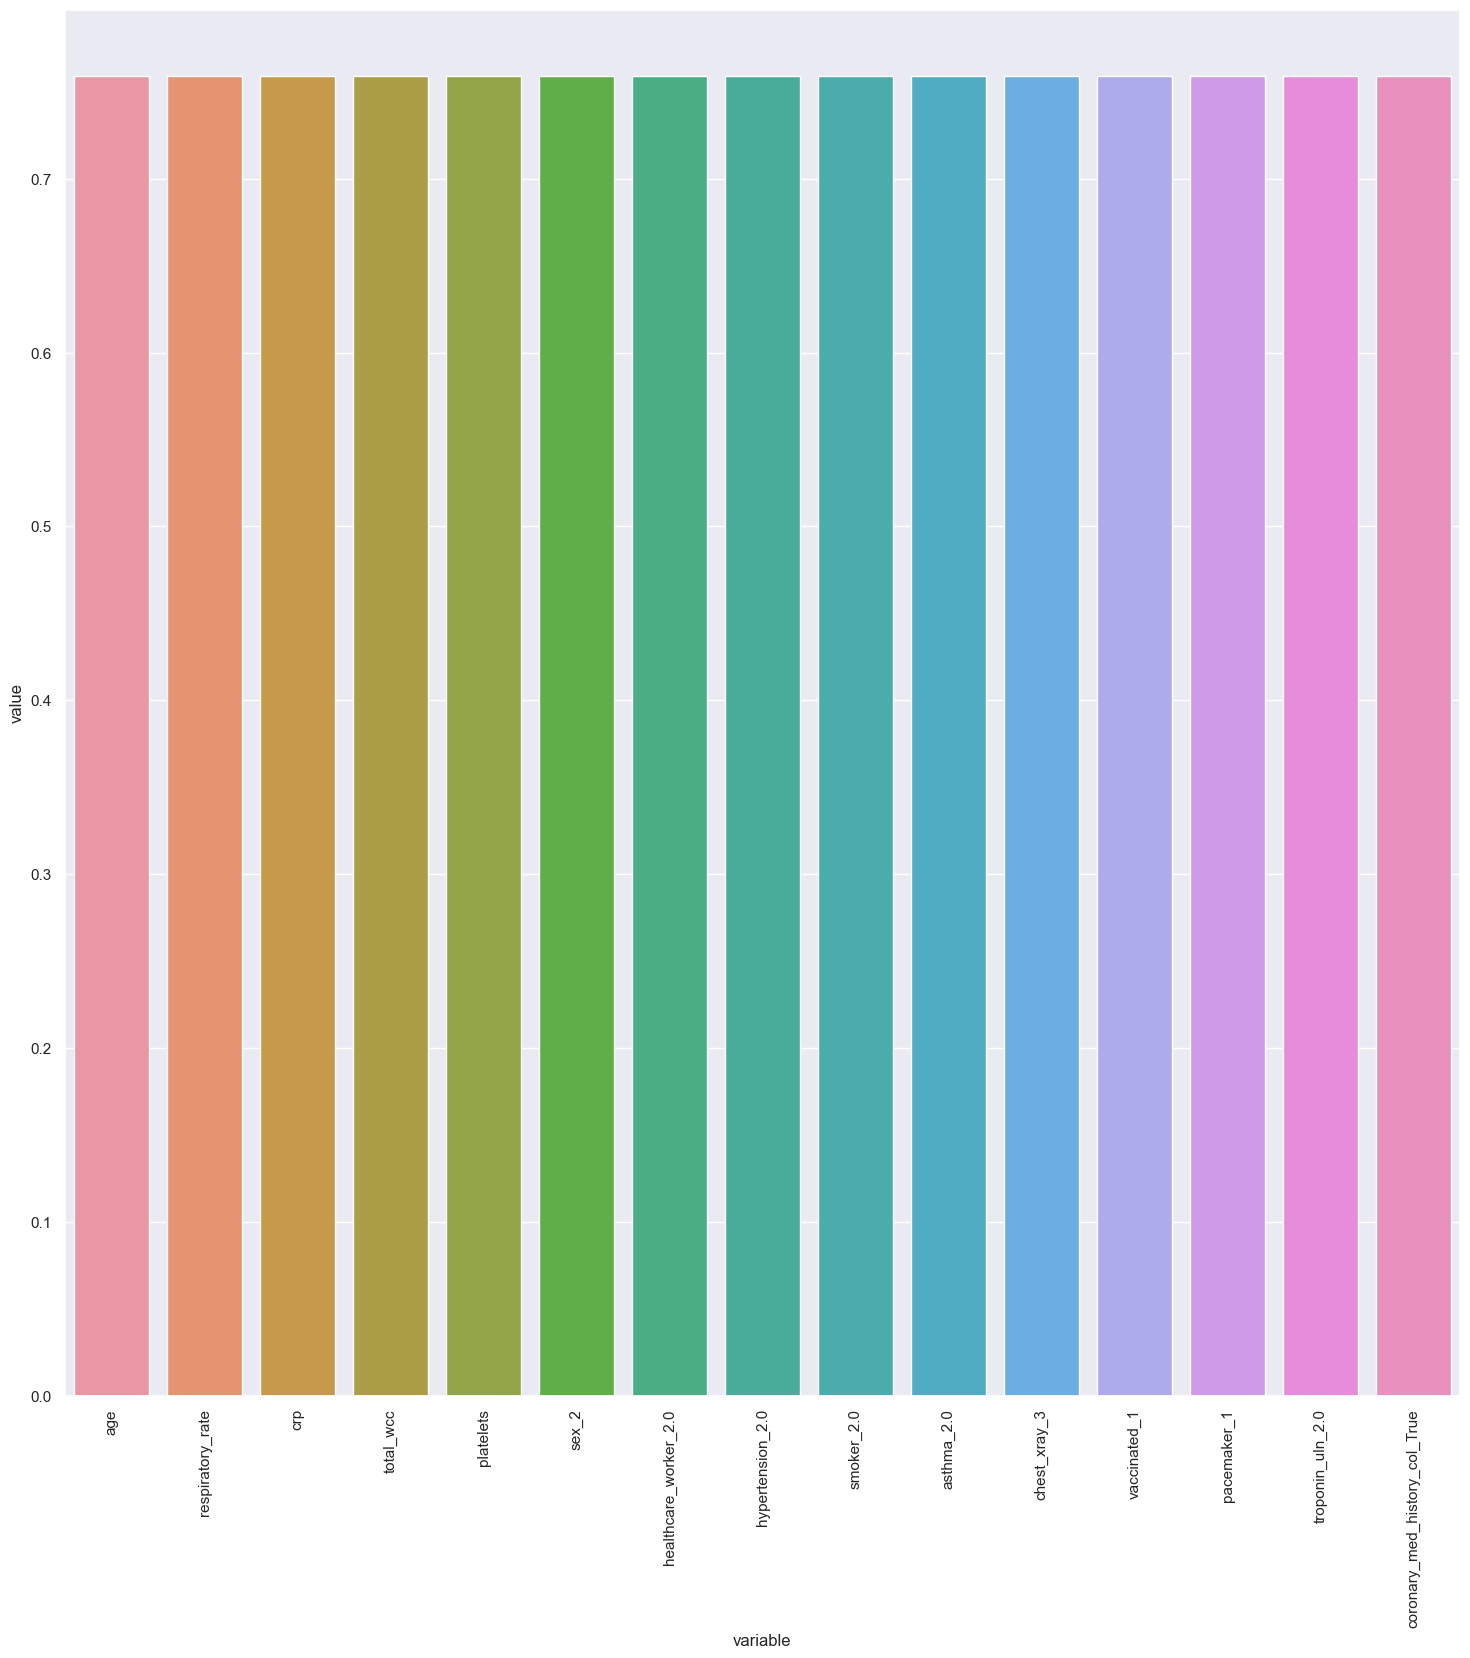

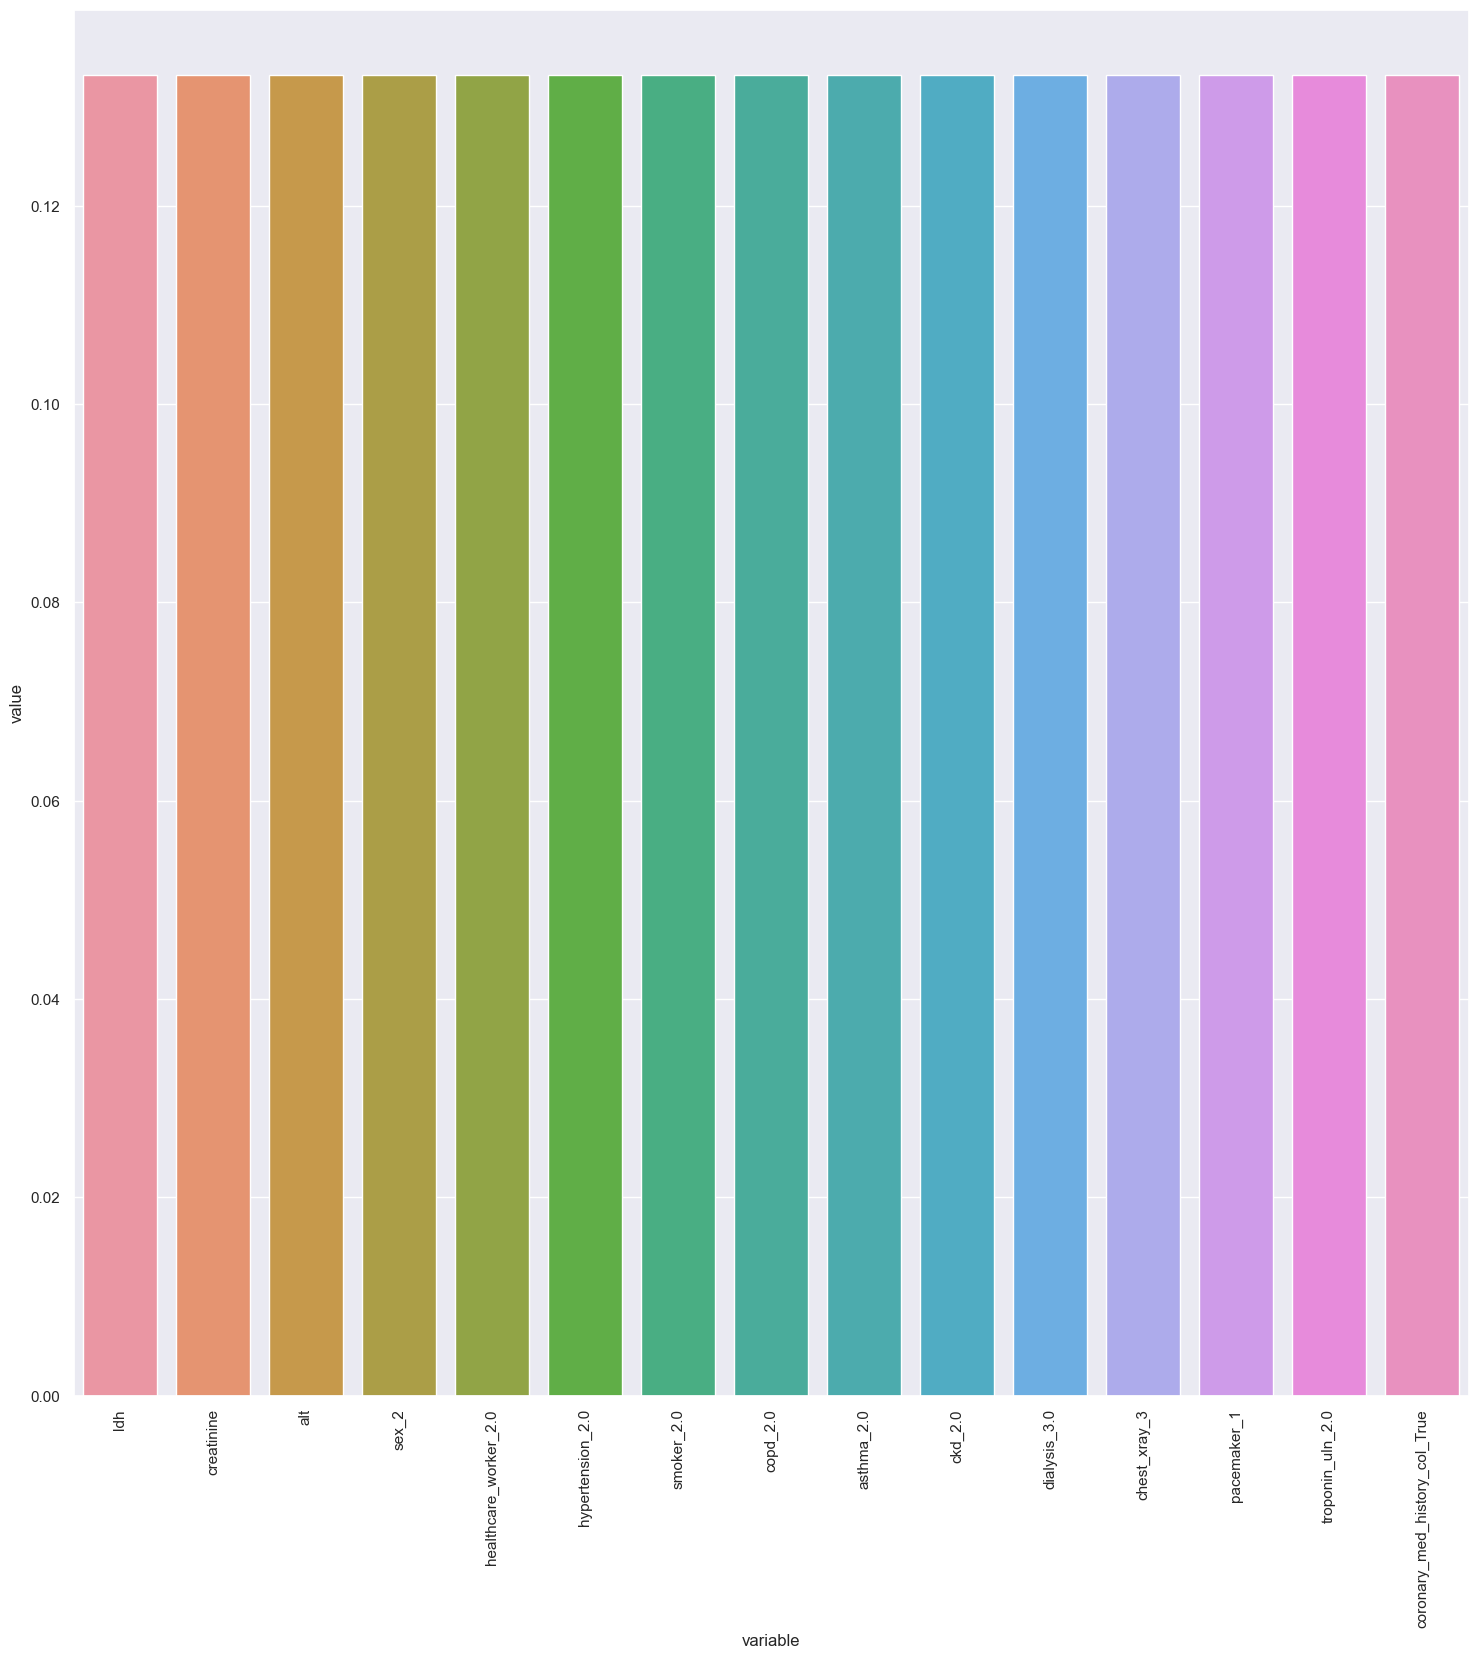

In [221]:
for p in predictor:
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    feature_select =  loaded_pipe.named_steps["feature_select"].get_support()
    coefs = loaded_pipe.named_steps["tree"].feature_importances_
    
    coef_df = pd.DataFrame(data = {'variable' : X_train.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('value', ascending=False)
    plt.figure(figsize=(18, 18))
    sns.barplot(
        data=coef_df, x="variable", y="value")
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.savefig("figure/" + model_name + "_coeff_" + p +".png",bbox_inches="tight")

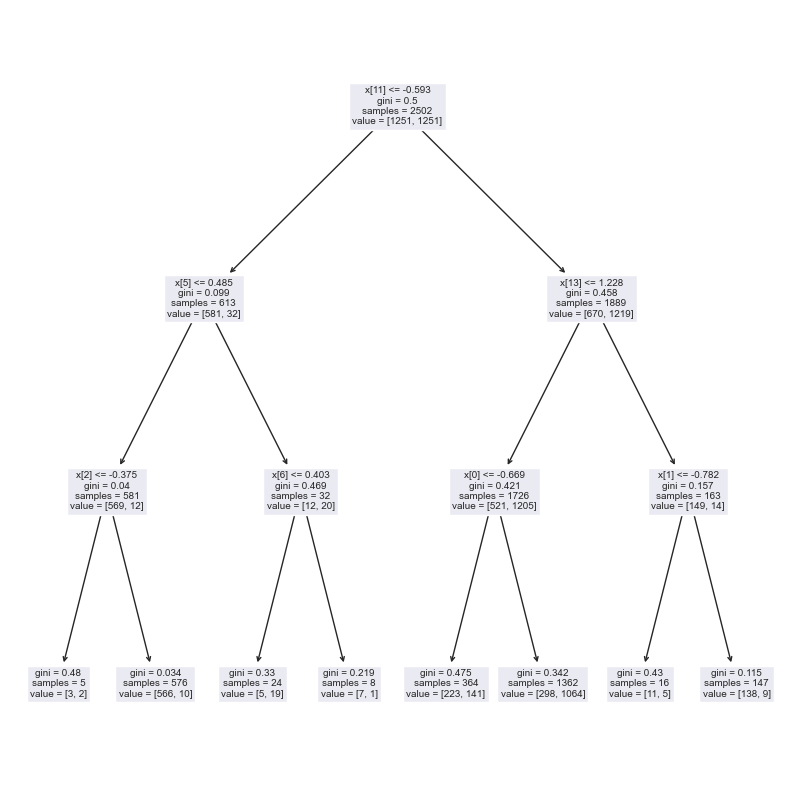

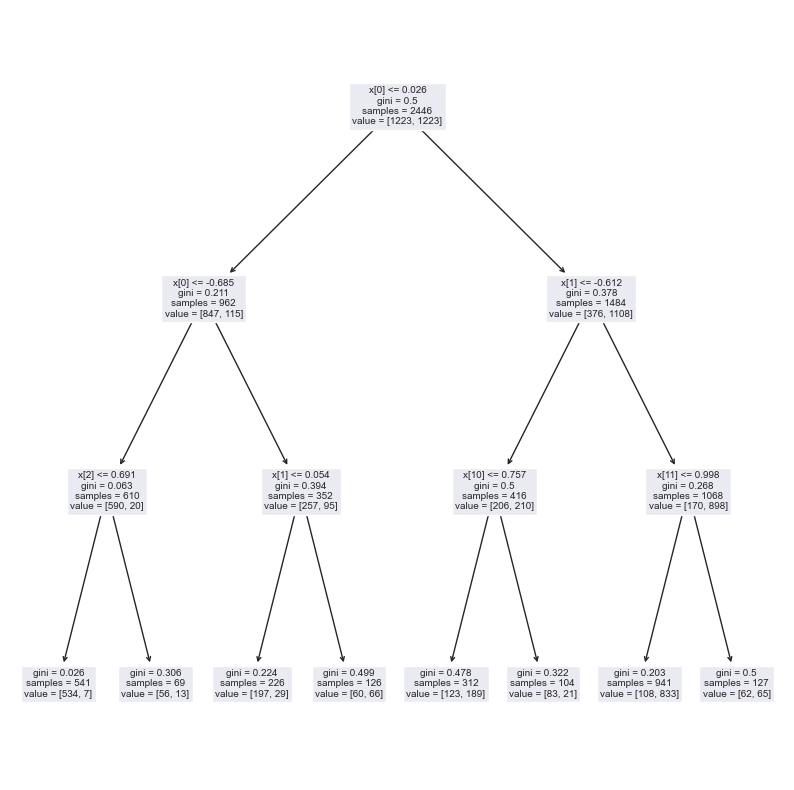

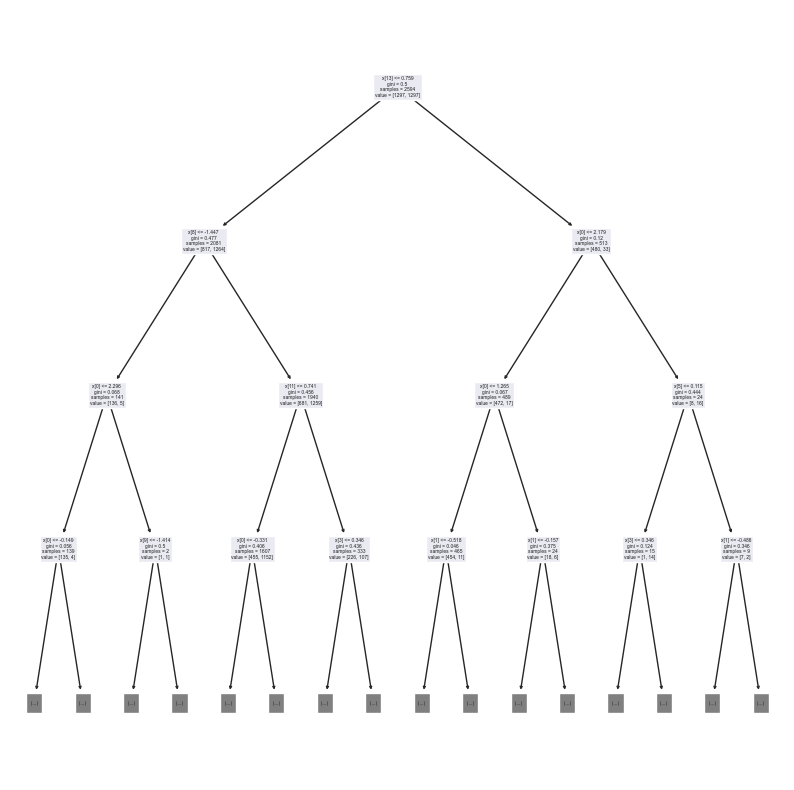

In [222]:
from sklearn.tree import plot_tree
for p in predictor:
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    plt.figure(figsize=(10, 10))
    plot_tree(loaded_pipe.named_steps["tree"],max_depth =3)
    plt.savefig("figure/" + model_name + "_tree_" + p +".png",bbox_inches="tight")

In [223]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    #feature_select = loaded_pipe.named_steps["feature_select"].support_
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    loaded_lr_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ('feature_selection', SelectFromModel(LogisticRegression(**loaded_lr_pipe.named_steps["logistic"].get_params()),
                                              max_features=15)),
        ("tree",DecisionTreeClassifier(**loaded_pipe.named_steps["tree"].get_params()))])
    
    
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)
    

In [224]:
test_df

,model,accuracy,precision,recall,f1_score,auc,outcome
0,baseline_median_impute,0.909621,0.333333,0.107143,0.162162,0.544048,intubation_dummy
1,baseline_median_impute,0.883382,0.266667,0.121212,0.166667,0.542864,death
2,baseline_median_impute,0.953353,0.500000,0.062500,0.111111,0.529721,cardio_complication
3,logistic_feature_selection_median,0.915452,0.000000,0.000000,0.000000,0.498413,intubation_dummy
4,logistic_feature_selection_median,0.900875,0.000000,0.000000,0.000000,0.498387,death
5,logistic_feature_selection_median,0.950437,0.000000,0.000000,0.000000,0.498471,cardio_complication
6,logistic_feature_selection_median_oversample,0.731778,0.100000,0.285714,0.148148,0.528571,intubation_dummy
7,logistic_feature_selection_median_oversample,0.728863,0.125000,0.303030,0.176991,0.538612,death
8,logistic_feature_selection_median_oversample,0.749271,0.062500,0.312500,0.104167,0.541571,cardio_complication
9,l2_feature_selection_median_impute_oversample,0.752187,0.139241,0.392857,0.205607,0.588492,intubation_dummy


In [225]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)

## Random forest

In [244]:
score_df = pd.read_csv(cv_result_filename ,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [245]:
from sklearn.ensemble import RandomForestClassifier

#pipeline = Pipeline(steps=[
#     ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
#    ("scaler", StandardScaler()), 
#    ("tree", RandomForestClassifier(random_state=random_seed,max_features = 'sqrt',n_estimators=100))])



param_grid = {
    "tree__criterion": ['gini', 'entropy'],
    #'tree__min_samples_split':np.linspace(0.02,0.3,num=5) 
    'tree__max_depth': np.arange(1,11,2) 
}


In [246]:
model_name = "rf_selection_median_impute_final"
lr_model_name = "l1_feature_selection_median_impute"

In [247]:
for p in predictor:

    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    
    loaded_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    pipeline = Pipeline(steps=[
     ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
     #("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
    ("scaler", StandardScaler()), 
    ('feature_selection', SelectFromModel(LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params())
                                          ,max_features=15)),
    ("tree",  RandomForestClassifier(
                 random_state=random_seed,max_features = 'sqrt',n_estimators=10))])
    
    
    grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5,scoring=scoring_method)

    grid.fit(X_train, y_train)
    
    joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(grid.best_estimator_,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)
    

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [248]:
for p in predictor:
    
    
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    #feature_select = loaded_pipe.named_steps["feature_select"].support_
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    loaded_lr_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        #("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ('feature_selection', SelectFromModel(LogisticRegression(**loaded_lr_pipe.named_steps["logistic"].get_params()),
                                              max_features=15)),
        ("tree",RandomForestClassifier(**loaded_pipe.named_steps["tree"].get_params()))])
    
    
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)
    

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

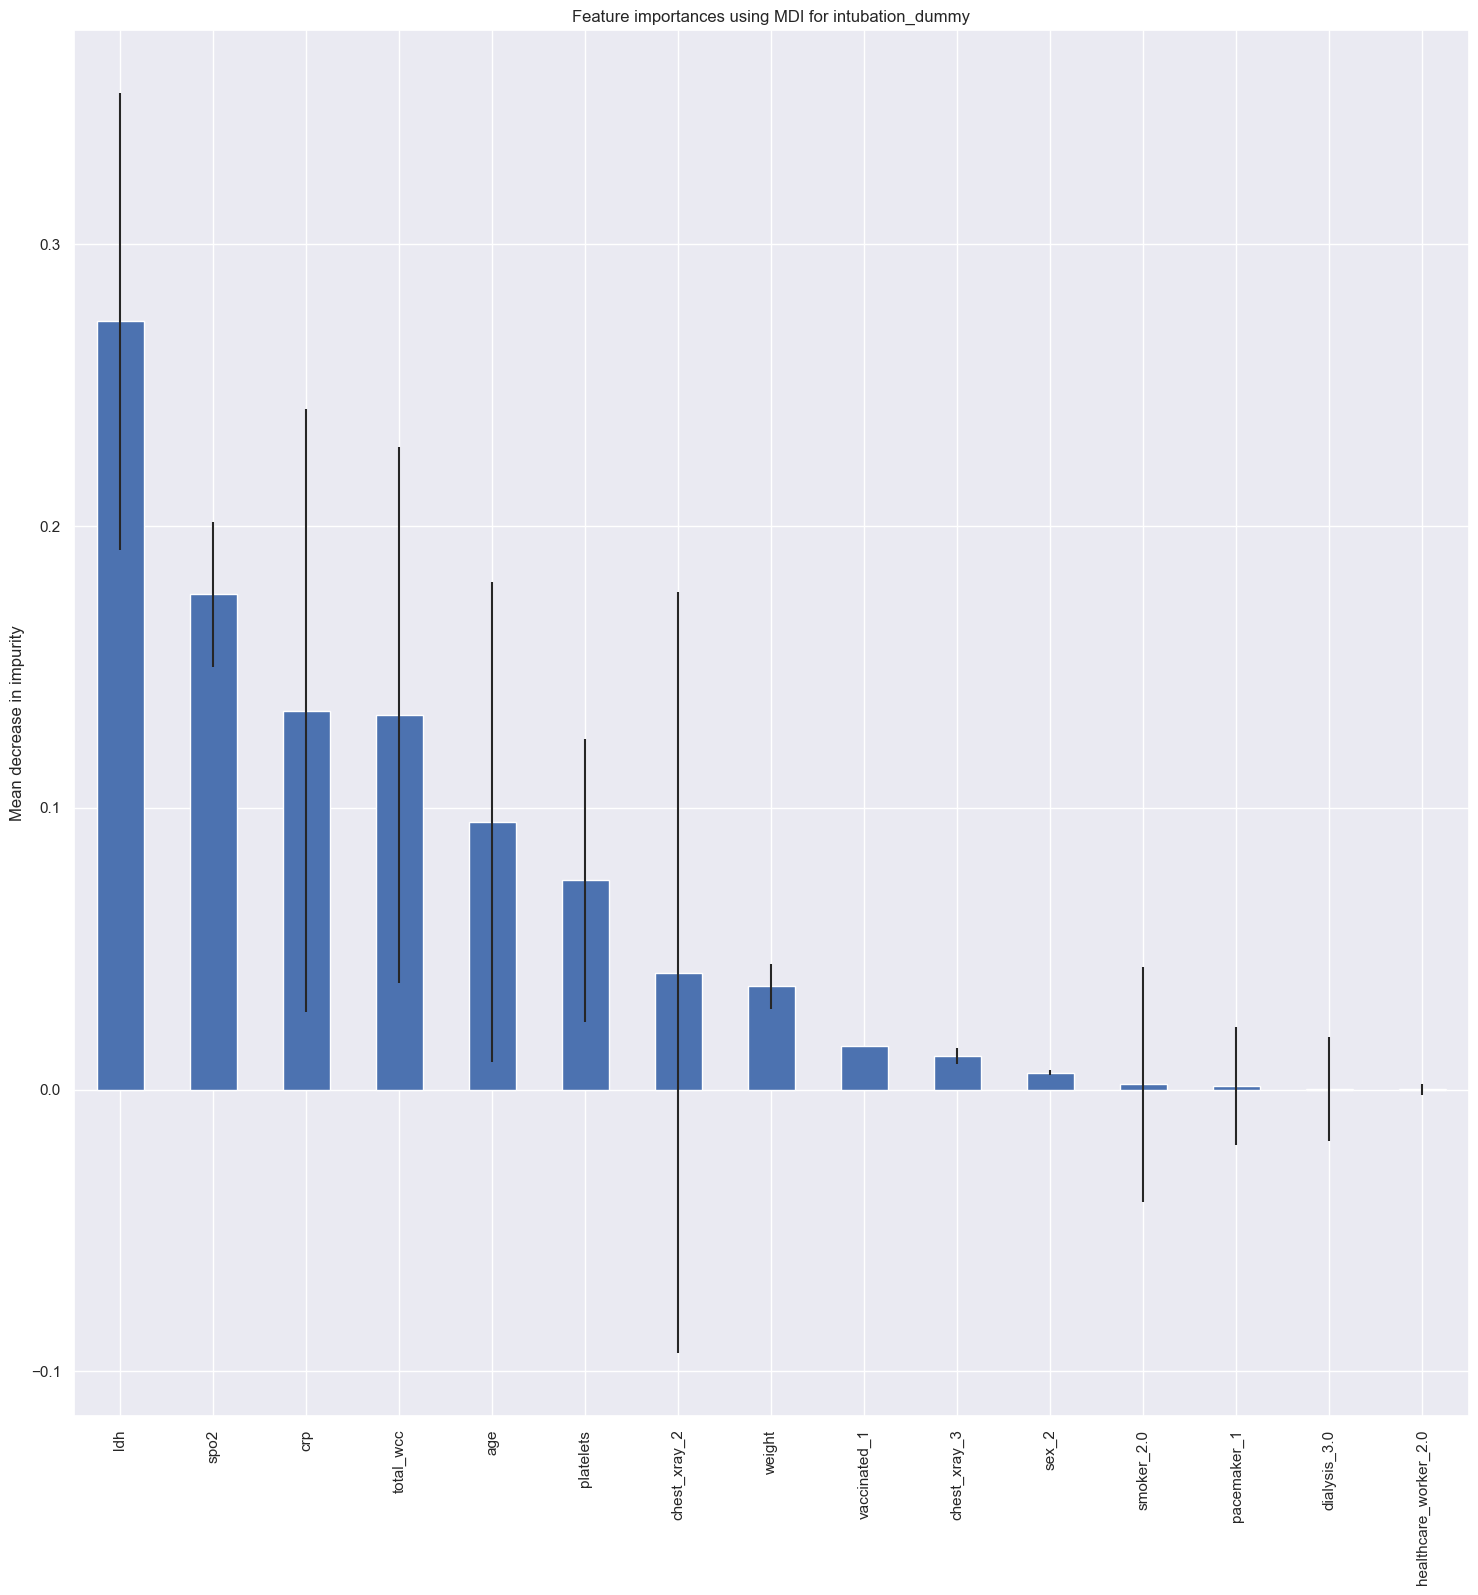

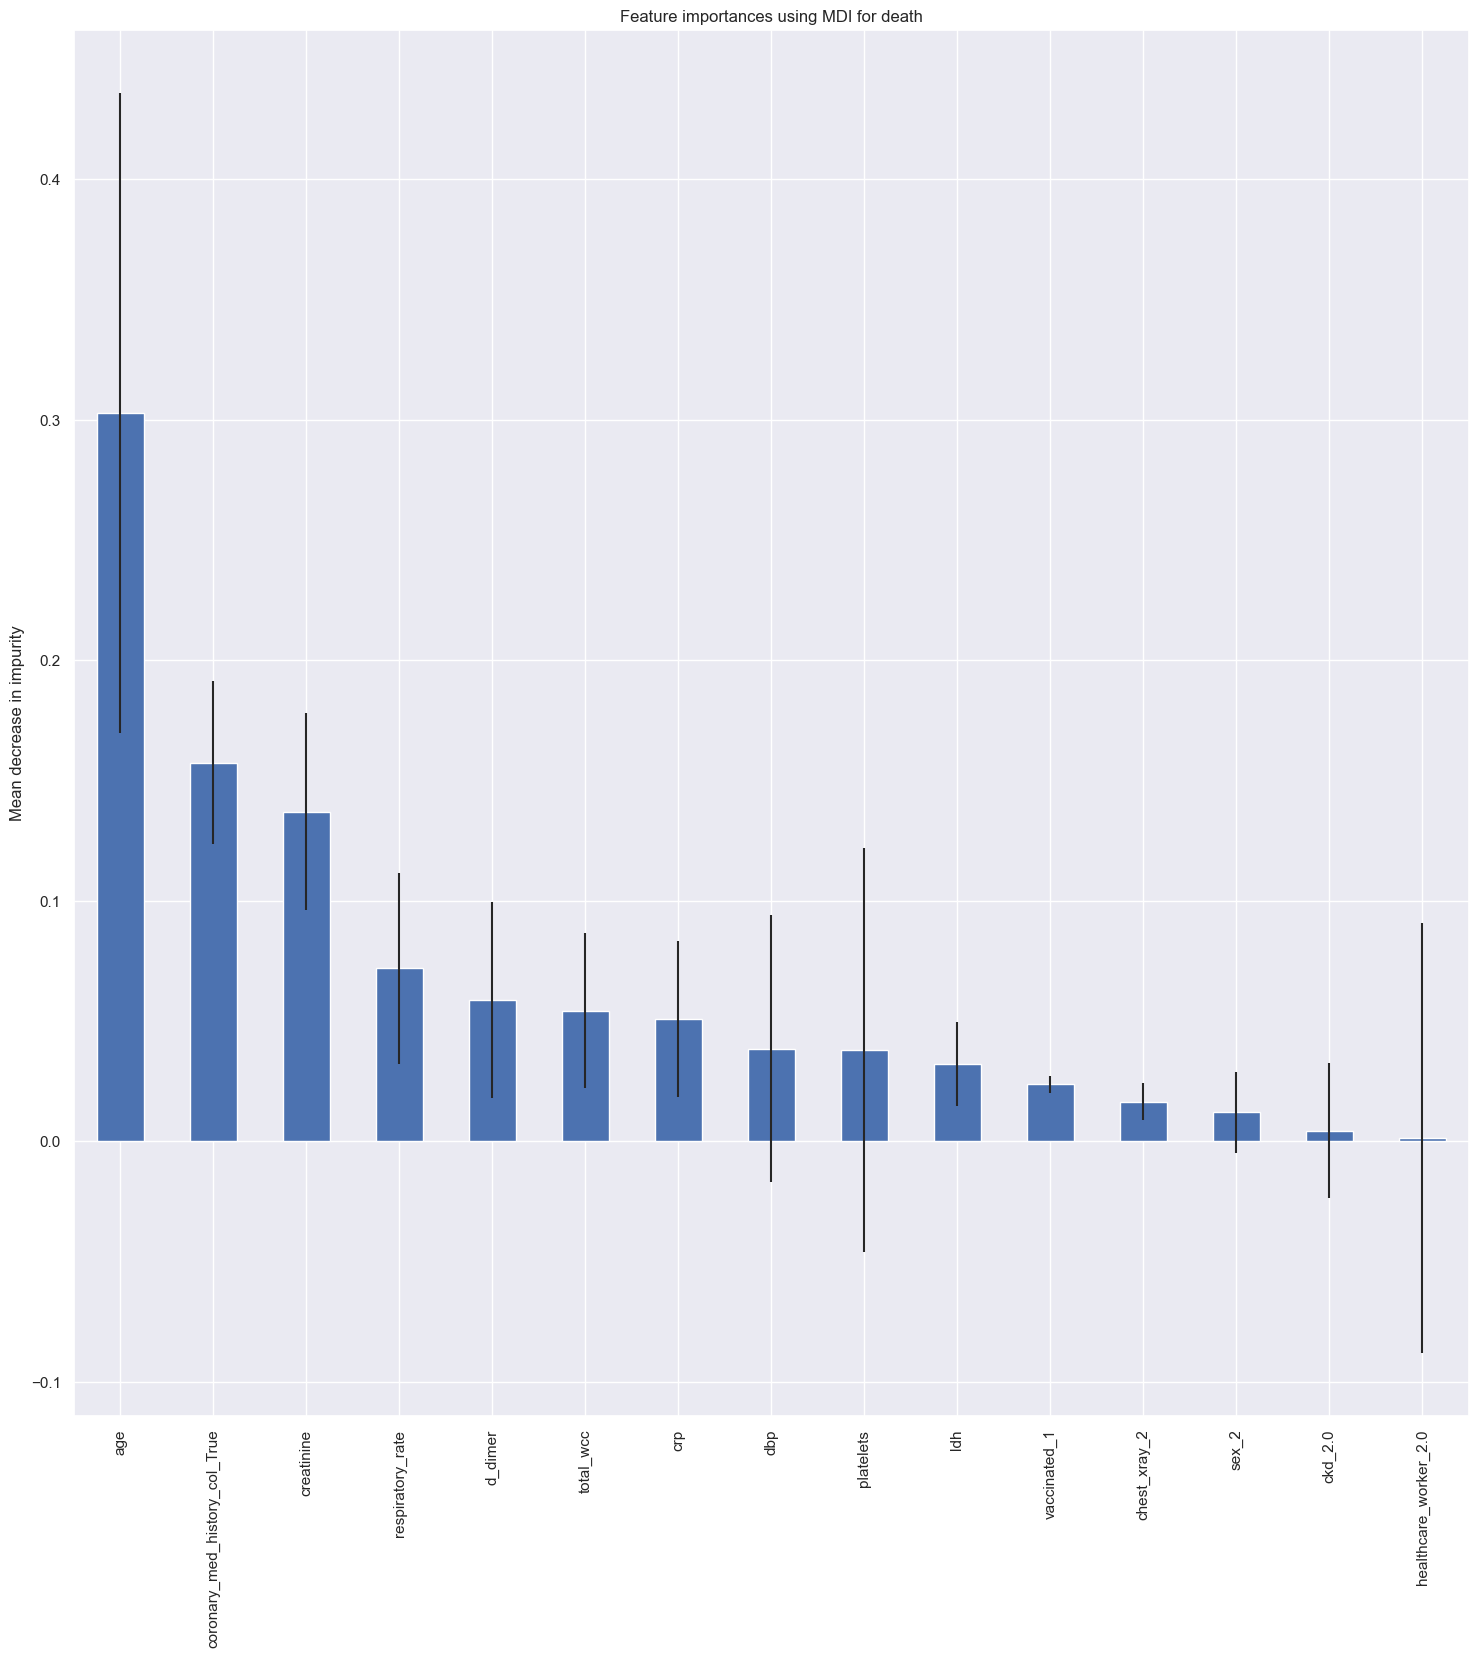

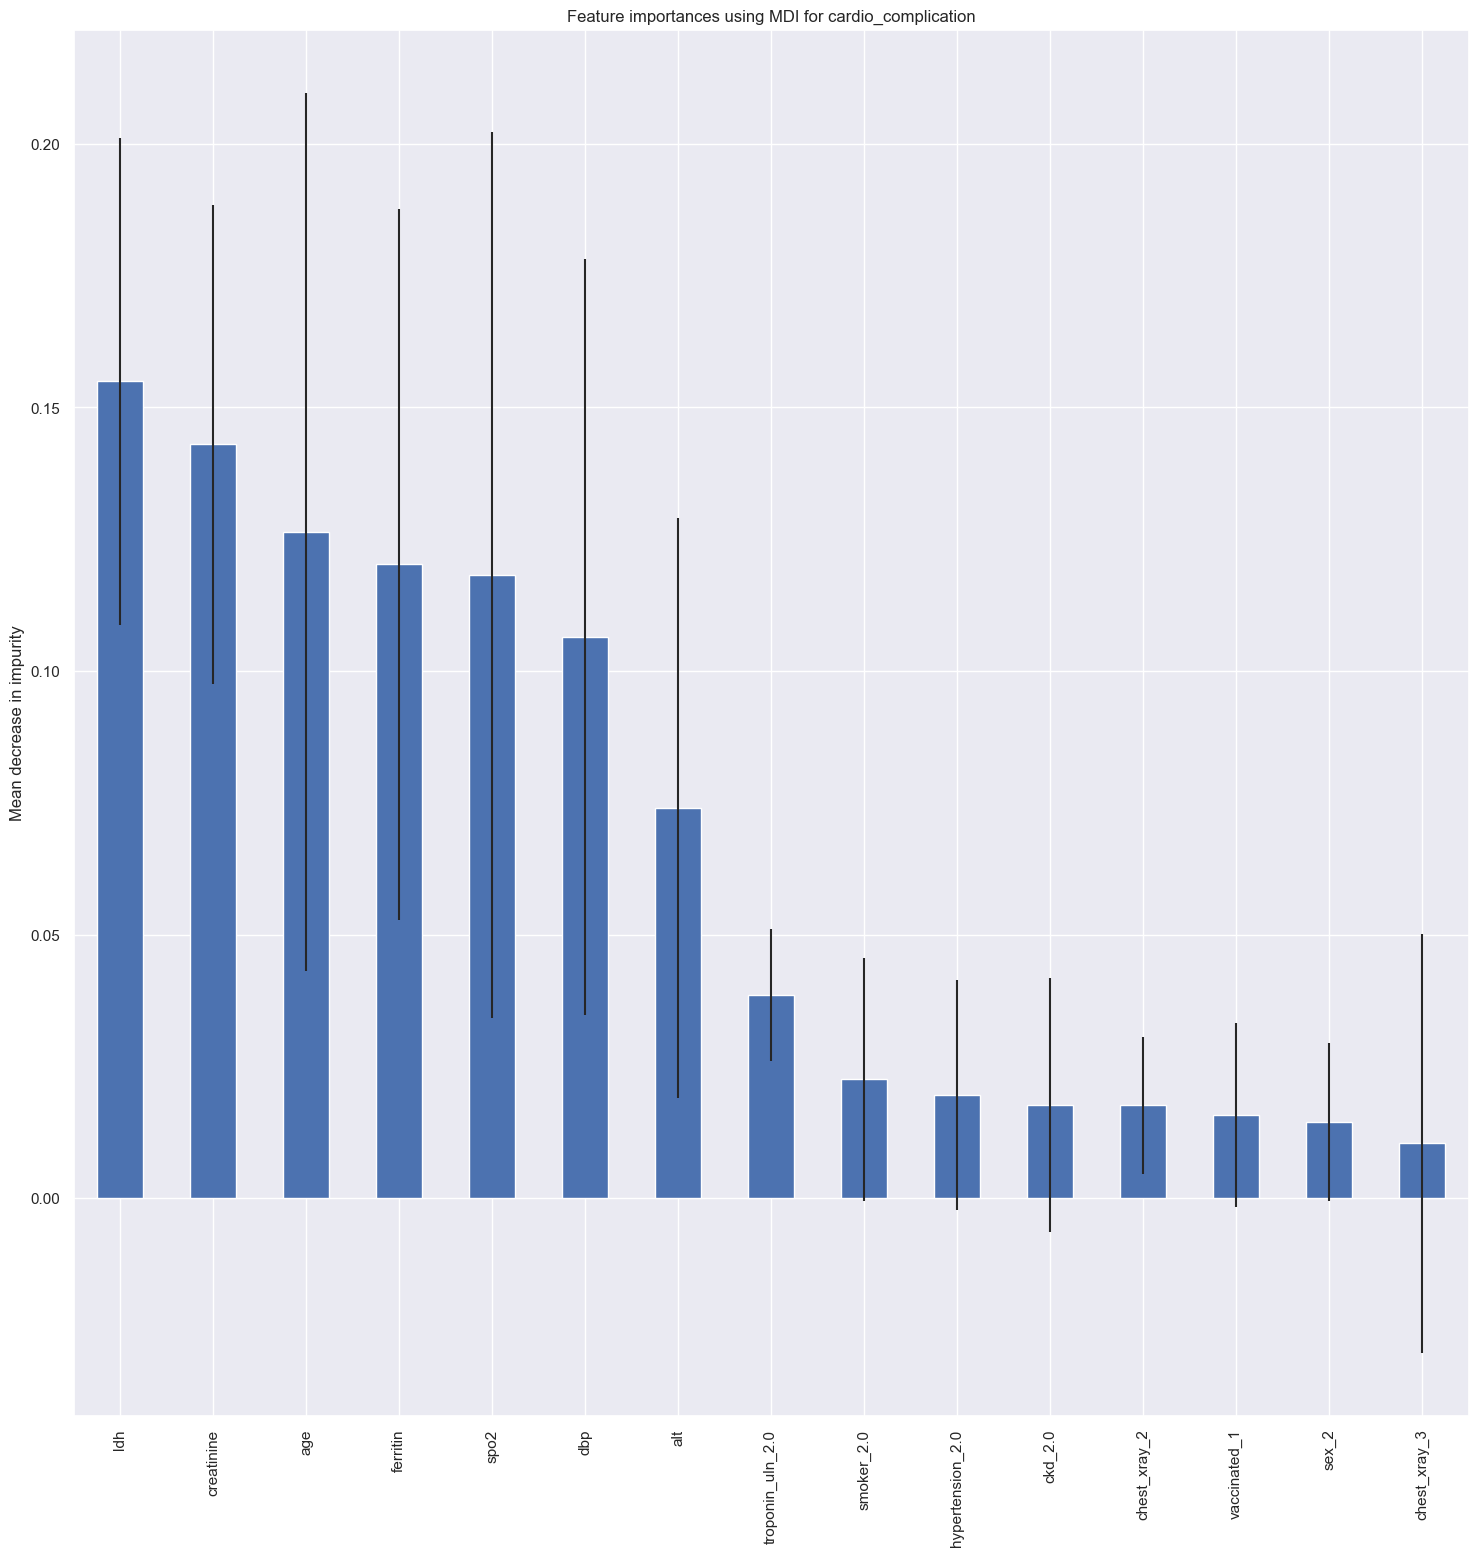

In [249]:
for p in predictor:
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    feature_select = loaded_pipe.named_steps["feature_selection"].get_support()

    importances = loaded_pipe.named_steps["tree"].feature_importances_
    std = np.std([tree.feature_importances_ for tree in loaded_pipe.named_steps["tree"].estimators_], axis=0)


    forest_importances = pd.Series(importances, index= X_train.columns[feature_select])
    forest_importances = forest_importances.sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(18, 18))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI for " + p)
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout
    
    plt.savefig("figure/" + model_name + "_coeff_" + p +".png",bbox_inches="tight")

In [250]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)

In [251]:
score_df

,model,test_accuracy,outcome,fit_time,score_time,test_precision,test_recall,test_f1,test_roc_auc
0,baseline_median_impute,0.911737,intubation_dummy,0.083016,0.018803,0.590043,0.158333,0.240184,0.763806
1,baseline_median_impute,0.894949,death,0.023505,0.014603,0.520684,0.262299,0.345959,0.859799
2,baseline_median_impute,0.945295,cardio_complication,0.025005,0.018904,0.200000,0.026667,0.047059,0.582850
3,logistic_feature_selection_median,0.911737,intubation_dummy,0.028205,0.013003,0.590043,0.158333,0.240184,0.763806
4,logistic_feature_selection_median,0.894949,death,0.020904,0.012802,0.520684,0.262299,0.345959,0.859799
5,logistic_feature_selection_median,0.945295,cardio_complication,0.024005,0.013402,0.200000,0.026667,0.047059,0.582850
6,logistic_feature_selection_median_oversample,0.725733,intubation_dummy,0.487793,0.013902,0.178647,0.591667,0.273742,0.722079
7,logistic_feature_selection_median_oversample,0.778997,death,0.532502,0.014303,0.291679,0.722759,0.415047,0.832691
8,logistic_feature_selection_median_oversample,0.678349,cardio_complication,0.593612,0.013003,0.075188,0.431429,0.127833,0.573801
9,l2_feature_selection_median_impute_oversample,0.725733,intubation_dummy,0.440781,0.013103,0.178647,0.591667,0.273742,0.722079


## SVM

## Linear

In [132]:
score_df = pd.read_csv("result/outcome.csv",index_col=0)
test_df = pd.read_csv("result/test_result.csv",index_col=0)

In [133]:
from sklearn.svm import LinearSVC
param_grid = {
    "svm__penalty": ['l1','l2'],
    'svm__C':np.linspace(1e-5,1e-2,num=5)
}

In [134]:
model_name = "linear_svm_median_impute_oversample"
lr_model_name = "l1_feature_selection_median_impute_oversample"

In [135]:

for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    
    loaded_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    pipeline = Pipeline(steps=[
     ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
     ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
    ("scaler", StandardScaler()), 
    ('feature_selection', SelectFromModel(LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params())
                                          ,max_features=15)),
    ("svm", LinearSVC(random_state=random_seed,max_iter=1000))])
    
    
    grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5)

    grid.fit(X_train, y_train)
    
    joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(grid.best_estimator_,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)
    

D:\Program Files\anacondav2\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Program Files\anacondav2\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Program Files\anacondav2\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "D:\Program Files\anacondav2\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_lib

In [136]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    #feature_select = loaded_pipe.named_steps["feature_select"].support_
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    loaded_lr_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ('feature_selection', SelectFromModel(LogisticRegression(**loaded_lr_pipe.named_steps["logistic"].get_params()),
                                              max_features=15)),
        ("svm",LinearSVC(**loaded_pipe.named_steps["svm"].get_params()))])
    
    
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)
    

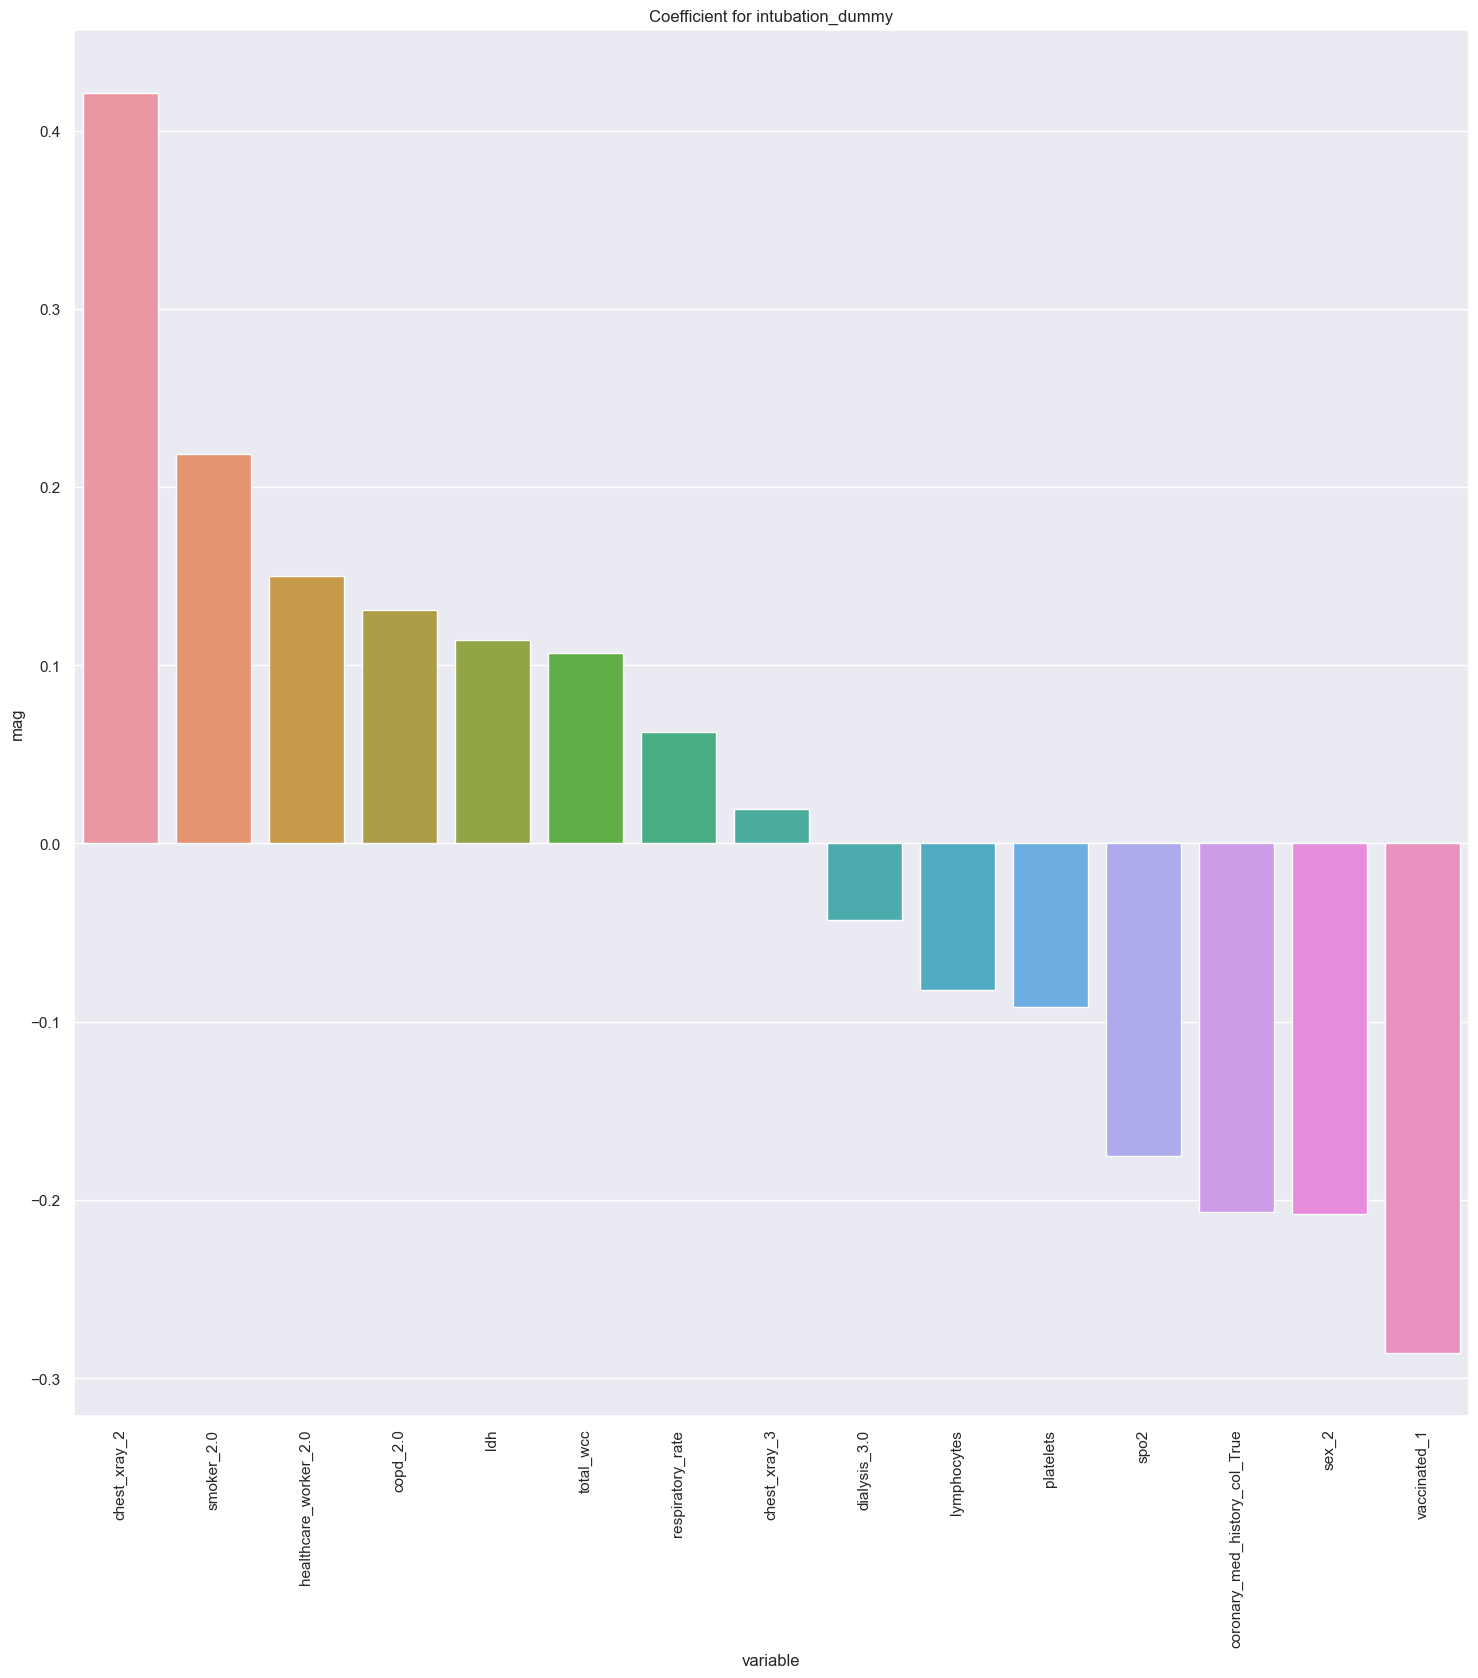

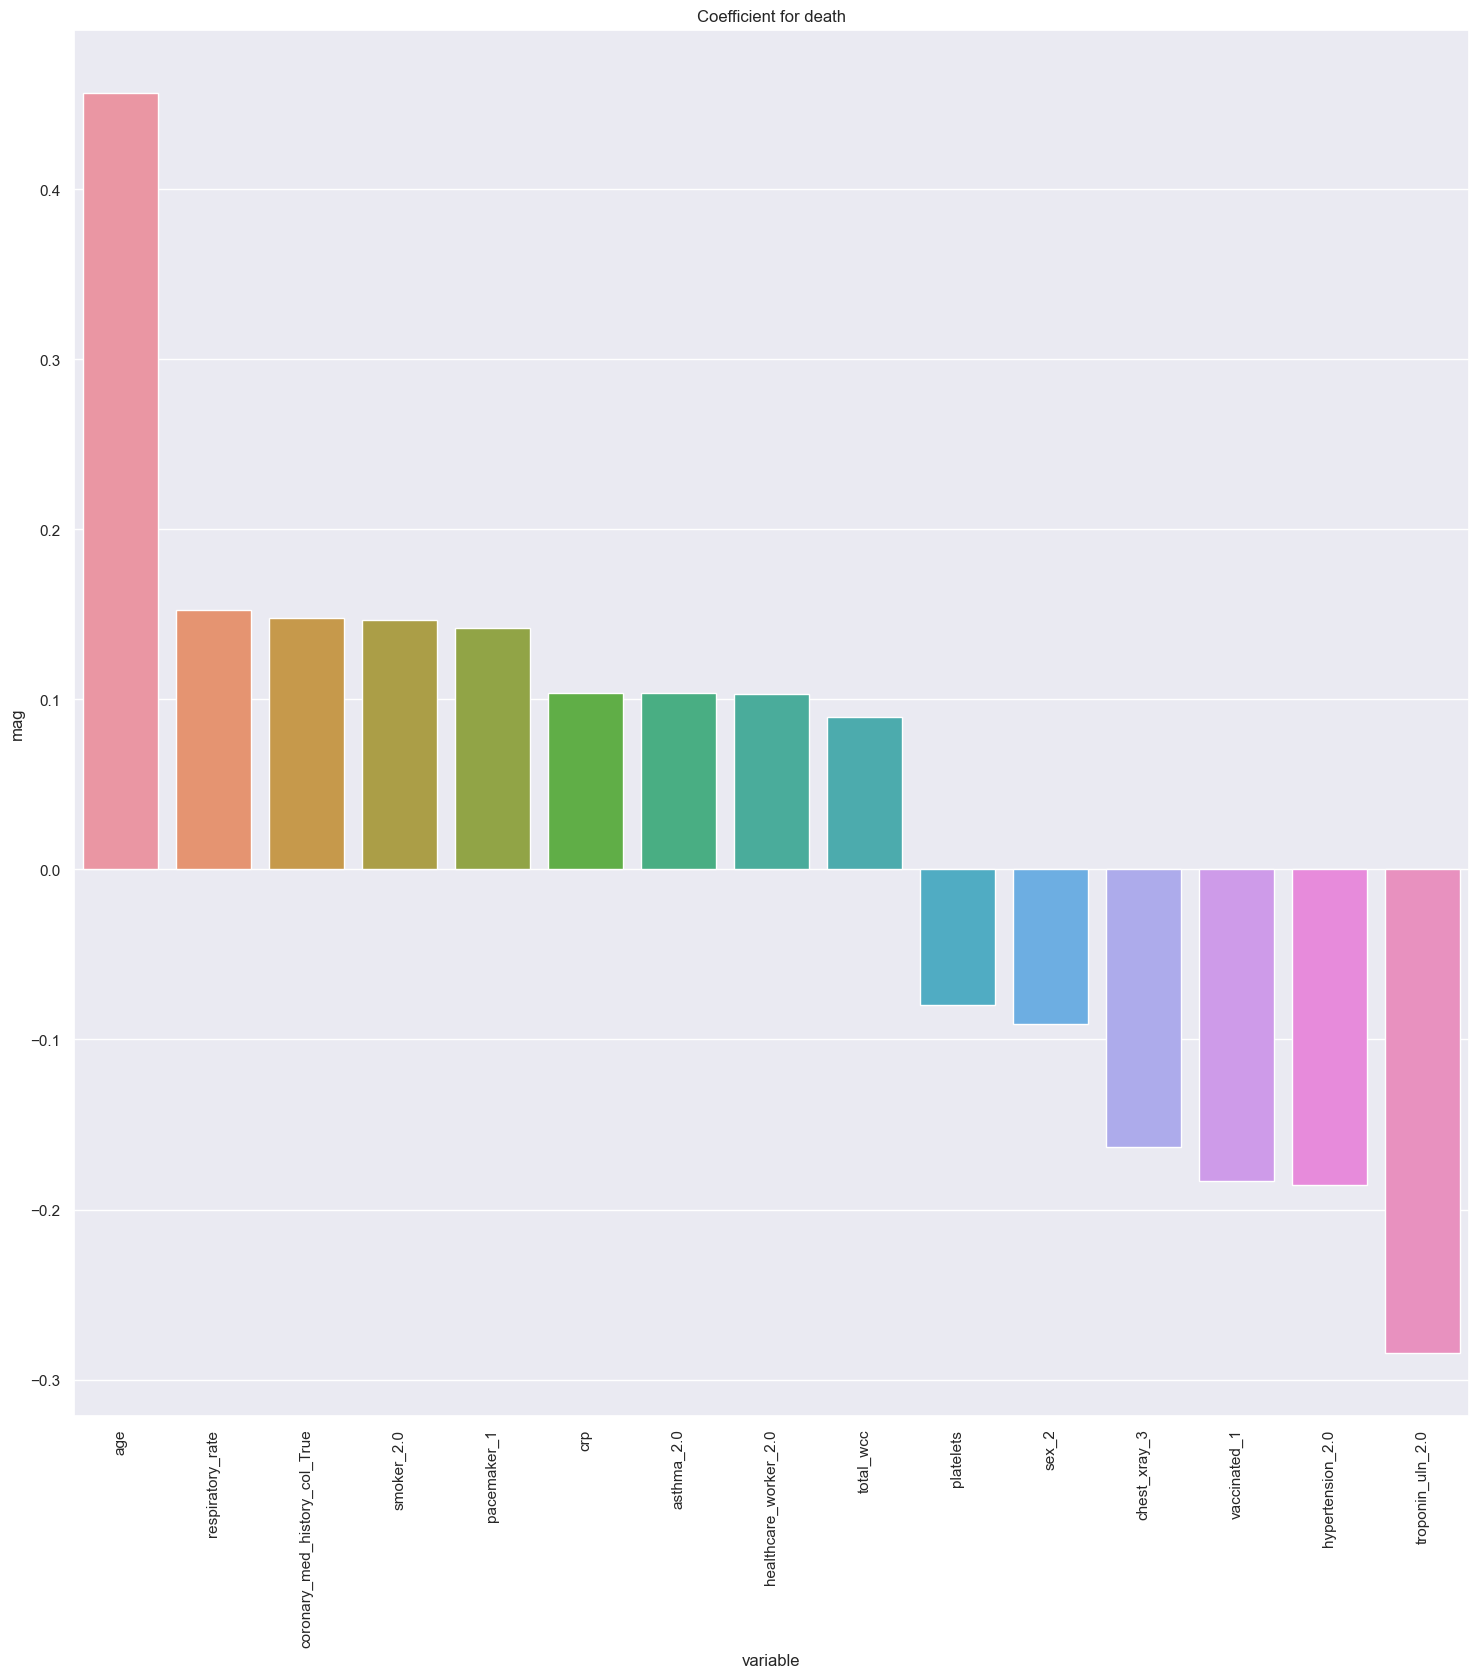

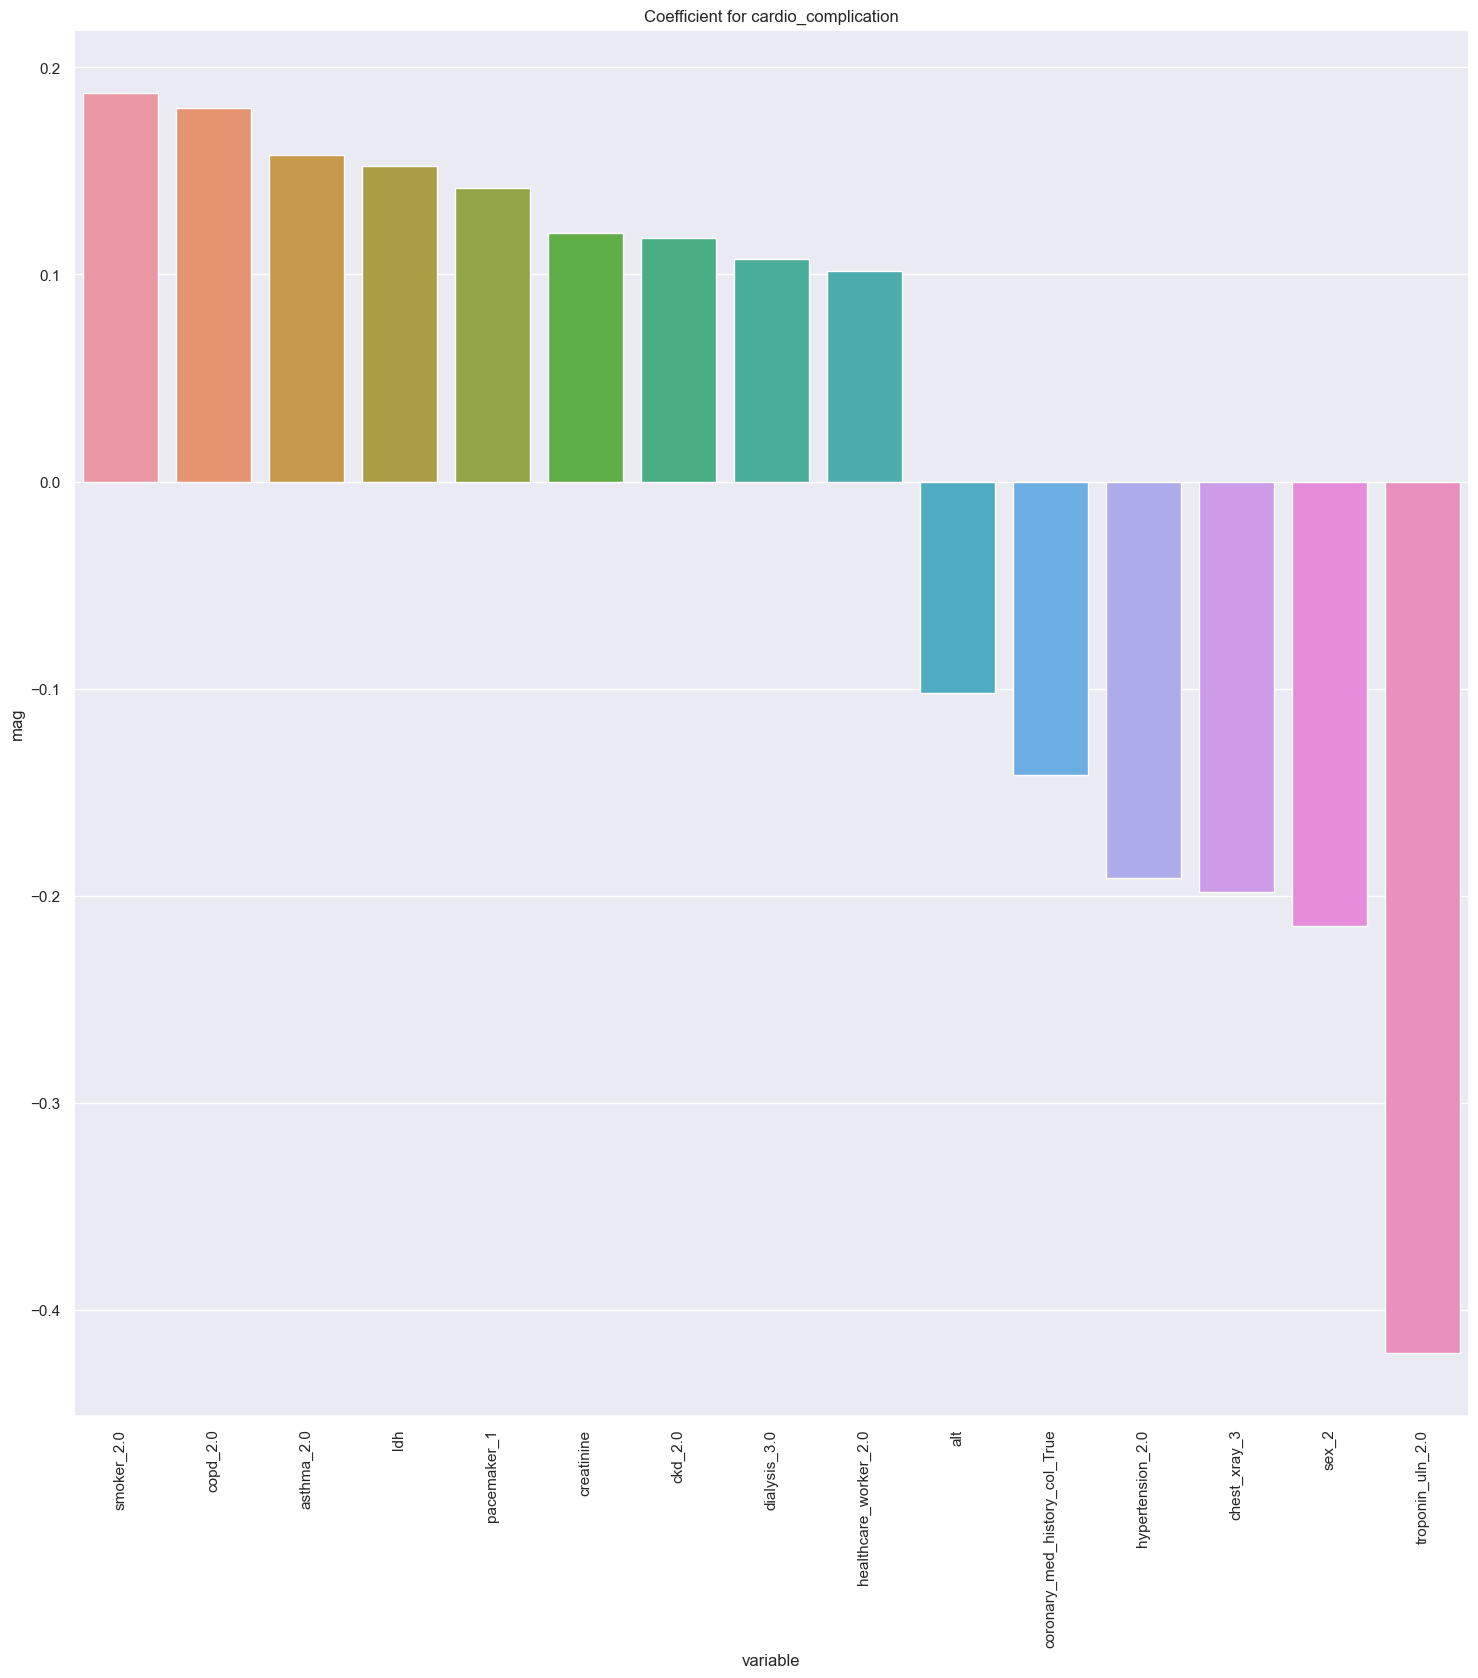

In [137]:
for p in predictor:
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    feature_select = loaded_pipe.named_steps["feature_selection"].get_support() 
    coefs = loaded_pipe.named_steps["svm"].coef_
    coef_df = pd.DataFrame(data = {'variable' : X_train.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.savefig("figure/" + model_name + "_" +p+".png",bbox_inches="tight")

In [138]:
score_df.to_csv("result/outcome.csv")
test_df.to_csv("result/test_result.csv")

In [140]:
test_df

,model,accuracy,precision,recall,f1_score,auc,outcome
0,baseline_median_impute,0.909621,0.333333,0.107143,0.162162,0.544048,intubation_dummy
1,baseline_median_impute,0.883382,0.266667,0.121212,0.166667,0.542864,death
2,baseline_median_impute,0.953353,0.500000,0.062500,0.111111,0.529721,cardio_complication
3,logistic_feature_selection_median_impute_overs...,0.740525,0.113924,0.321429,0.168224,0.549603,intubation_dummy
4,logistic_feature_selection_median_impute_overs...,0.743440,0.151899,0.363636,0.214286,0.573754,death
...,...,...,...,...,...,...,...
79,linear_svm_median_impute,0.900875,0.400000,0.060606,0.105263,0.525464,death
80,linear_svm_median_impute,0.953353,0.000000,0.000000,0.000000,0.500000,cardio_complication
81,linear_svm_median_impute_oversample,0.758017,0.151899,0.428571,0.224299,0.607937,intubation_dummy
82,linear_svm_median_impute_oversample,0.813411,0.287671,0.636364,0.396226,0.734311,death


## Non linear

In [17]:
score_df = pd.read_csv(cv_result_filename,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [18]:
from sklearn.svm import SVC

param_grid = {
    "svm__kernel": ['rbf','poly'],
    'svm__C':np.linspace(1e-4,1e-1,num=10), 
    'svm__class_weight':[None], 
    'svm__degree':[3,5,7,9], 
}


In [19]:
model_name = "svm_median_impute_feature_select_oversample"
lr_model_name = "l1_feature_selection_median_impute_oversample"

In [20]:
for p in predictor:
    
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    
    loaded_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    pipeline = Pipeline(steps=[
     ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
     ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
    ("scaler", StandardScaler()), 
    ('feature_selection', SelectFromModel(LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params()),
                                              max_features=15)),
    ("svm", SVC(random_state=random_seed,probability=True))])
    
    
    grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5,scoring=scoring_method)

    grid.fit(X_train, y_train)
    
    joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(grid.best_estimator_,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [31]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    #feature_select = loaded_pipe.named_steps["feature_select"].support_
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    loaded_lr_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ('feature_selection', SelectFromModel(LogisticRegression(**loaded_lr_pipe.named_steps["logistic"].get_params()),
                                              max_features=15)),
        ("svm",SVC(**loaded_pipe.named_steps["svm"].get_params()))])
    
    
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

In [32]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)

In [33]:
score_df

,model,test_accuracy,outcome,fit_time,score_time,test_precision,test_recall,test_f1,test_roc_auc
0,baseline_median_impute,0.911737,intubation_dummy,0.083016,0.018803,0.590043,0.158333,0.240184,0.763806
1,baseline_median_impute,0.894949,death,0.023505,0.014603,0.520684,0.262299,0.345959,0.859799
2,baseline_median_impute,0.945295,cardio_complication,0.025005,0.018904,0.200000,0.026667,0.047059,0.582850
3,logistic_feature_selection_median,0.911737,intubation_dummy,0.028205,0.013003,0.590043,0.158333,0.240184,0.763806
4,logistic_feature_selection_median,0.894949,death,0.020904,0.012802,0.520684,0.262299,0.345959,0.859799
5,logistic_feature_selection_median,0.945295,cardio_complication,0.024005,0.013402,0.200000,0.026667,0.047059,0.582850
6,logistic_feature_selection_median_oversample,0.725733,intubation_dummy,0.487793,0.013902,0.178647,0.591667,0.273742,0.722079
7,logistic_feature_selection_median_oversample,0.778997,death,0.532502,0.014303,0.291679,0.722759,0.415047,0.832691
8,logistic_feature_selection_median_oversample,0.678349,cardio_complication,0.593612,0.013003,0.075188,0.431429,0.127833,0.573801
9,l2_feature_selection_median_impute_oversample,0.725733,intubation_dummy,0.440781,0.013103,0.178647,0.591667,0.273742,0.722079


## Adaboost

In [25]:
score_df = pd.read_csv(cv_result_filename,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [26]:
model_name = "adaboost_median_impute_feature_oversample"


lr_model_name = "l1_feature_selection_median_impute_oversample"

In [27]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    "ada__n_estimators": np.arange(5,30,5),
    'ada__learning_rate':np.linspace(1e-2,10,num=10), 
}


In [28]:
for p in predictor:

    
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    
    loaded_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    pipeline = Pipeline(steps=[
     ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
    ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
    ("scaler", StandardScaler()), 
    ('feature_selection', SelectFromModel(LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params()),
            max_features=15)),
    ("ada", AdaBoostClassifier(random_state=random_seed))])
    
    
    grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5,scoring=scoring_method)

    grid.fit(X_train, y_train)
    
    joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(grid.best_estimator_,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [30]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    #feature_select = loaded_pipe.named_steps["feature_select"].support_
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    loaded_lr_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
       ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ('feature_selection', SelectFromModel(
            LogisticRegression(**loaded_lr_pipe.named_steps["logistic"].get_params()),
            max_features=15)),
        ("ada",AdaBoostClassifier(**loaded_pipe.named_steps["ada"].get_params()))])
    
    
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

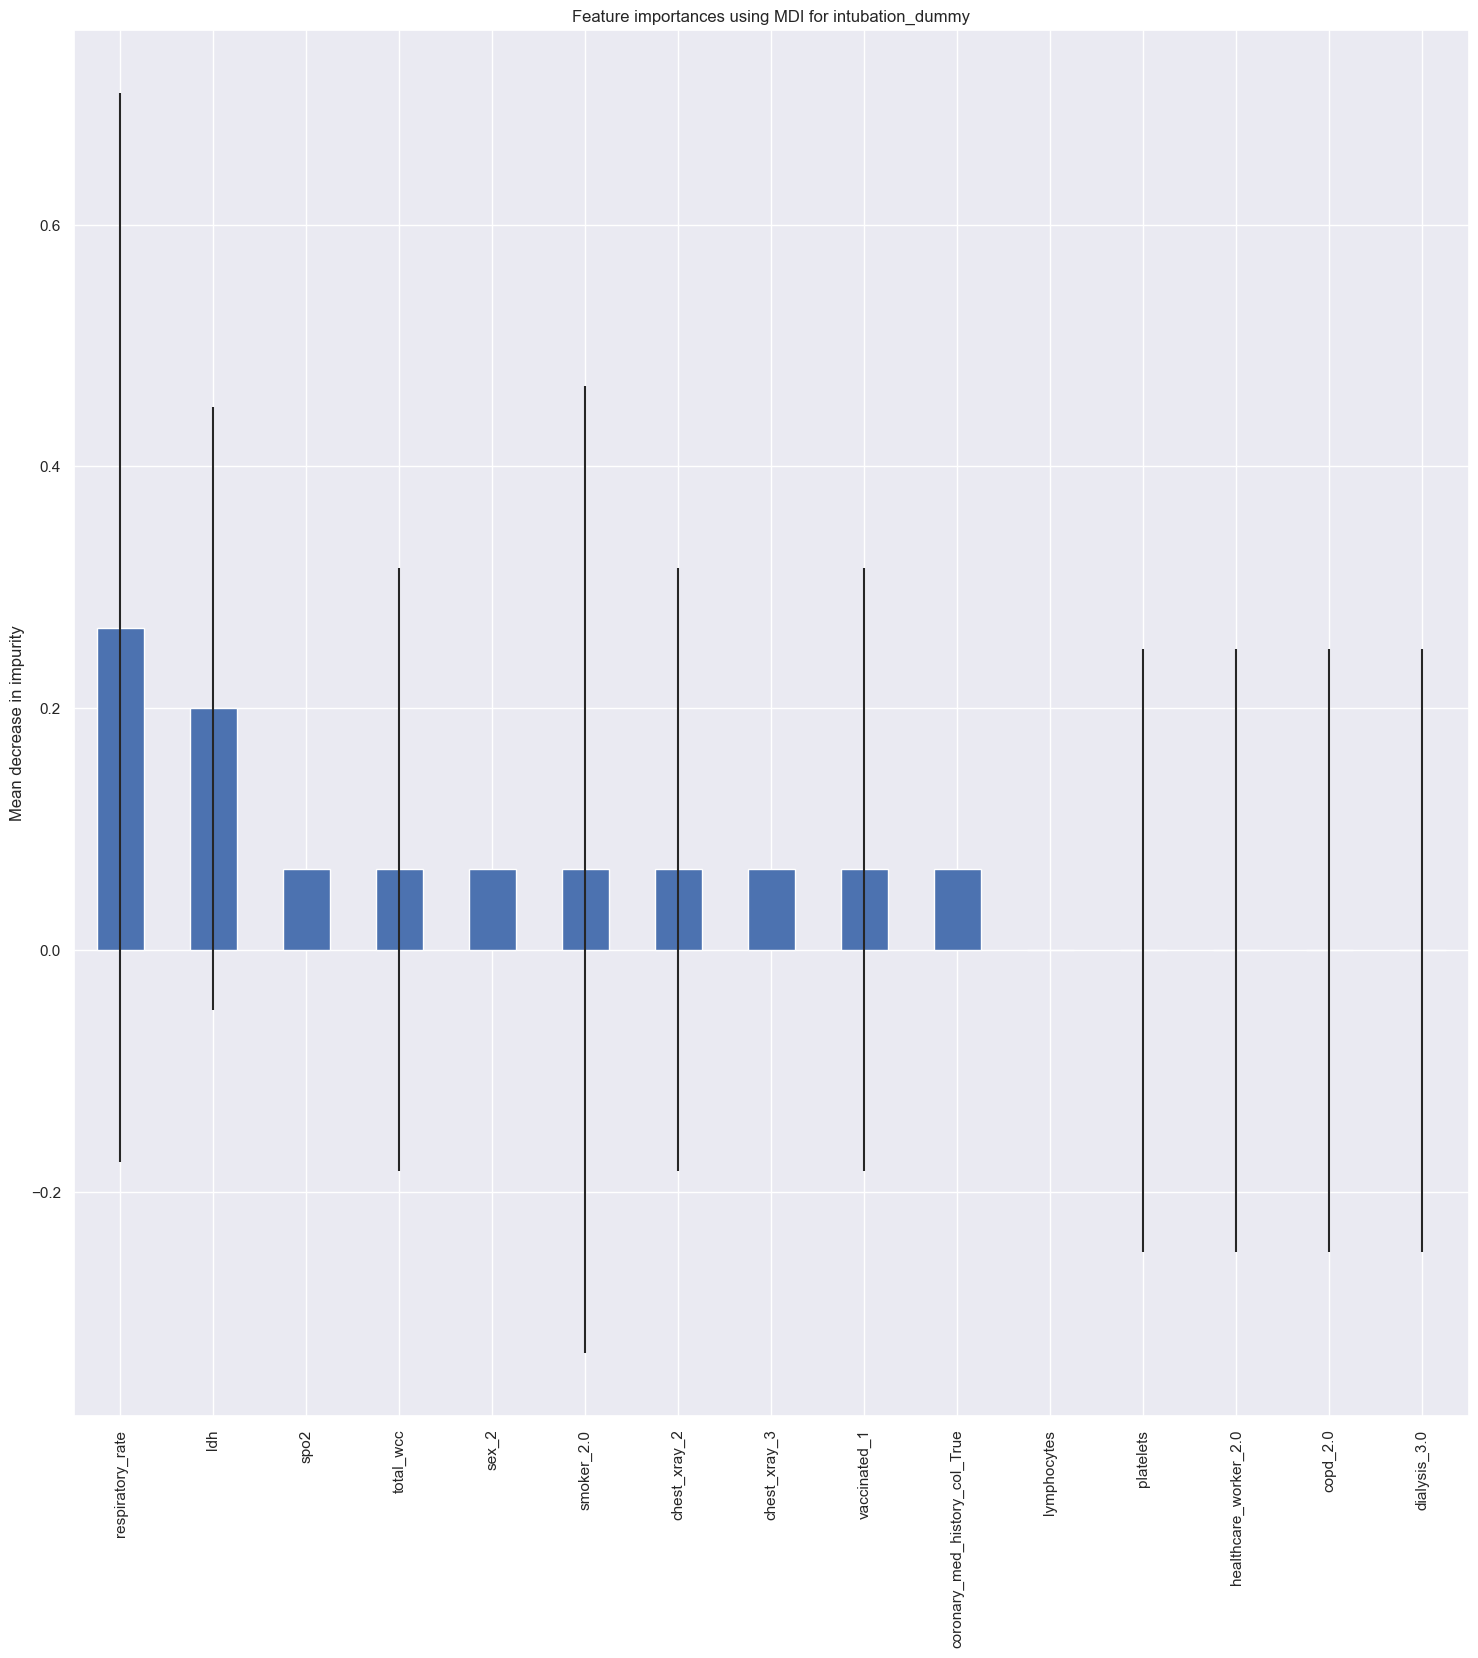

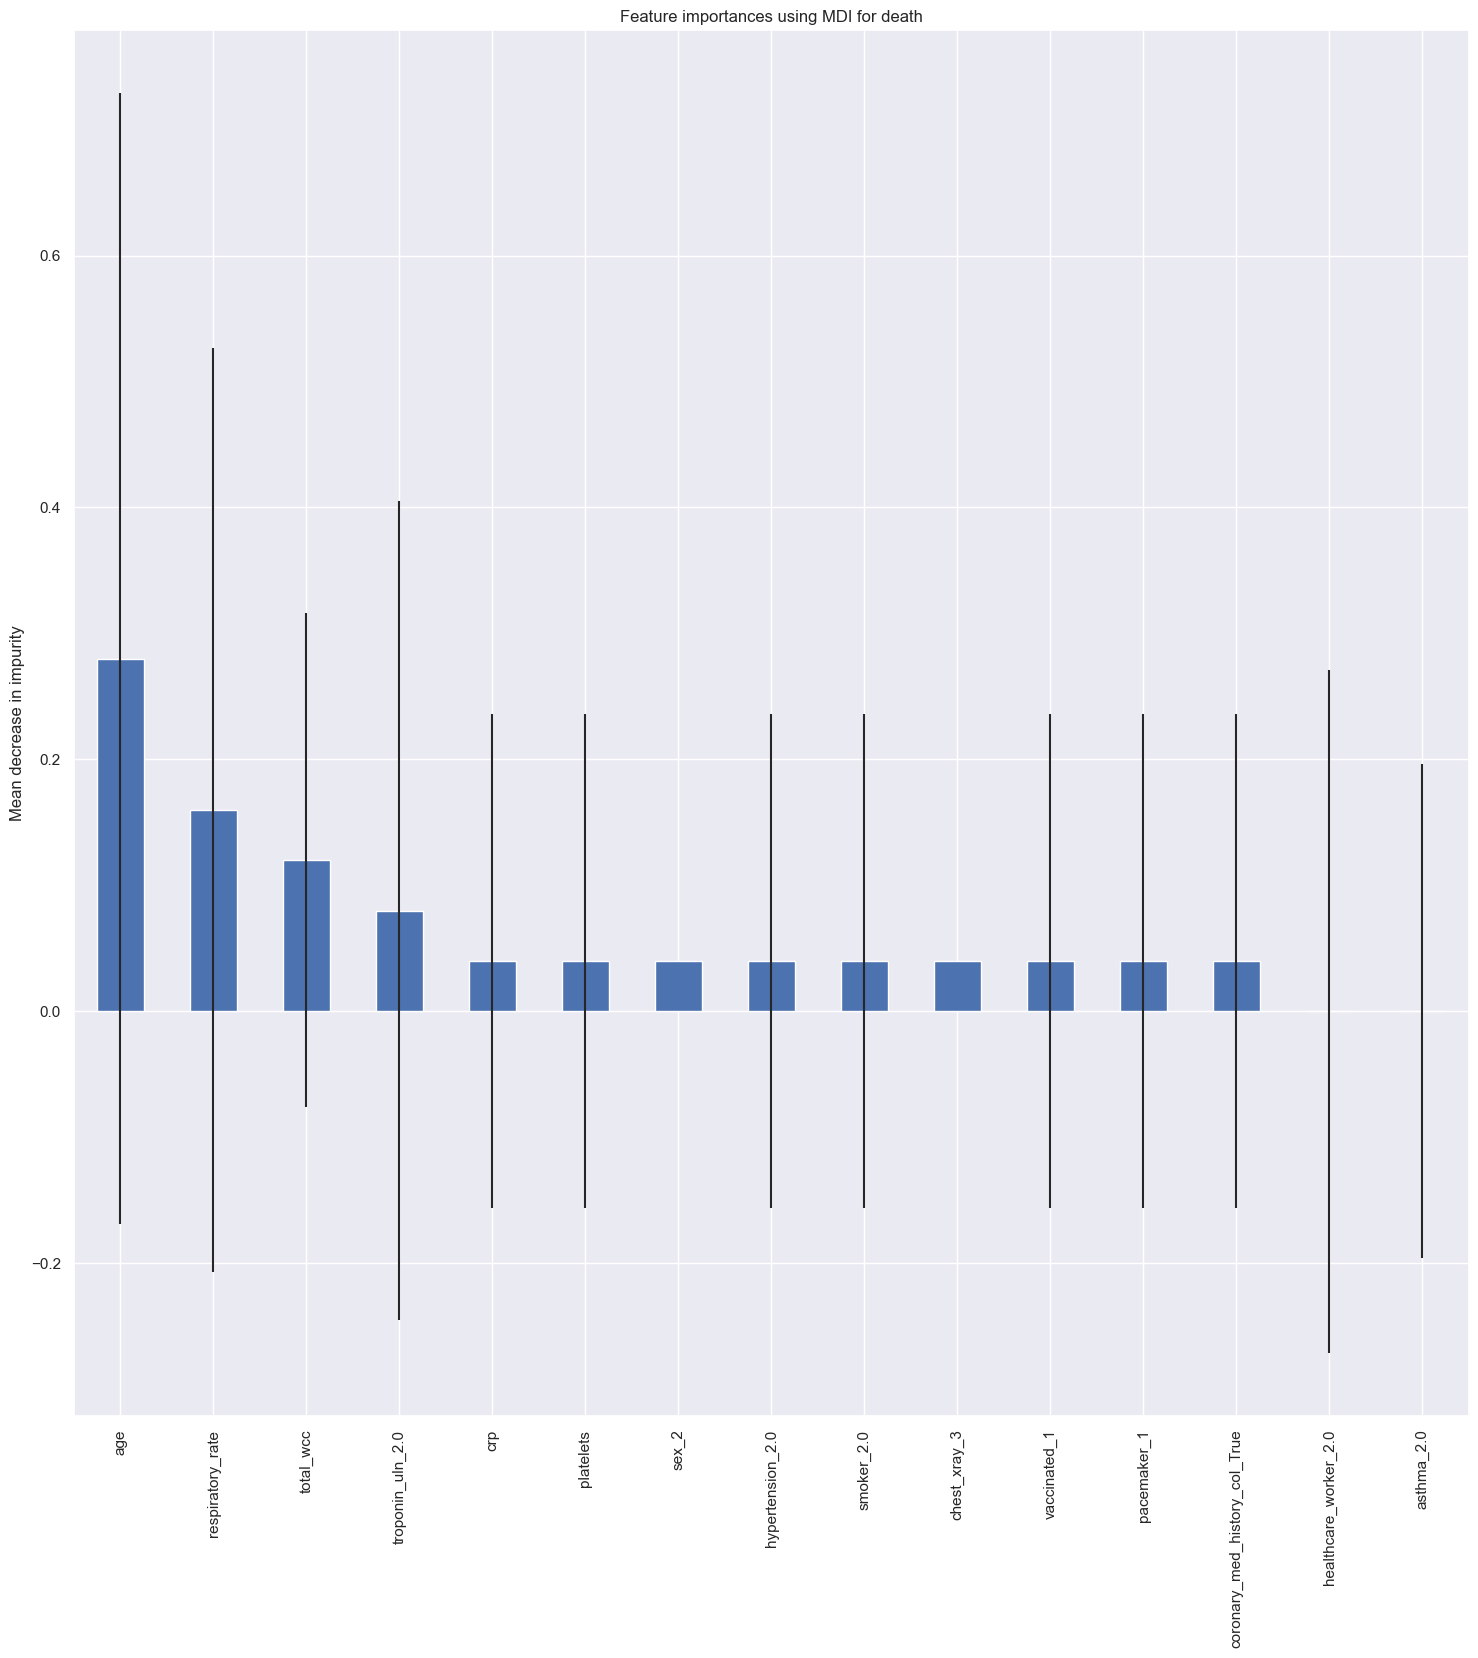

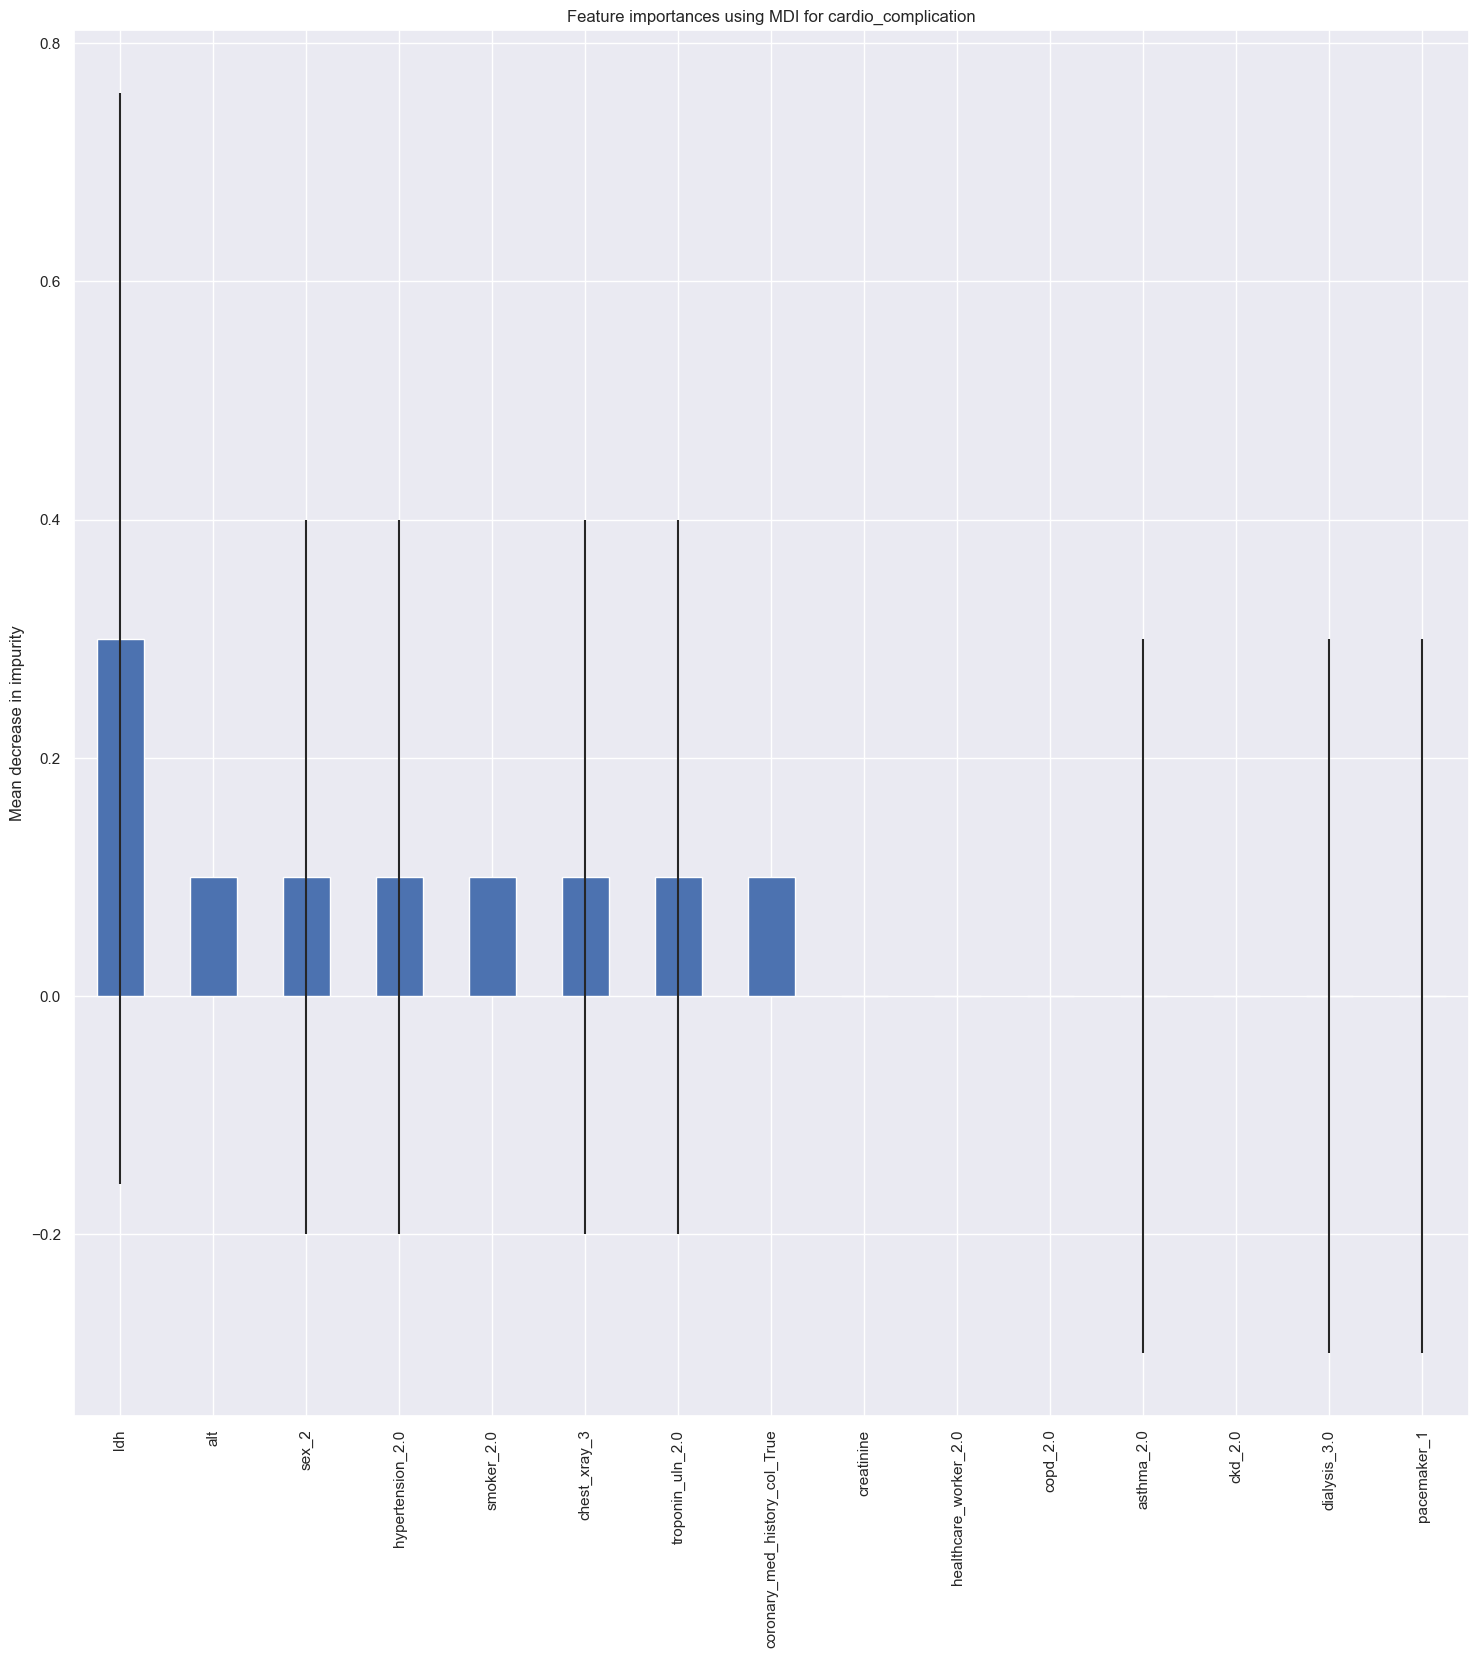

In [31]:
for p in predictor:
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    feature_select = loaded_pipe.named_steps["feature_selection"].get_support()

    importances = loaded_pipe.named_steps["ada"].feature_importances_
    std = np.std([tree.feature_importances_ for tree in loaded_pipe.named_steps["ada"].estimators_], axis=0)


    forest_importances = pd.Series(importances, index= X_train.columns[feature_select])
    forest_importances = forest_importances.sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(18, 18))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI for " + p)
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout
    
    plt.savefig("figure/" + model_name + "_coeff_" + p +".png",bbox_inches="tight")

In [32]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)

In [33]:
score_df

,model,test_accuracy,outcome,fit_time,score_time,test_precision,test_recall,test_f1,test_roc_auc
0,baseline_median_impute,0.911737,intubation_dummy,0.083016,0.018803,0.590043,0.158333,0.240184,0.763806
1,baseline_median_impute,0.894949,death,0.023505,0.014603,0.520684,0.262299,0.345959,0.859799
2,baseline_median_impute,0.945295,cardio_complication,0.025005,0.018904,0.200000,0.026667,0.047059,0.582850
3,logistic_feature_selection_median,0.911737,intubation_dummy,0.028205,0.013003,0.590043,0.158333,0.240184,0.763806
4,logistic_feature_selection_median,0.894949,death,0.020904,0.012802,0.520684,0.262299,0.345959,0.859799
...,...,...,...,...,...,...,...,...,...
62,adaboost_median_impute_feature_oversample,0.816940,death,0.536981,0.020405,0.318787,0.587816,0.411821,0.820150
63,adaboost_median_impute_feature_oversample,0.722821,cardio_complication,0.822536,0.015386,0.085198,0.418095,0.140768,0.606244
64,adaboost_median_impute_feature_oversample,0.786275,intubation_dummy,2.630403,0.020804,0.196956,0.466667,0.275770,0.734127
65,adaboost_median_impute_feature_oversample,0.816940,death,0.670159,0.022404,0.318787,0.587816,0.411821,0.820150


## Gradient Boosting

In [34]:
score_df = pd.read_csv(cv_result_filename,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [35]:
model_name = "gradboost_median_impute_feature_oversample"

lr_model_name = "l1_feature_selection_median_impute_oversample"

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {
    "gb__max_depth": np.arange(3,20,3),
    'gb__max_features':['sqrt',None],
    'gb__learning_rate':np.linspace(0.1,5,5)
}


In [37]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    
    loaded_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    pipeline = Pipeline(steps=[
     ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
     ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
    ("scaler", StandardScaler()), 
    ('feature_selection', SelectFromModel(LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params()),
            max_features=15)),
    ("gb", GradientBoostingClassifier(random_state=random_seed,n_estimators=100))])
    
    
    grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5)

    grid.fit(X_train, y_train)
    

    joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    test_result_df = evaluate_model(grid.best_estimator_,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [38]:
for p in predictor:
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    #feature_select = loaded_pipe.named_steps["feature_select"].support_
    cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
    
    loaded_lr_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
    
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
         ("scaler", StandardScaler()), 
        ('feature_selection', SelectFromModel(LogisticRegression(**loaded_lr_pipe.named_steps["logistic"].get_params()),
            max_features=15)),
        ("gb",GradientBoostingClassifier(**loaded_pipe.named_steps["gb"].get_params()))])
    
    
    cv_result = cross_validate(test_pipe, X_train, y_train, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]
    df_cv_result = pd.DataFrame(results)
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

In [39]:
test_df

,model,accuracy,precision,recall,f1_score,auc,outcome
0,baseline_median_impute,0.909621,0.333333,0.107143,0.162162,0.544048,intubation_dummy
1,baseline_median_impute,0.883382,0.266667,0.121212,0.166667,0.542864,death
2,baseline_median_impute,0.953353,0.500000,0.062500,0.111111,0.529721,cardio_complication
3,logistic_feature_selection_median,0.915452,0.000000,0.000000,0.000000,0.498413,intubation_dummy
4,logistic_feature_selection_median,0.900875,0.000000,0.000000,0.000000,0.498387,death
...,...,...,...,...,...,...,...
61,adaboost_median_impute_feature_oversample,0.833819,0.312500,0.606061,0.412371,0.732063,death
62,adaboost_median_impute_feature_oversample,0.673469,0.055556,0.375000,0.096774,0.531537,cardio_complication
63,gradboost_median_impute_feature_oversample,0.857143,0.111111,0.107143,0.109091,0.515476,intubation_dummy
64,gradboost_median_impute_feature_oversample,0.874636,0.375000,0.454545,0.410959,0.686950,death


In [40]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)